In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda, Reshape, LeakyReLU, Attention


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Fully connected Model

In [468]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
   
timeDist = TimeDistributed(Flatten())(inputs)

Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(timeDist)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_Fully_Connected")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)

Model: "Flattened_Fully_Connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
dense_71 (Dense)             (None, 52, 100)           1000100   
_________________________________________________________________
flatten_69 (Flatten)         (None, 5200)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 10000)             52010000  
Total params: 53,010,100
Trainable params: 53,010,100
Non-trainable params: 0
_________________________________________________________________


## Flattened LSTM Model

In [38]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(1000, return_sequences=True)(timeDist)
LSTM_layer2 = LSTM(1000, return_sequences=True)(LSTM_layer1)
LSTM_layer3 = LSTM(1000)(LSTM_layer2)
#Dense1 = Dense(1000, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer2)
Dense2 = Dense(Y_train.shape[1])(LSTM_layer3)
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 52, 10000)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 52, 1000)          44004000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 52, 1000)          8004000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             10010000  
Total params: 70,022,000
Trainable params: 70,022,000
Non-trainable params: 0
________________________________________

## 2D CNN LSTM

In [89]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(100)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "2DCNN_LTSM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_42 (TimeDistri (None, 52, 100, 100, 40          input_13[0][0]                   
__________________________________________________________________________________________________
time_distributed_43 (TimeDistri (None, 52, 100, 100, 420         time_distributed_42[0][0]        
__________________________________________________________________________________________________
time_distributed_44 (TimeDistri (None, 52, 50, 50, 2 0           time_distributed_43[0][0]        
_________________________________________________________________________________________

## Flatten LSTM + Attention

In [318]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#send both convolved layer and flattened layer into LSTM
timeDist3 = TimeDistributed(Flatten())(inputs)
#merge = concatenate([timeDist, timeDist3])
diffTime = Lambda(lambda x: x[:,:-1,:]-x[:,1:,:],name='timestep_diff')(timeDist3)
units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(diffTime)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax',name='attention_weights')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line
#D_temp = Dense(units*2, activation='relu')(attended_LSTM_out) # hidden layer
#For each timestep update a single weight on Dense layer
#Adding a time distributed dense layer instead of previously commented out line of summing 
#over time axis dramatically increased mae by .0002-3 consistently with different models.
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation) 

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="FLATTENED_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)

attention shape (None, 51, 100)
LSTM_layer1 shape (None, 51, 100)
sent_representation shape (None, 51, 100)
Model: "FLATTENED_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_35 (TimeDistri (None, 52, 10000)    0           input_18[0][0]                   
__________________________________________________________________________________________________
timestep_diff (Lambda)          (None, 51, 10000)    0           time_distributed_35[0][0]        
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 51, 100)      4040400     t

# TimeDistributed Attention on Pixels

In [50]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(attention1 )

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 52, 10000)    0           input_4[0][0]                    
__________________________________________________________________________________________________
permute_11 (Permute)            (None, 10000, 52)    0           time_distributed_8[0][0]         
__________________________________________________________________________________________________
W (Dense)                       (None, 10000, 52)    2756        permute_11[0][0]                 
__________________________________________________________________________

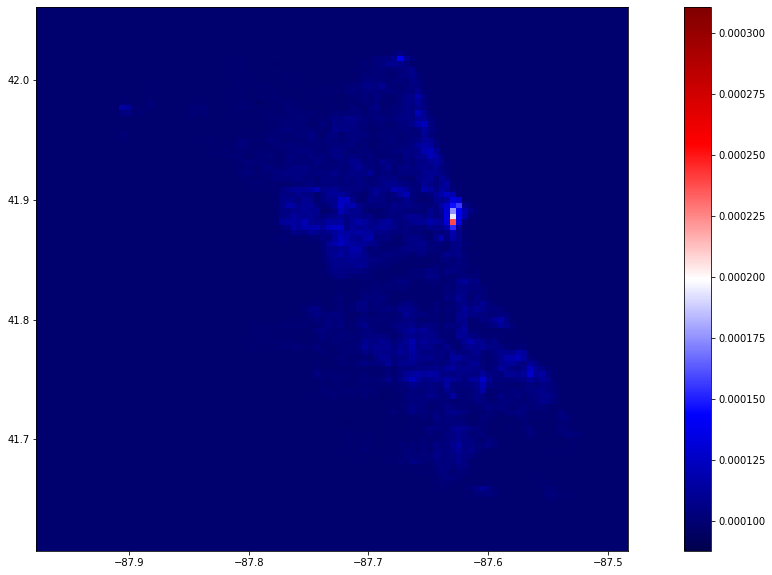

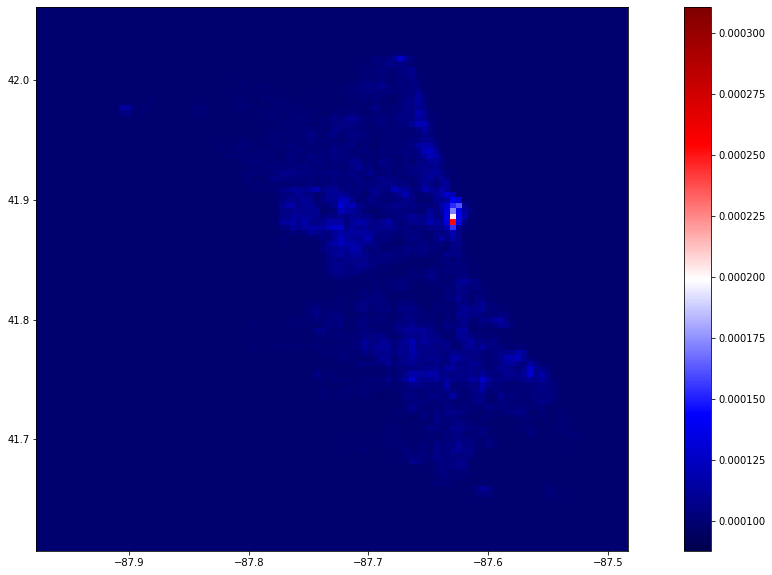

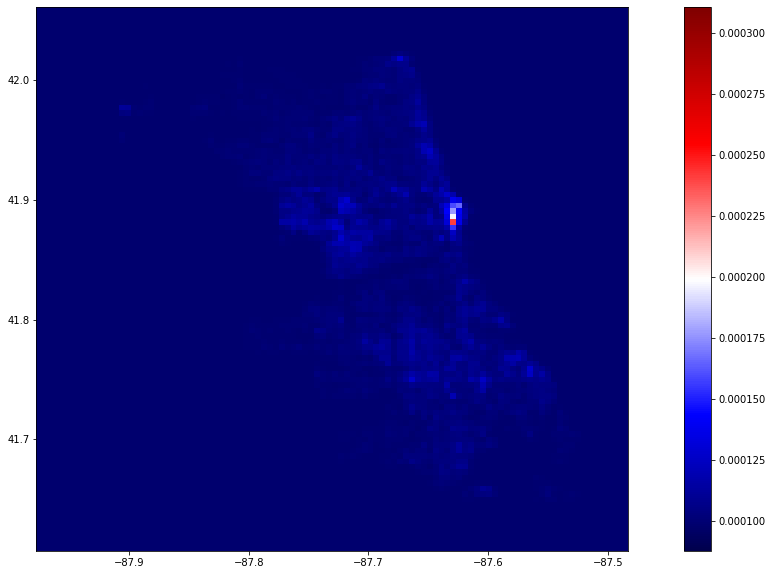

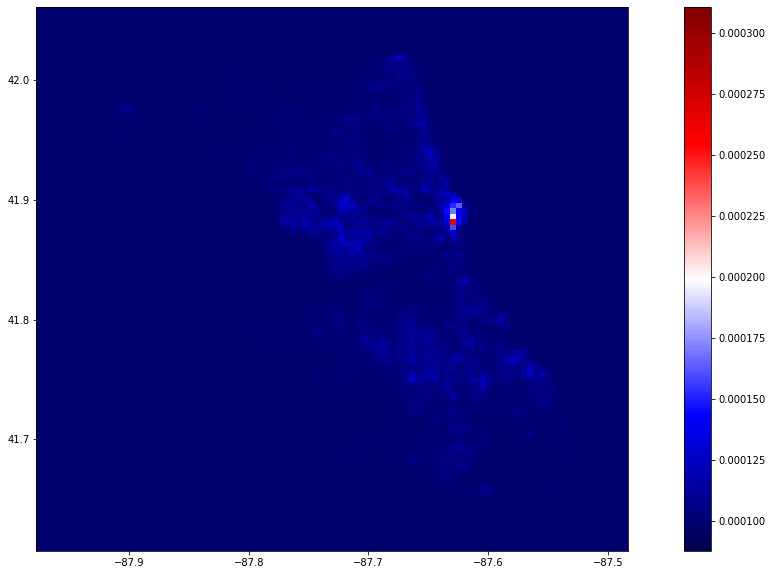

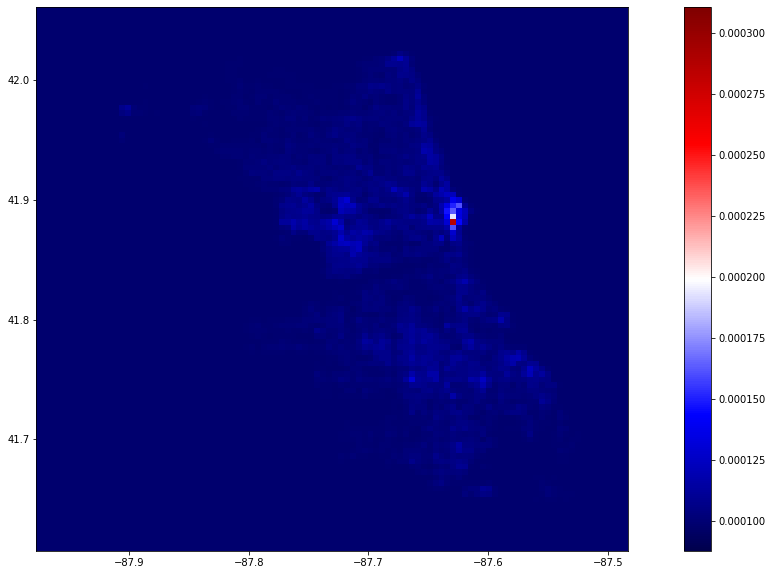

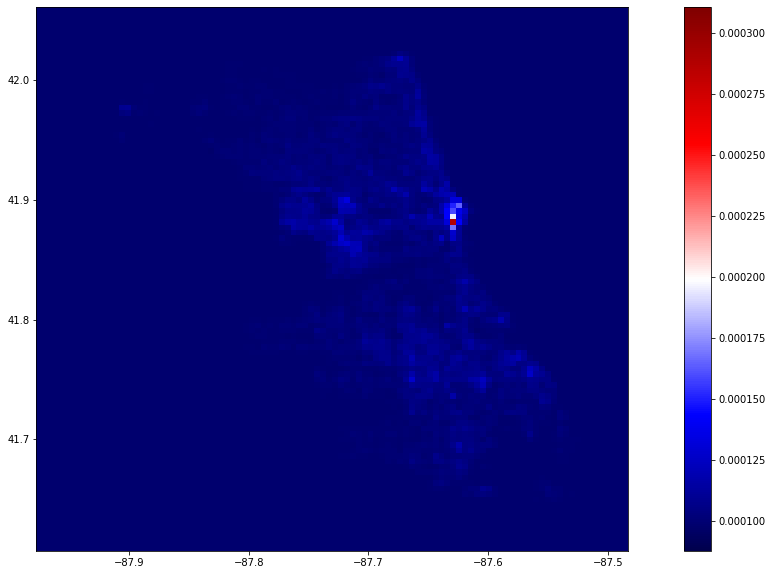

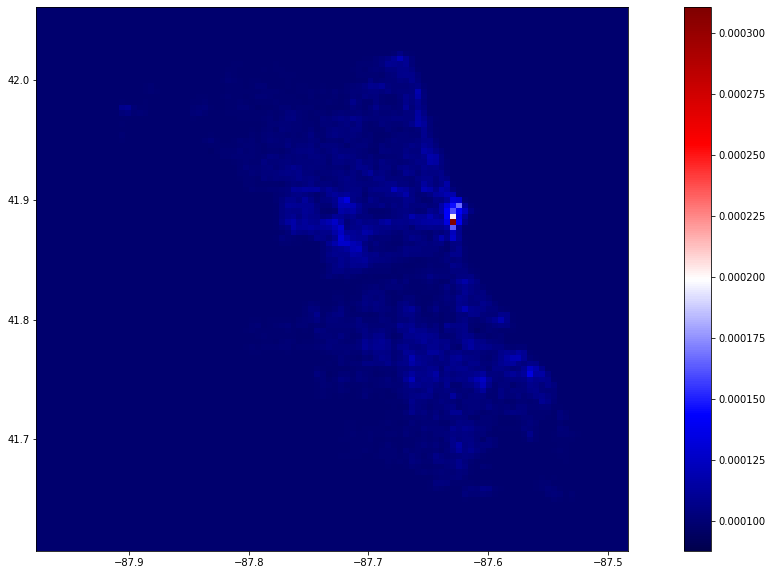

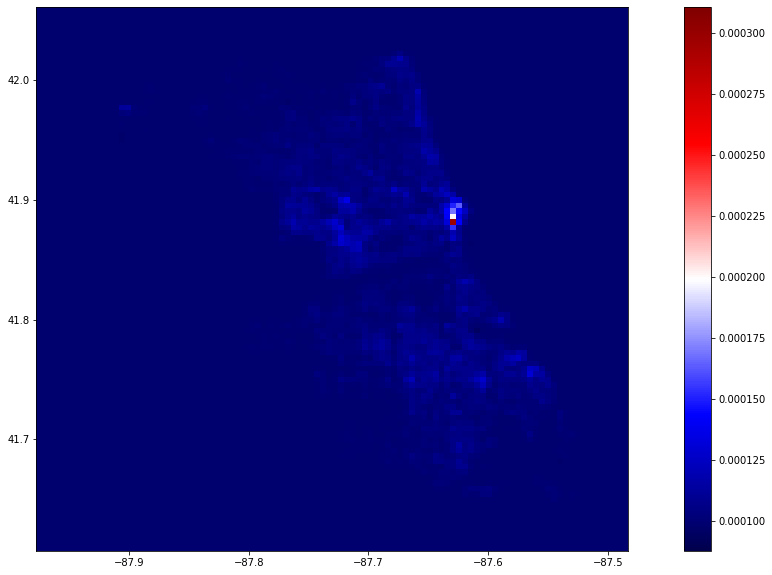

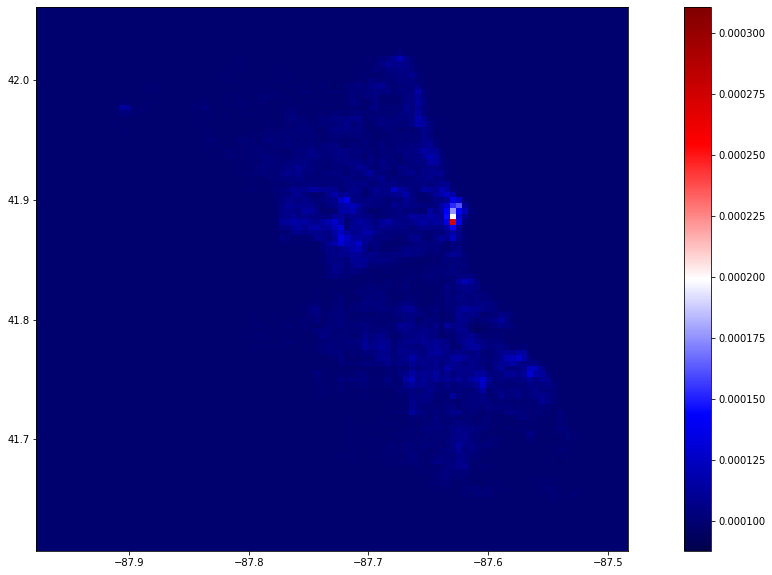

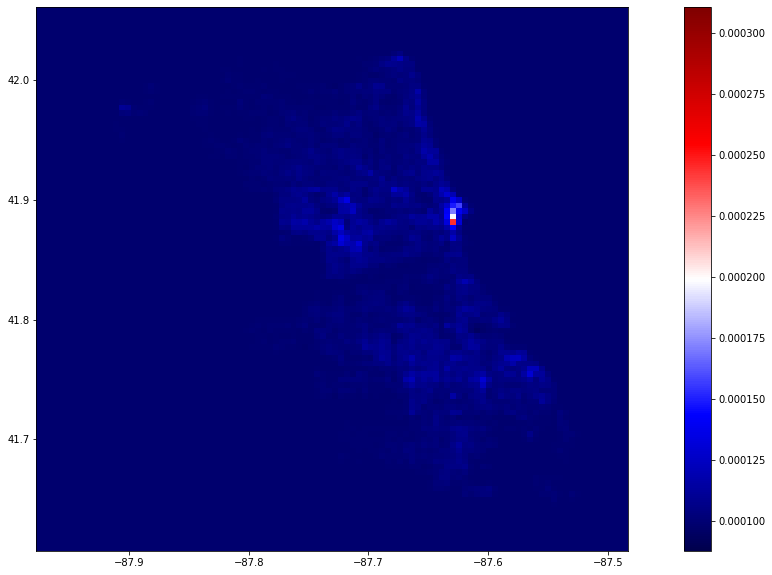

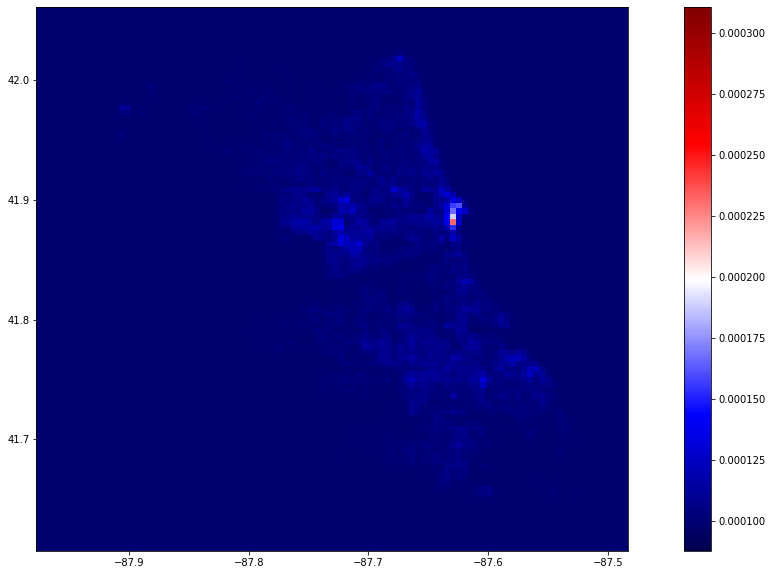

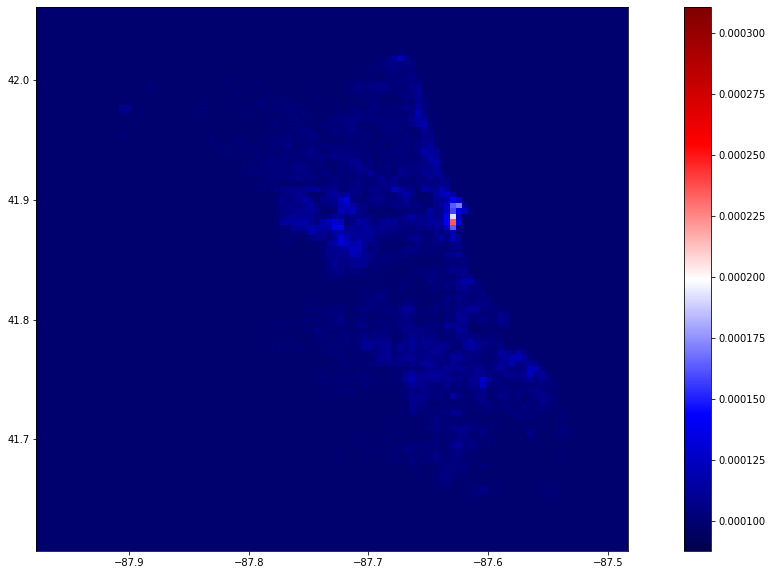

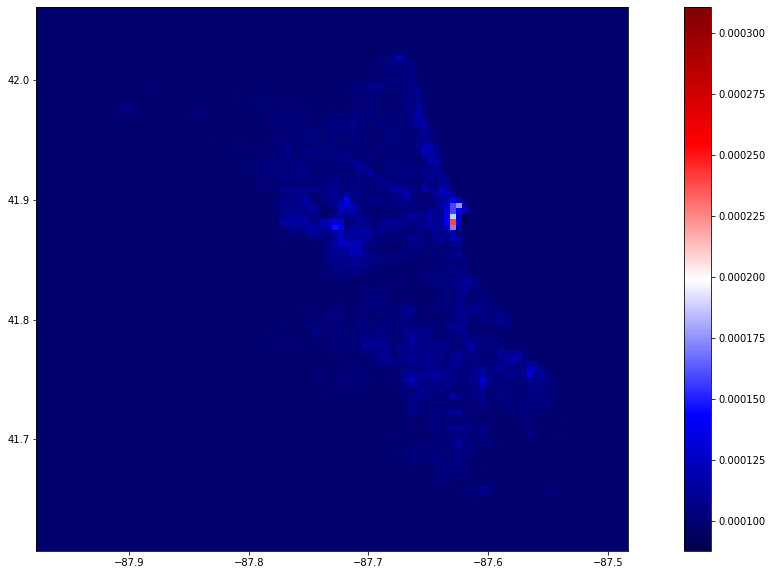

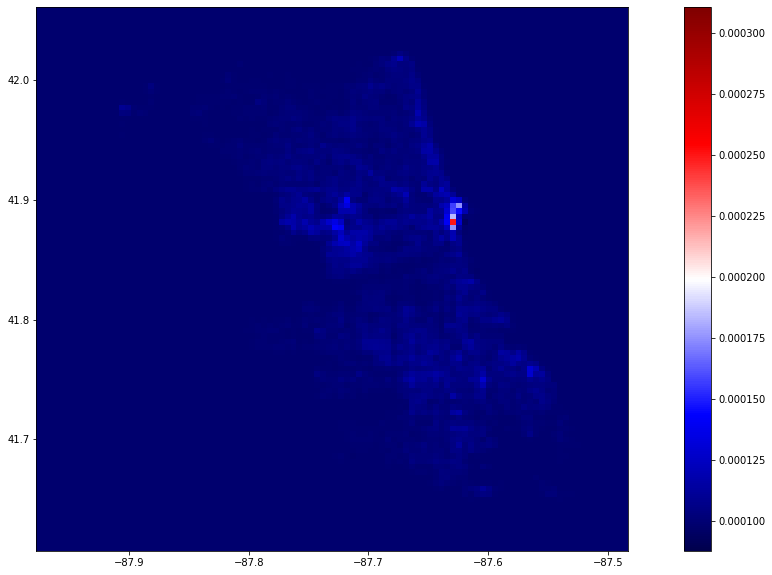

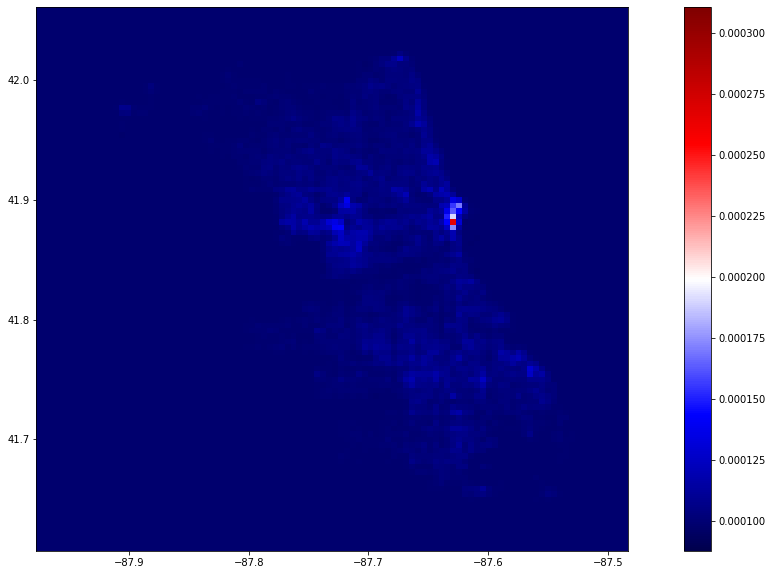

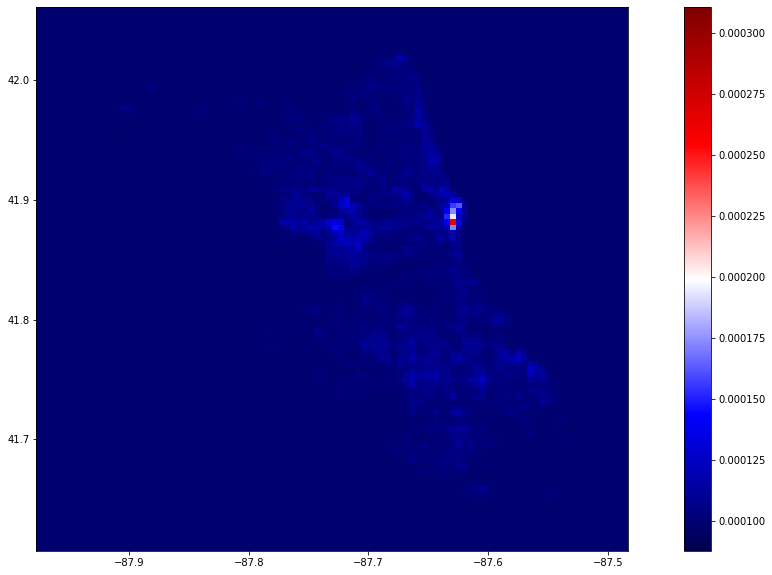

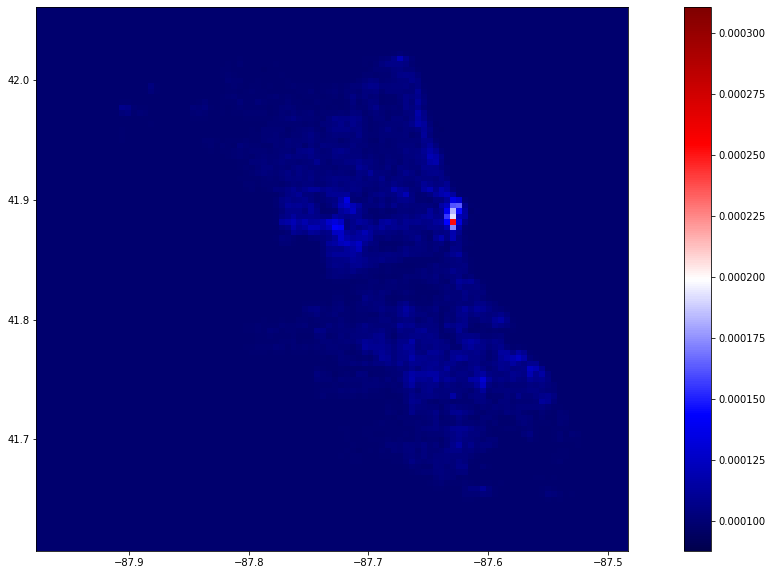

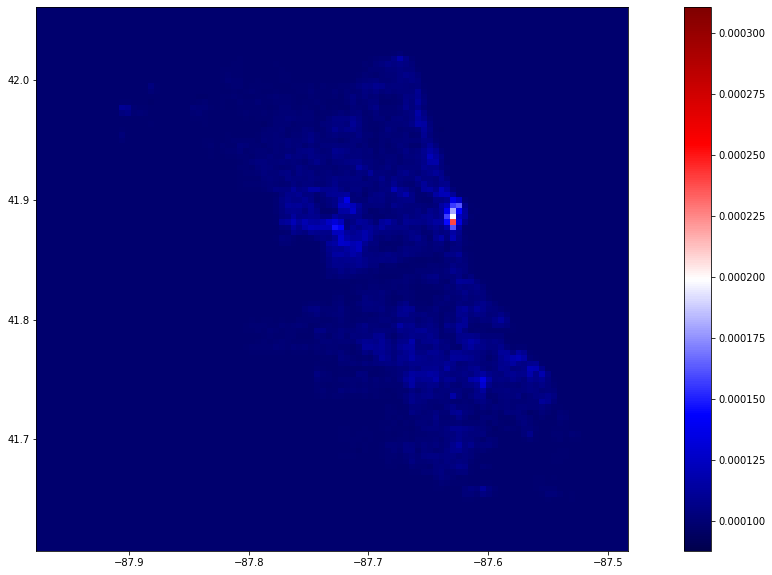

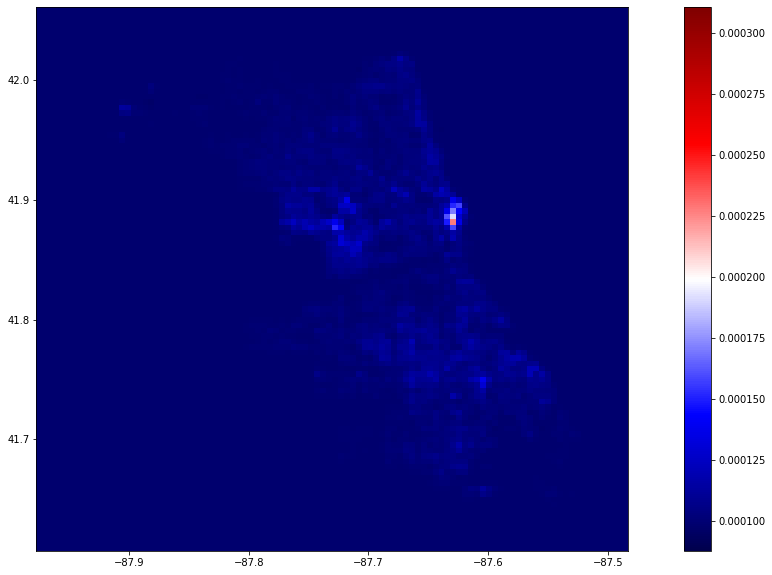

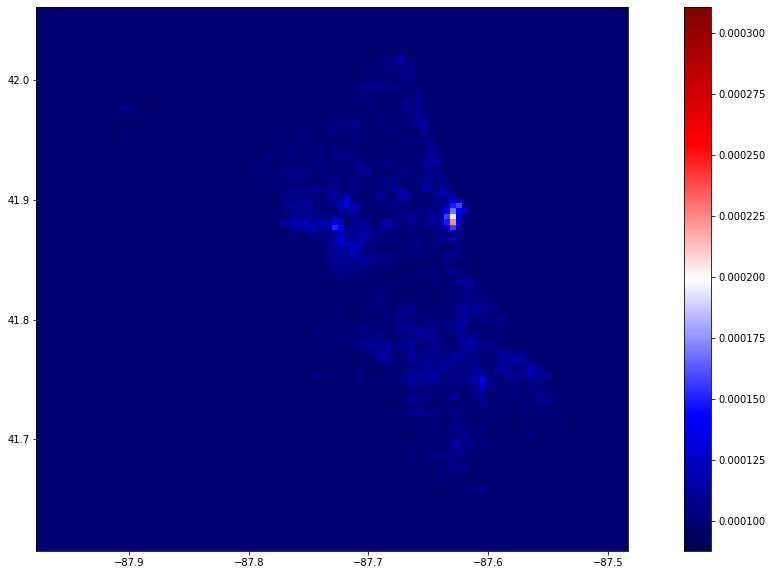

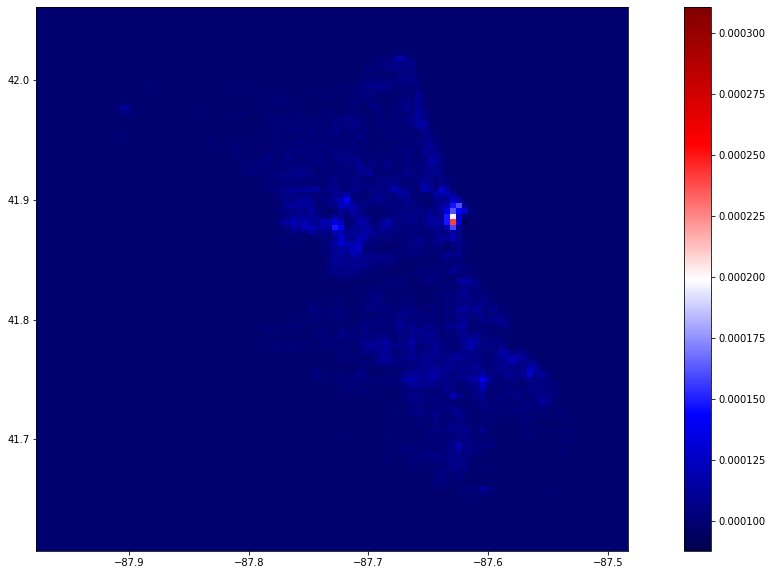

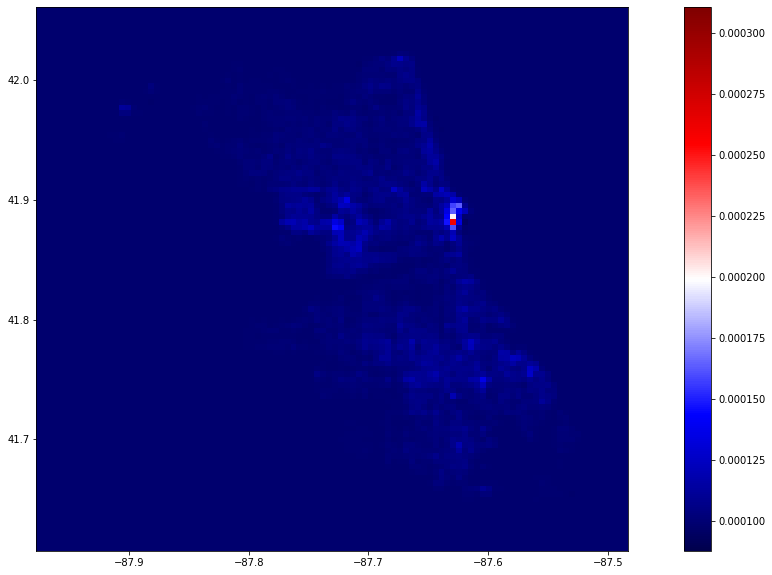

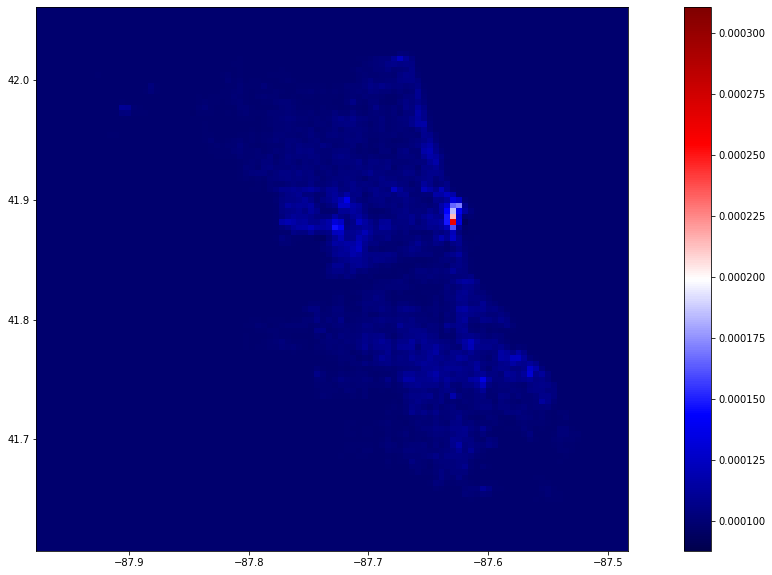

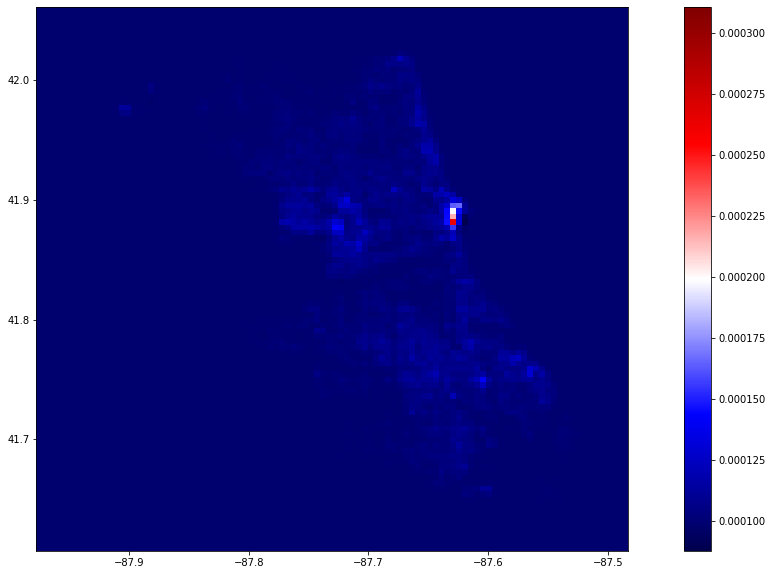

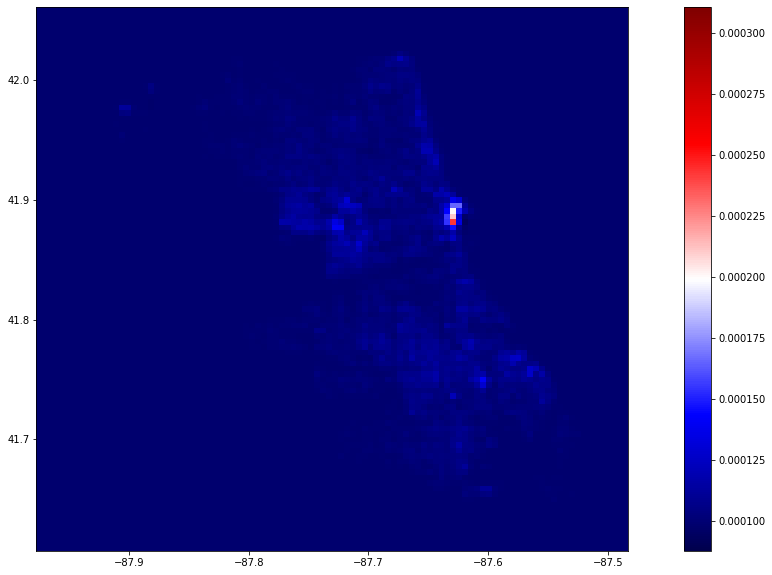

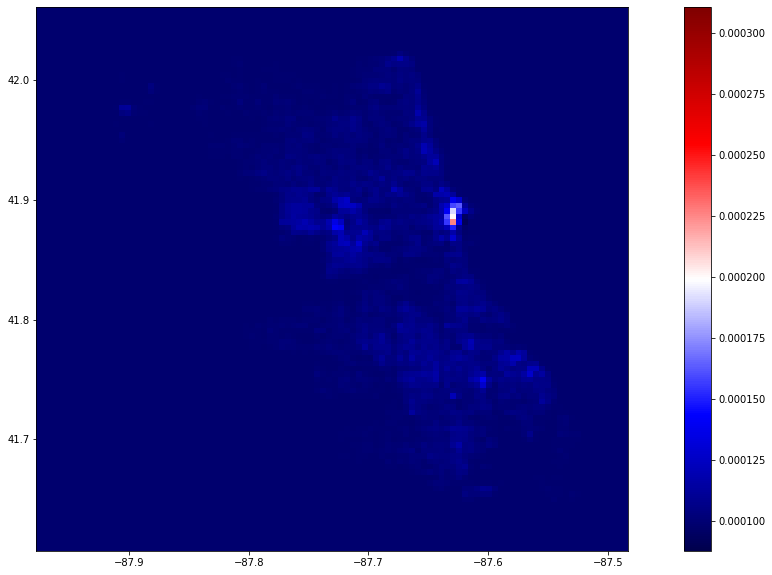

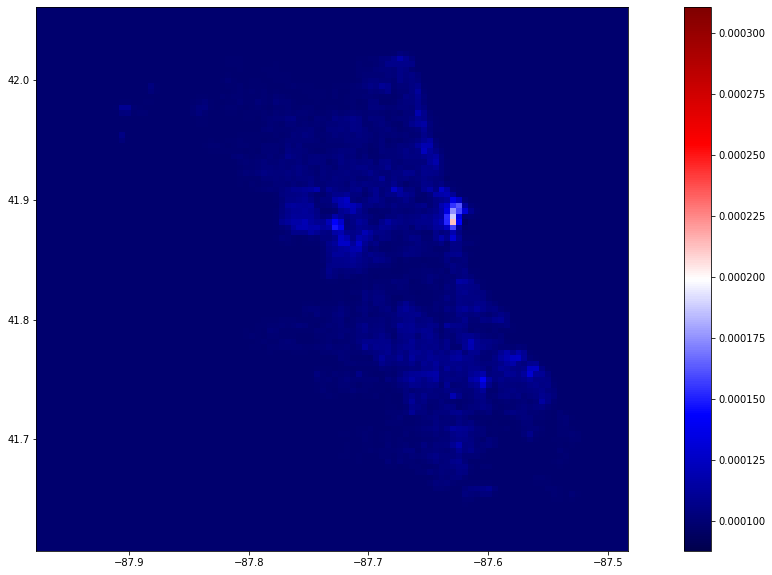

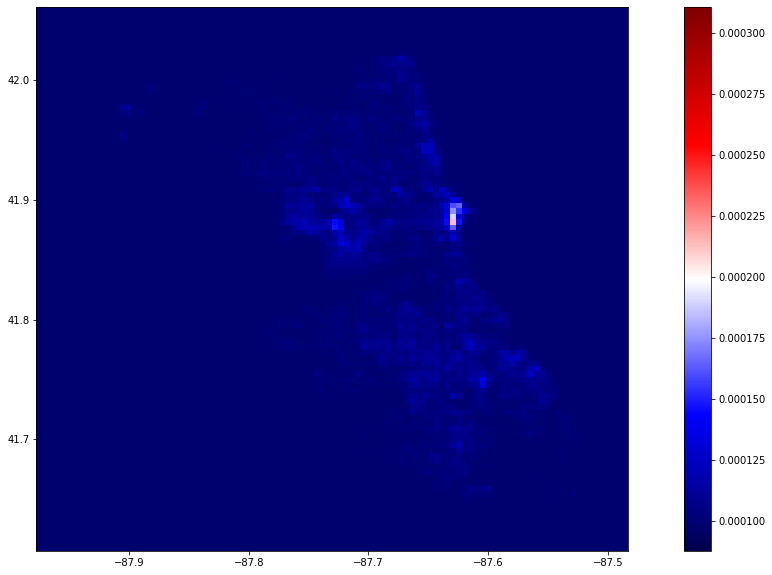

In [52]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

## TimeDistributed attention + attention on time

In [84]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh')(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear')(attention1)     ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
print(attention1.shape)
timeDist2 = TimeDistributed(Dense(1000))(attention1)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units/10, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(100, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2

model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


(None, 52, 10000)


ResourceExhaustedError: OOM when allocating tensor with shape[5200,10000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_47/kernel/Initializer/random_uniform/

In [40]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

#### We peak at trained attention1 on the image layer

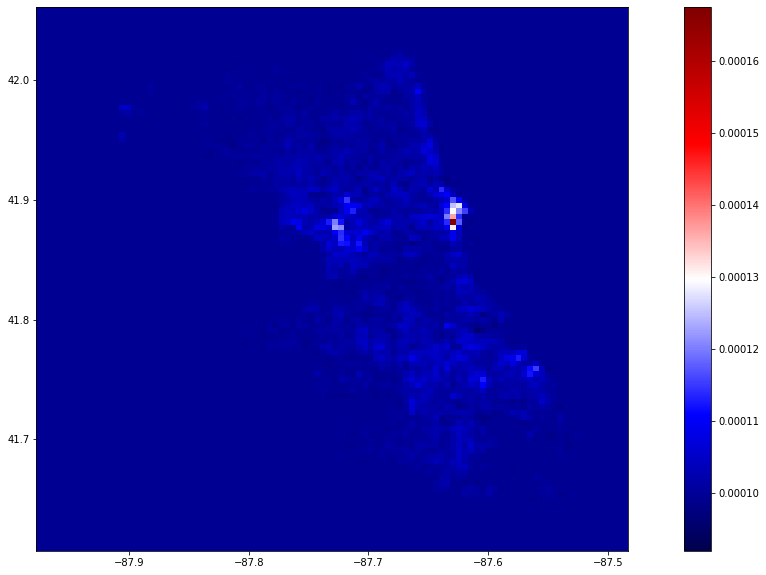

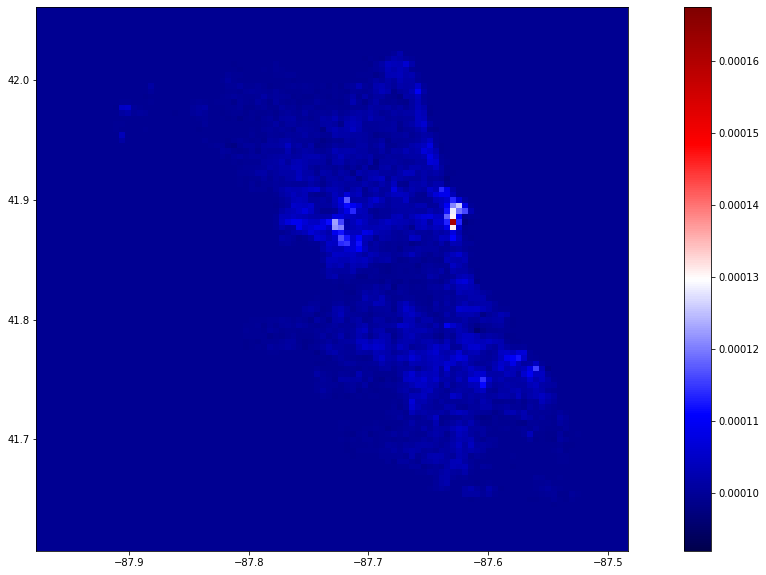

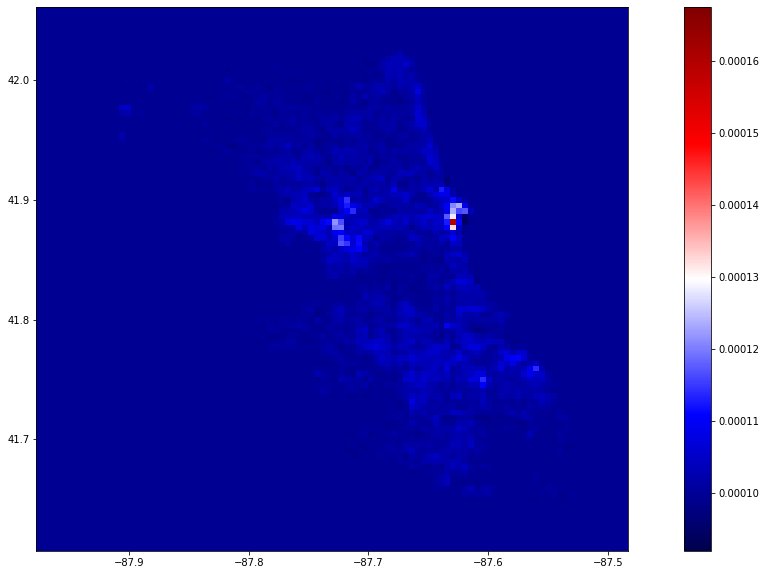

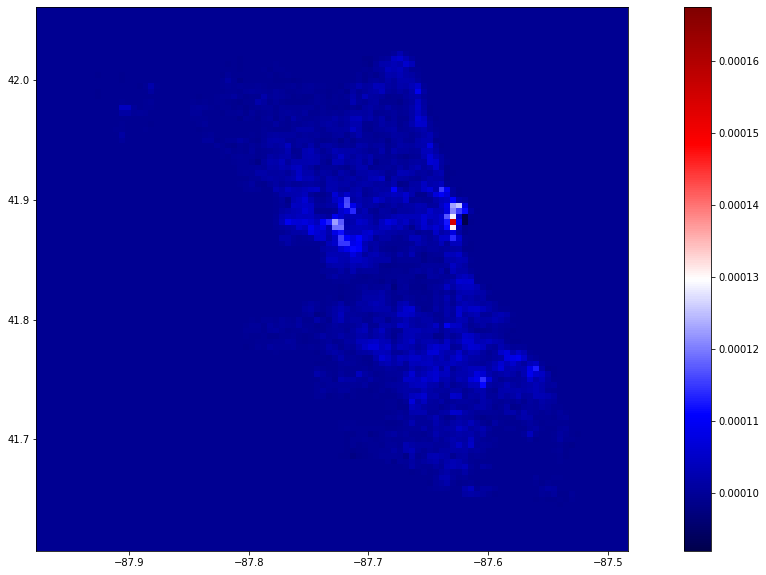

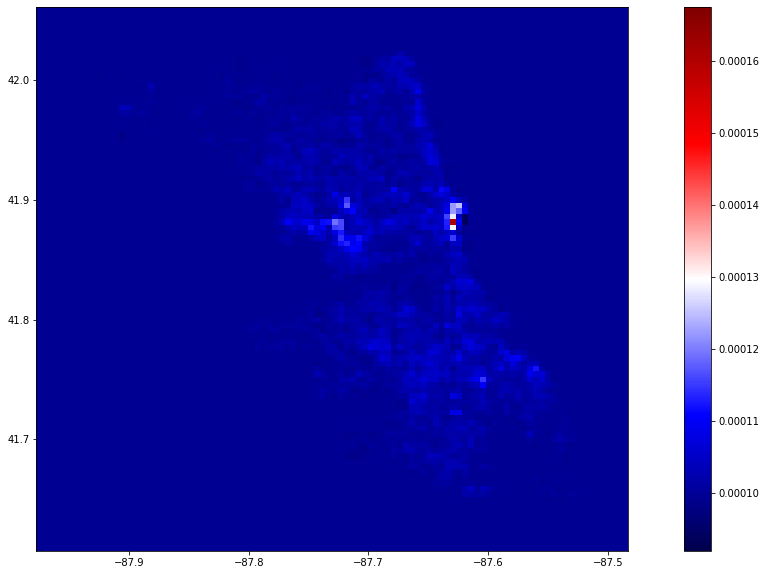

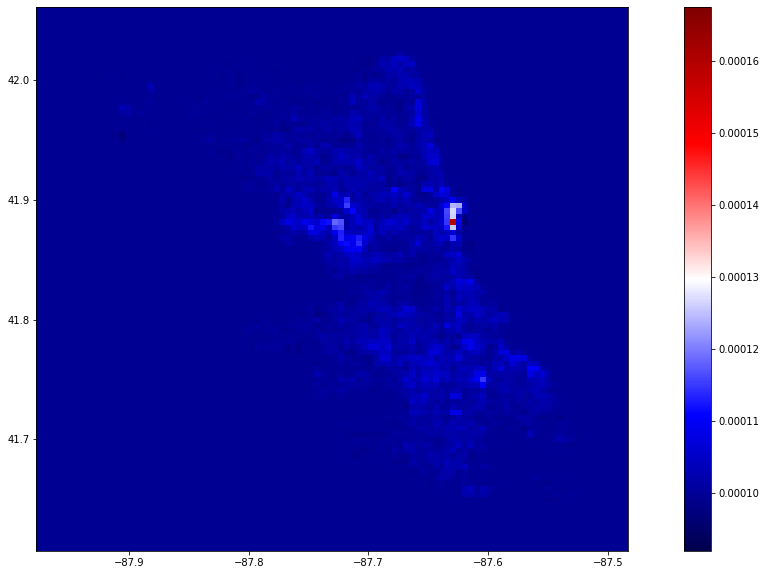

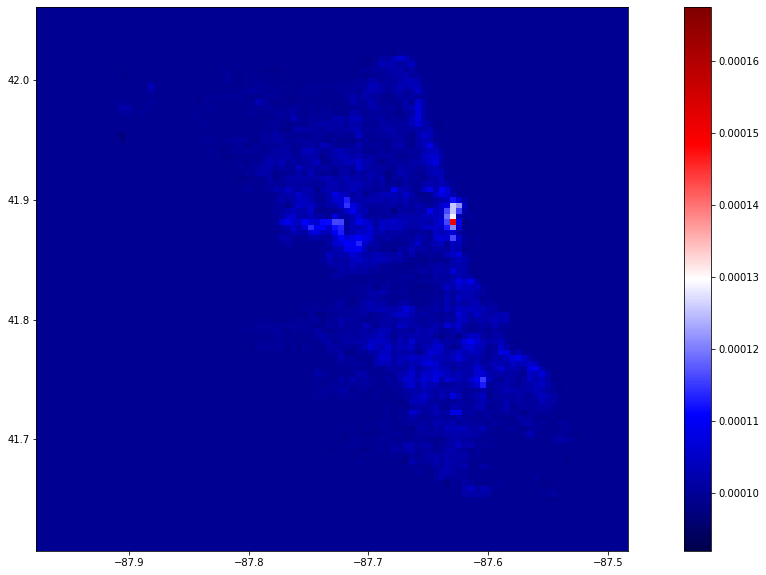

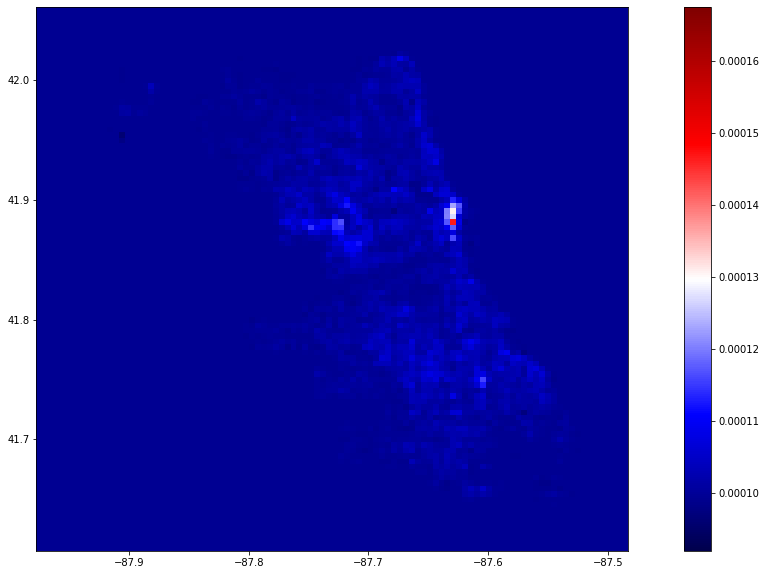

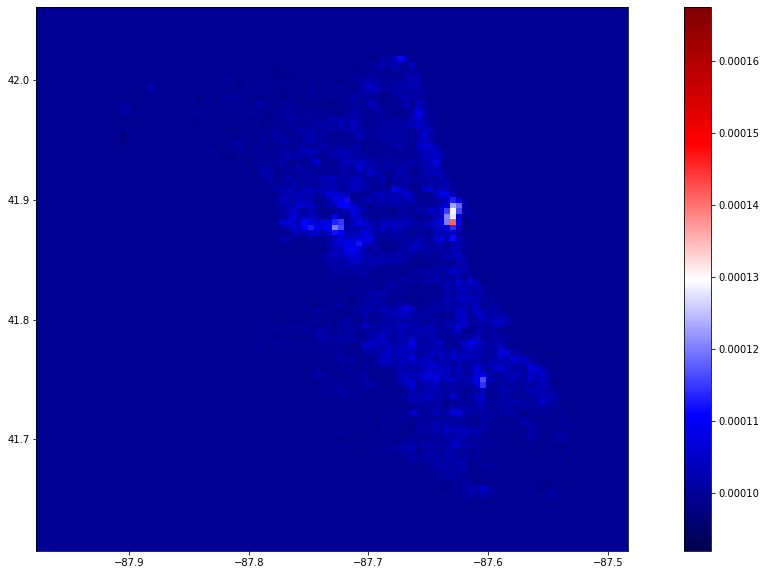

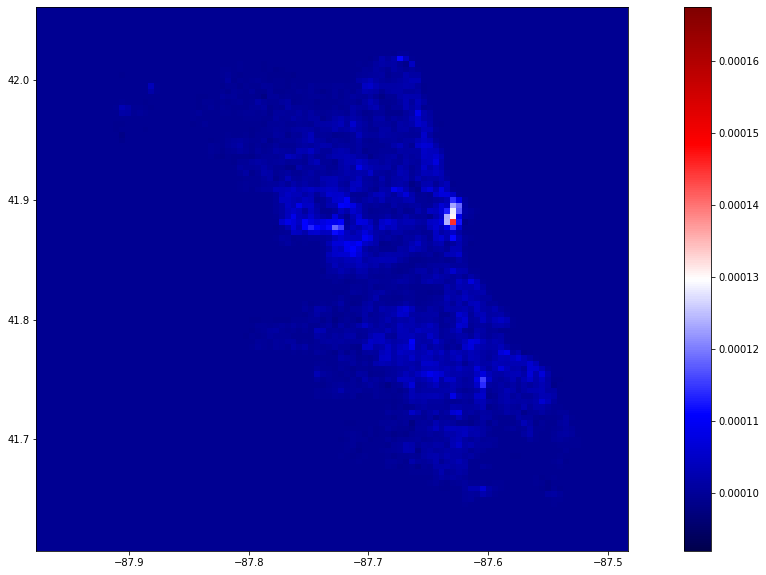

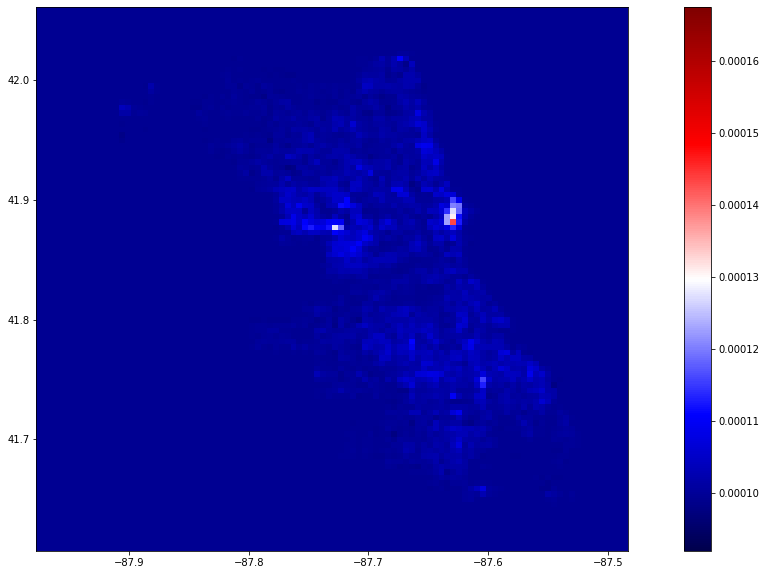

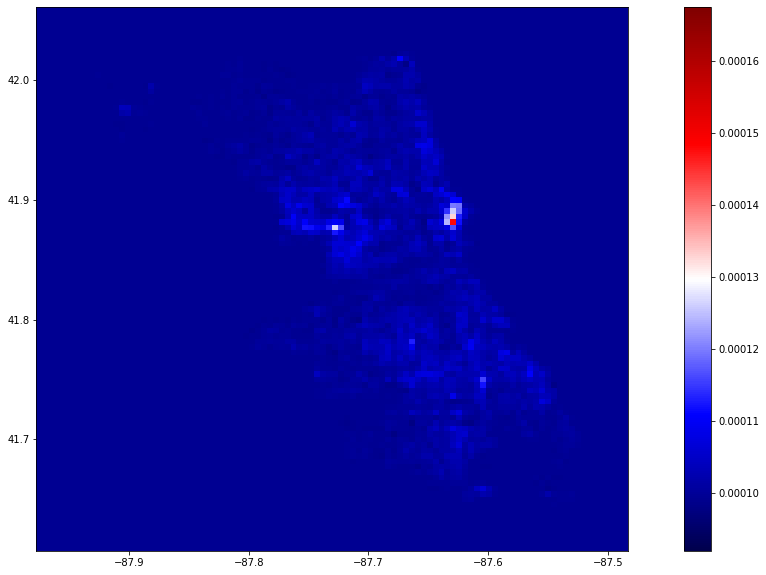

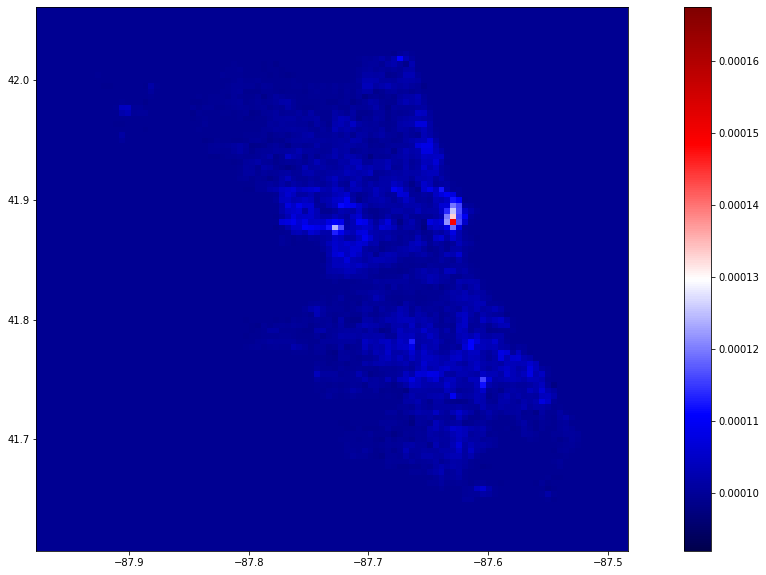

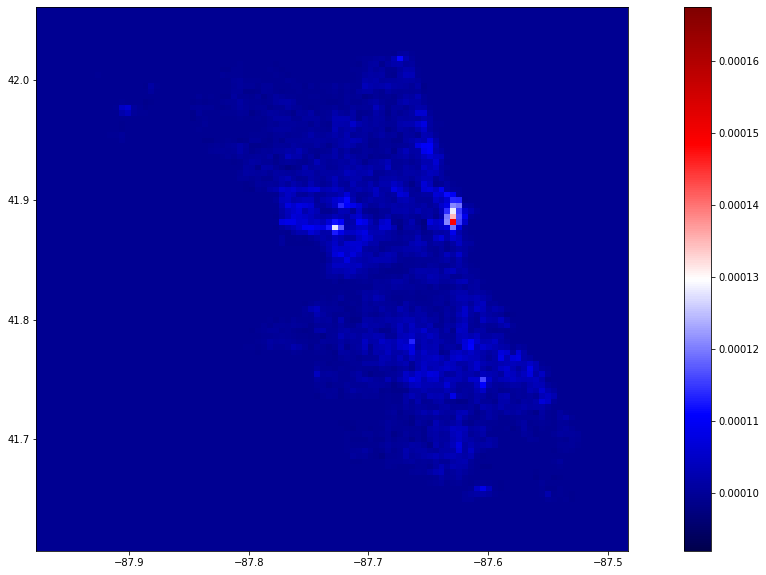

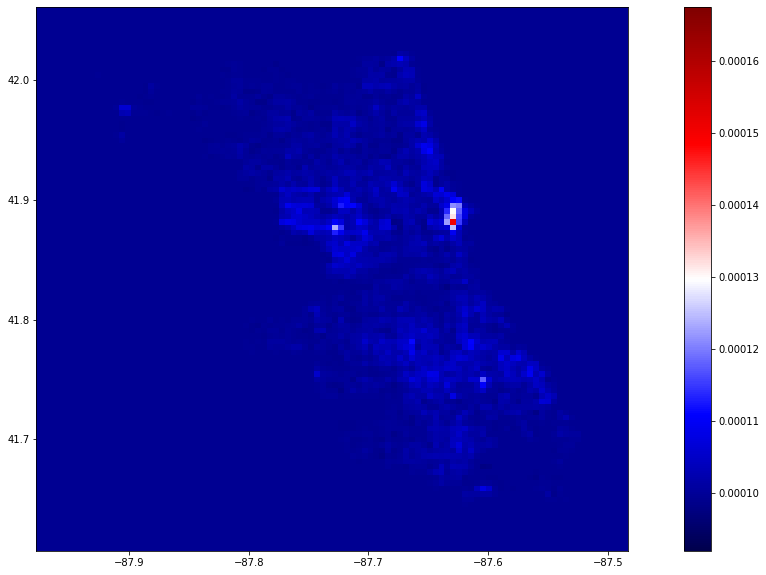

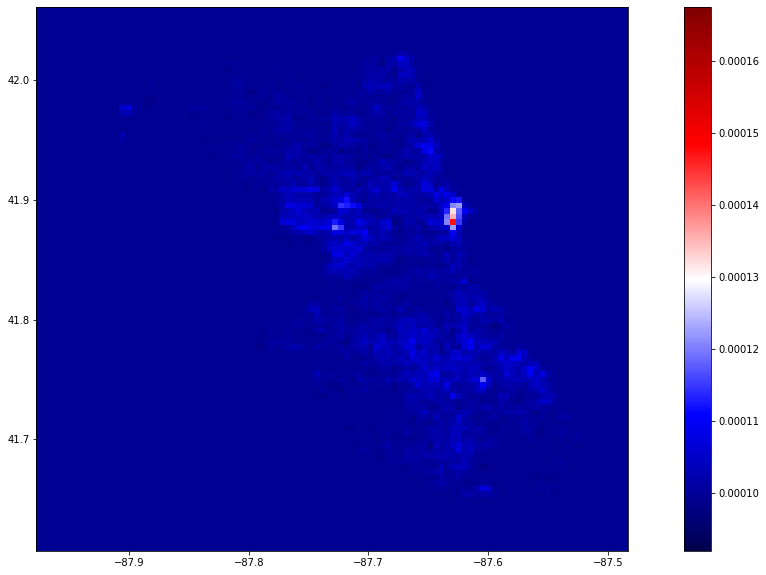

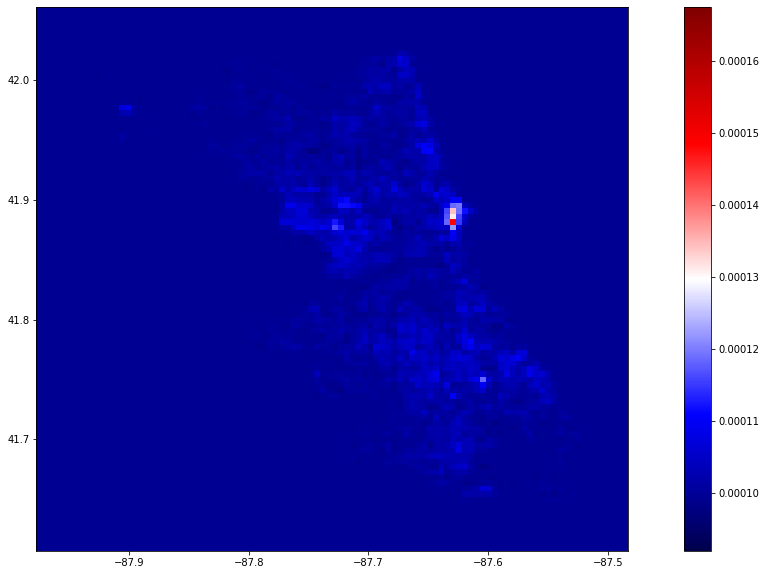

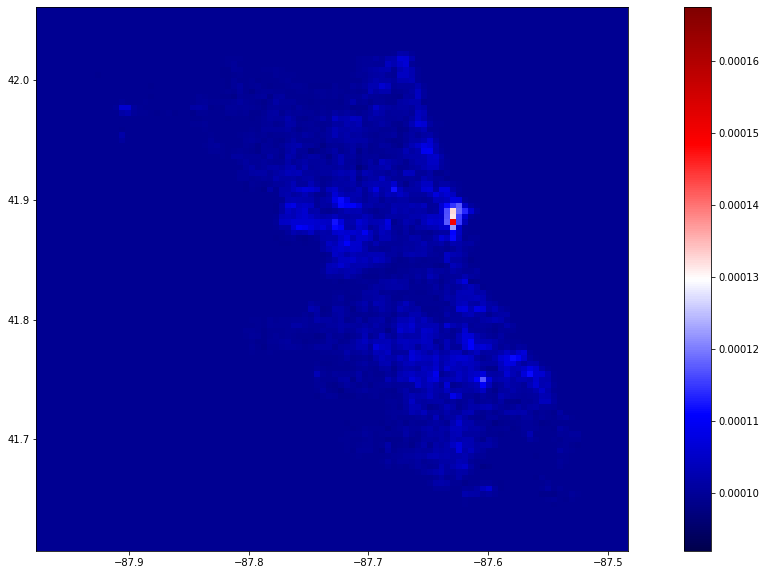

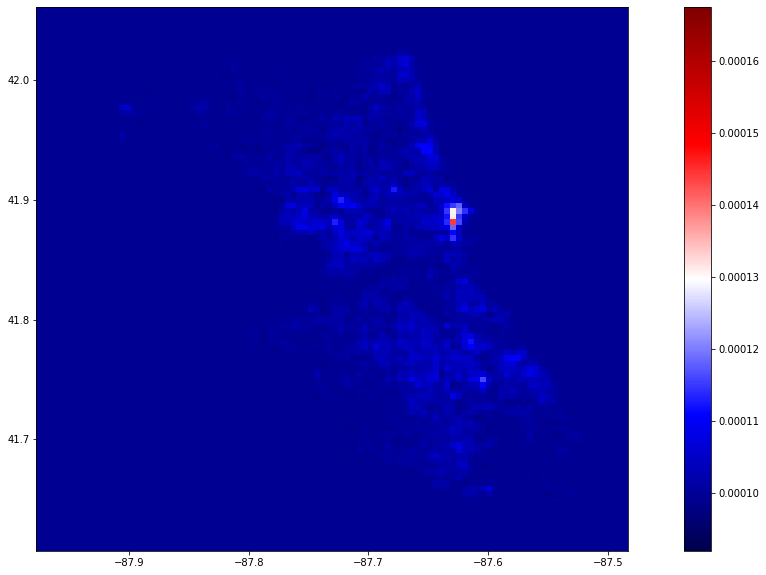

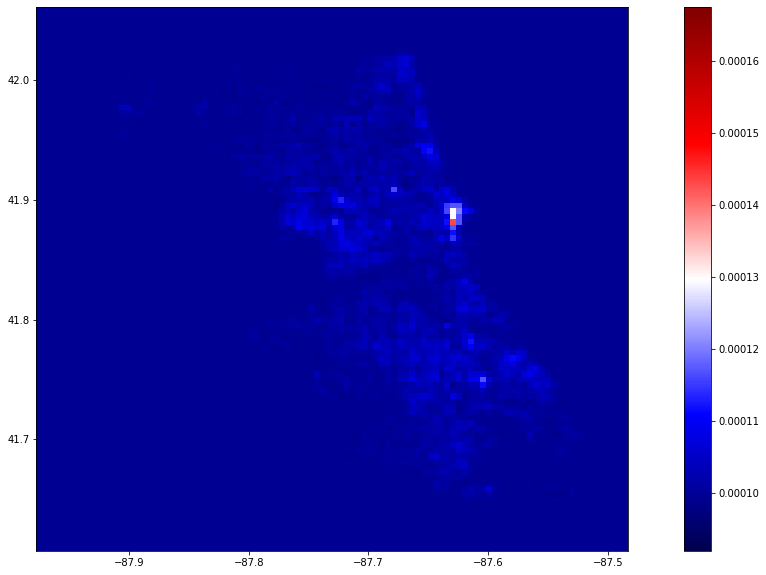

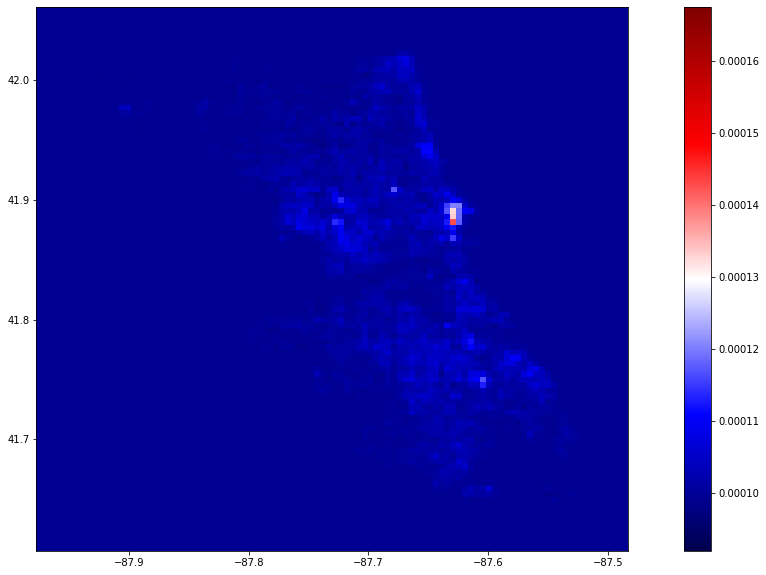

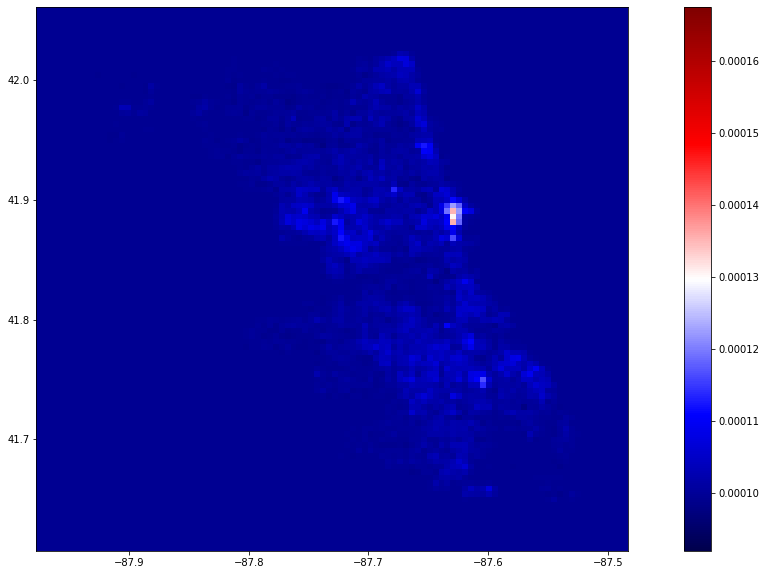

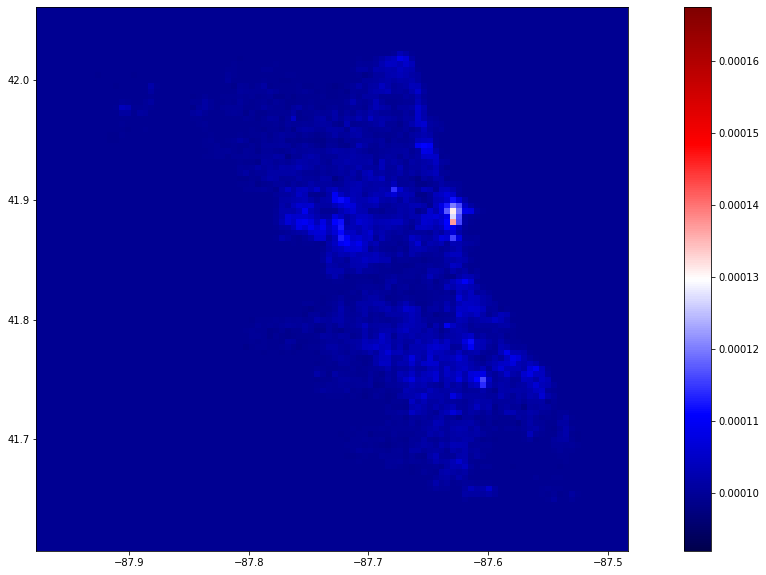

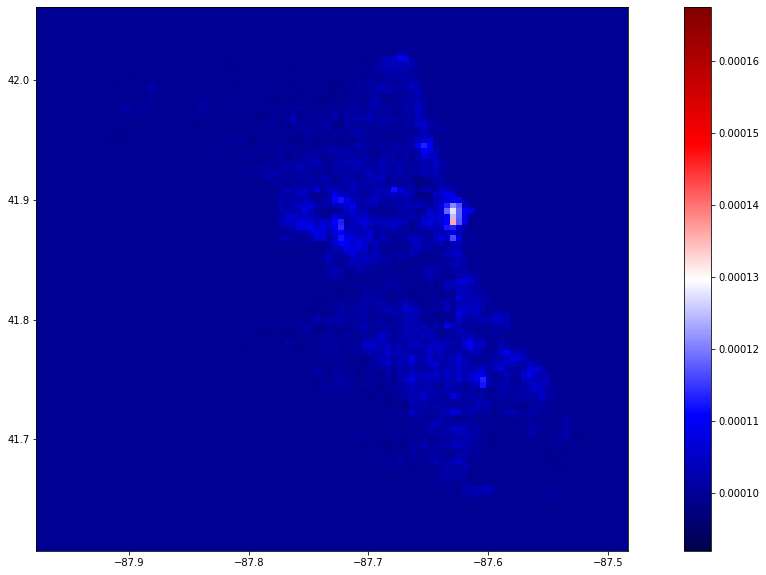

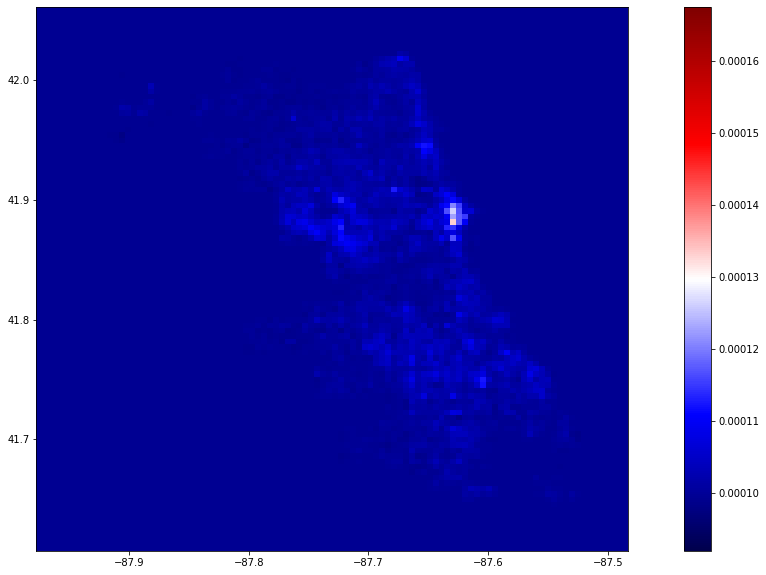

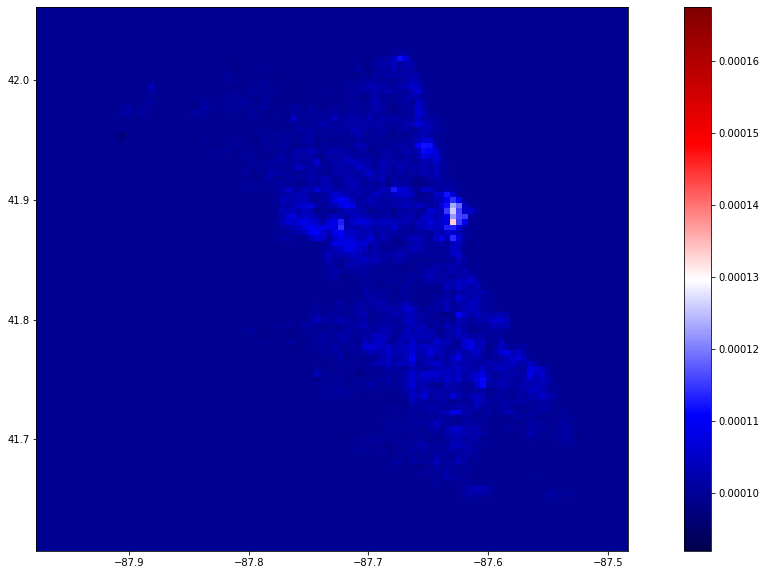

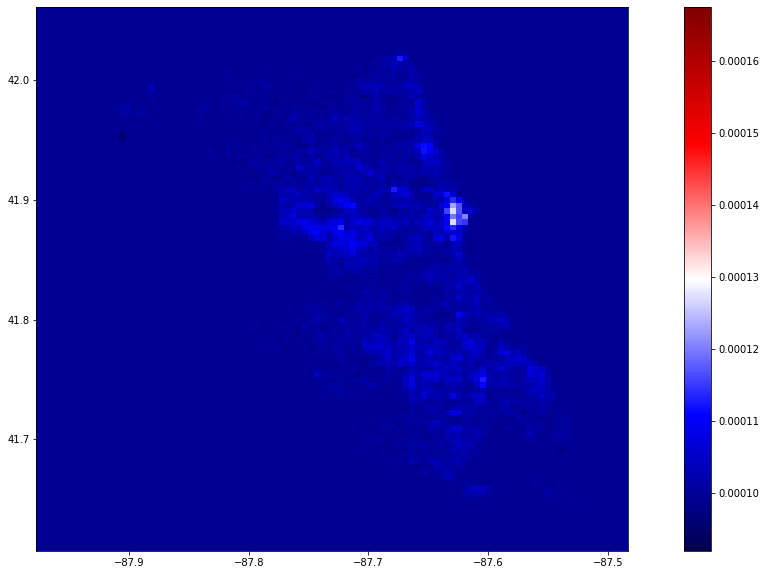

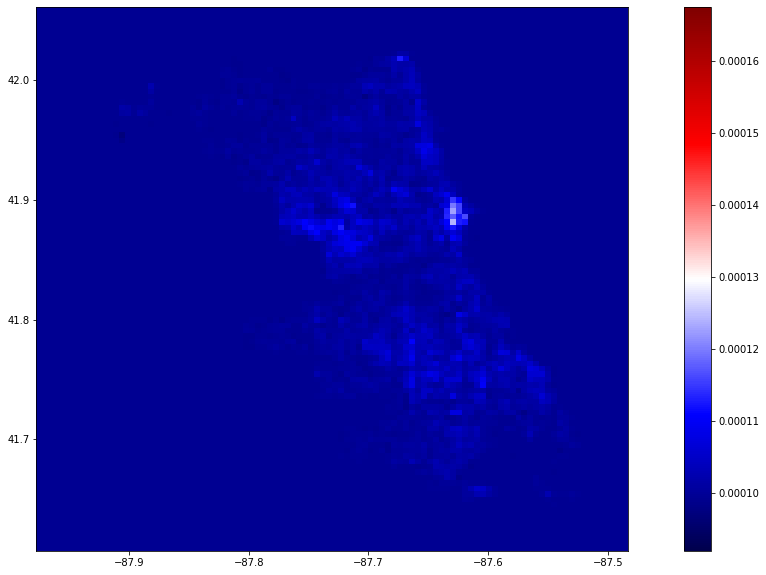

In [41]:
vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

In [44]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

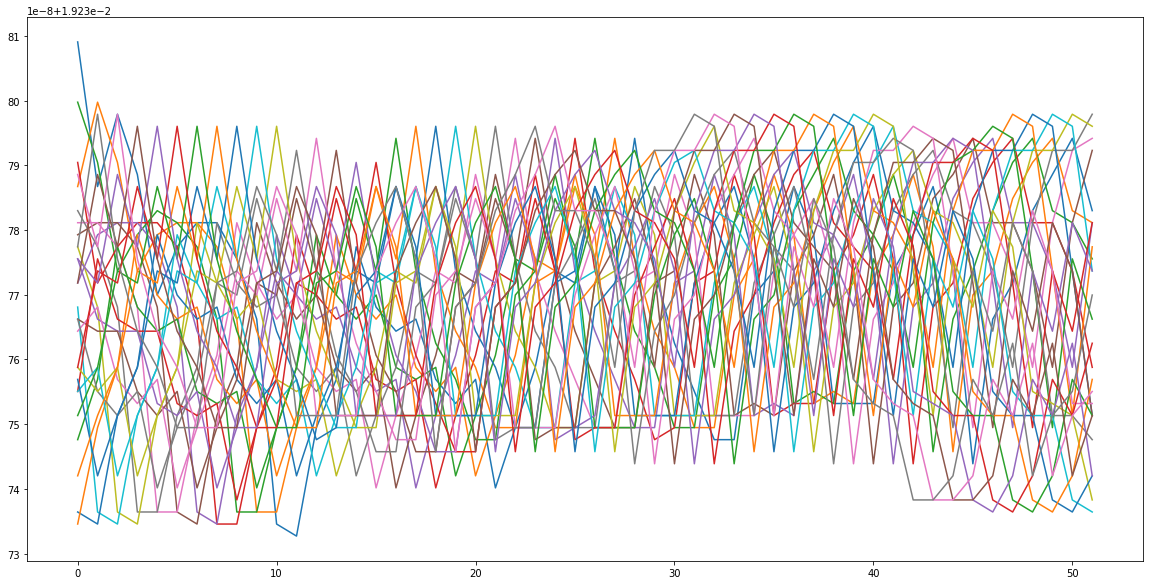

In [45]:
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## 2 Headed: Attention Pixel + Attention Timestep 

In [83]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

timeDist2 = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(100), name="compressor")(timeDist2)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
attention2 = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer

merge = Concatenate()([attention1, attention2])

attended_Dense_out = TimeDistributed(Dense(50, activation='relu'))(merge)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_20 (TimeDistri (None, 52, 10000)    0           input_9[0][0]                    
__________________________________________________________________________________________________
permute_24 (Permute)            (None, 10000, 52)    0           time_distributed_20[0][0]        
__________________________________________________________________________________________________
time_distributed_21 (TimeDistri (None, 52, 10000)    0           input_9[0][0]                    
_________________________________________________

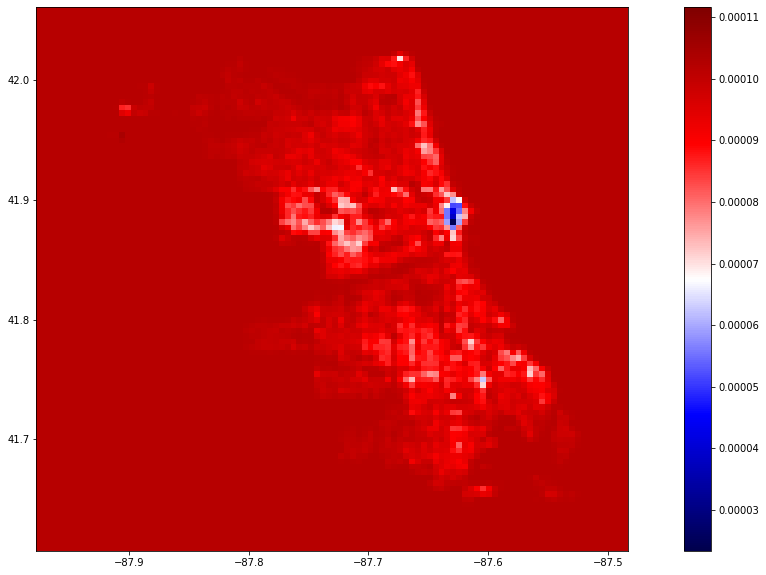

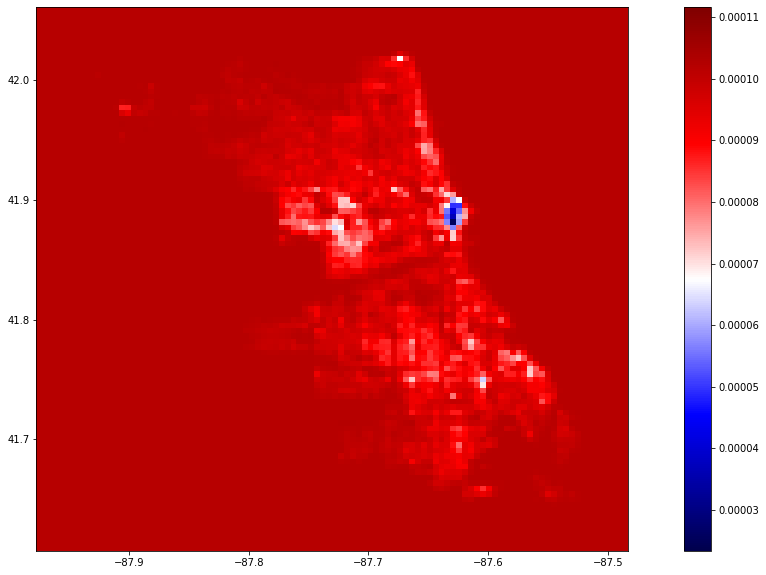

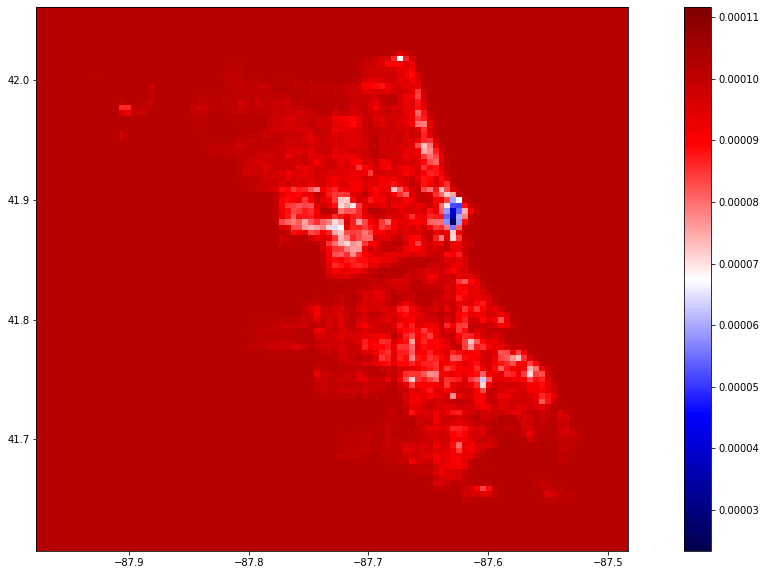

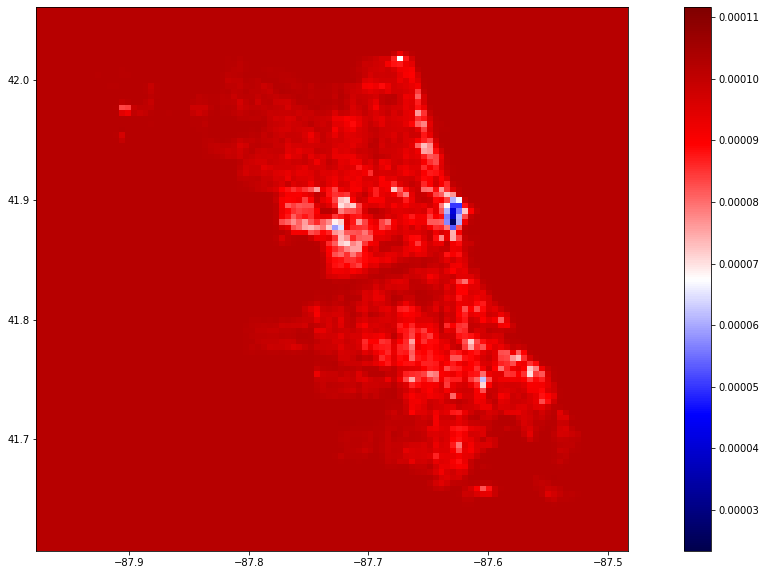

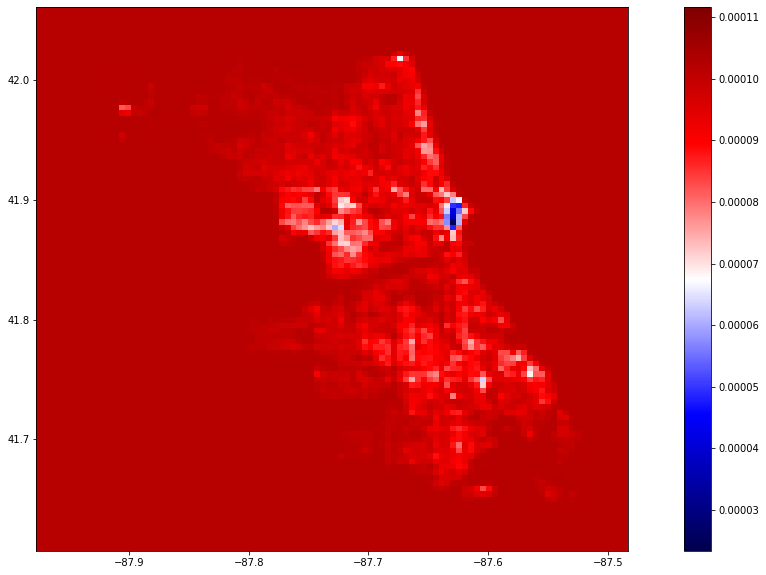

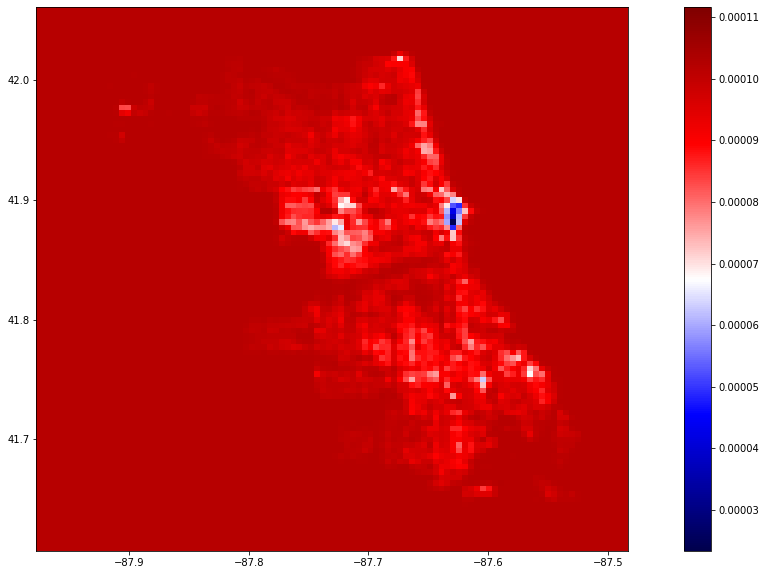

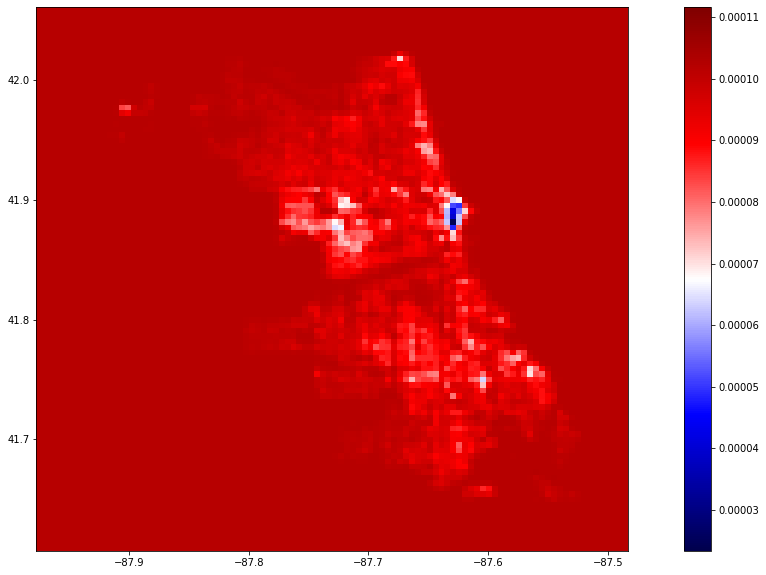

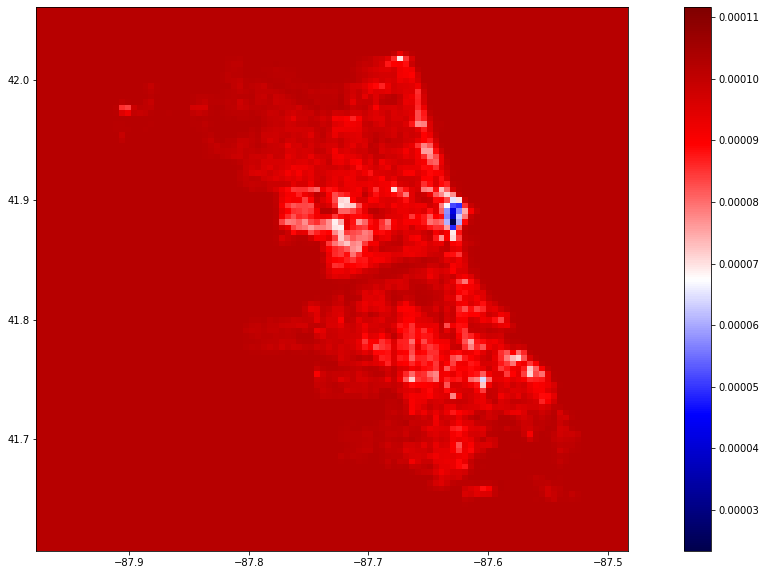

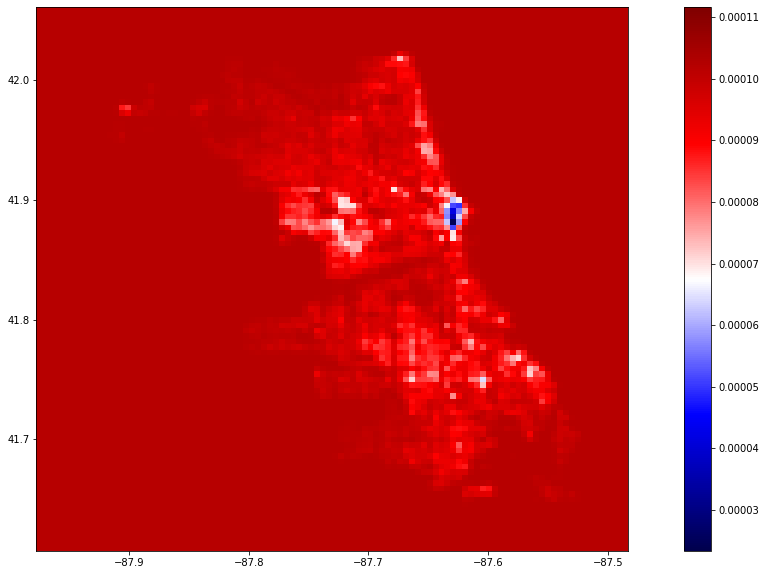

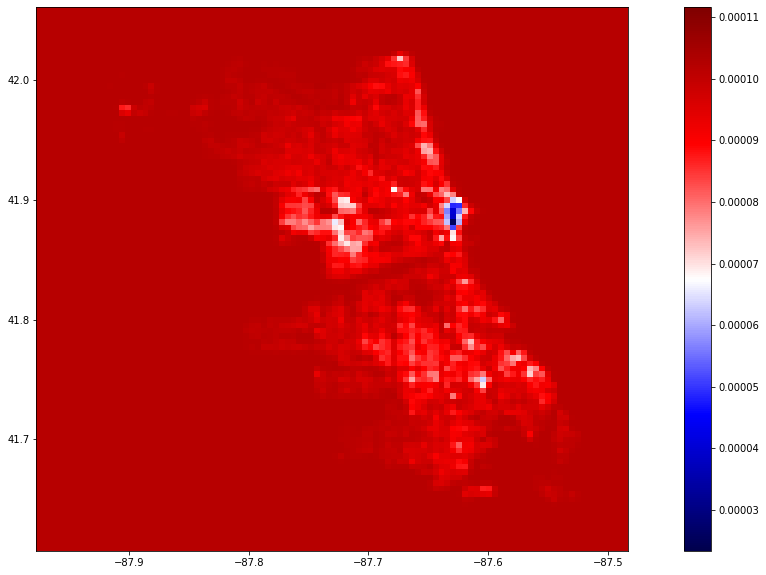

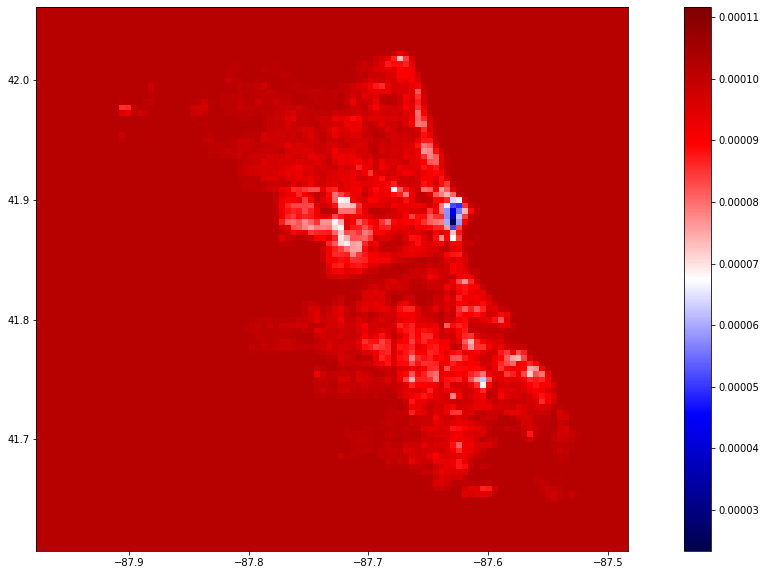

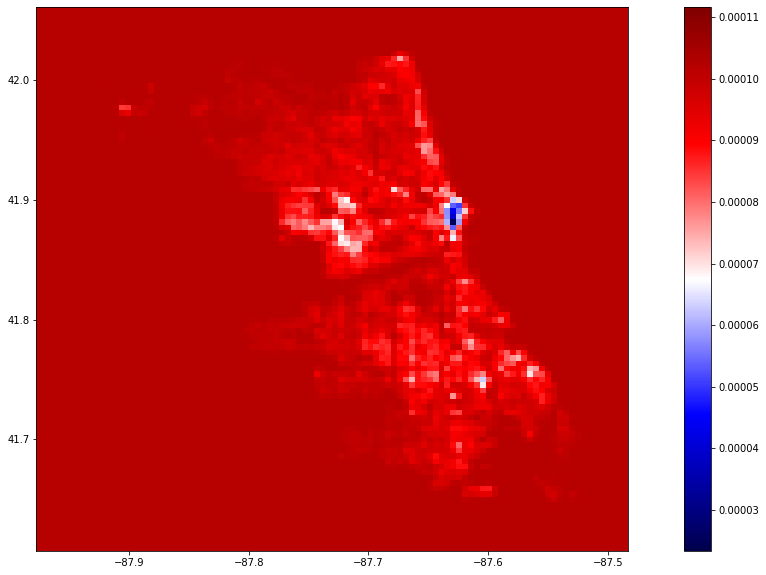

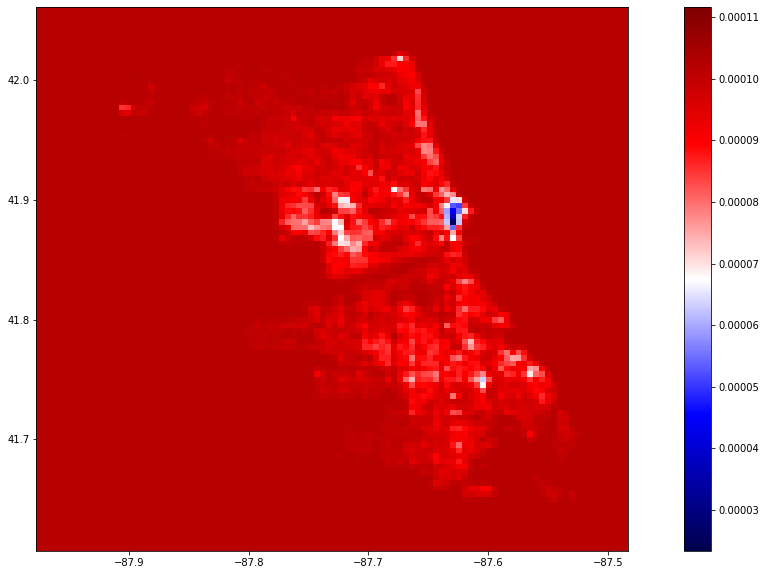

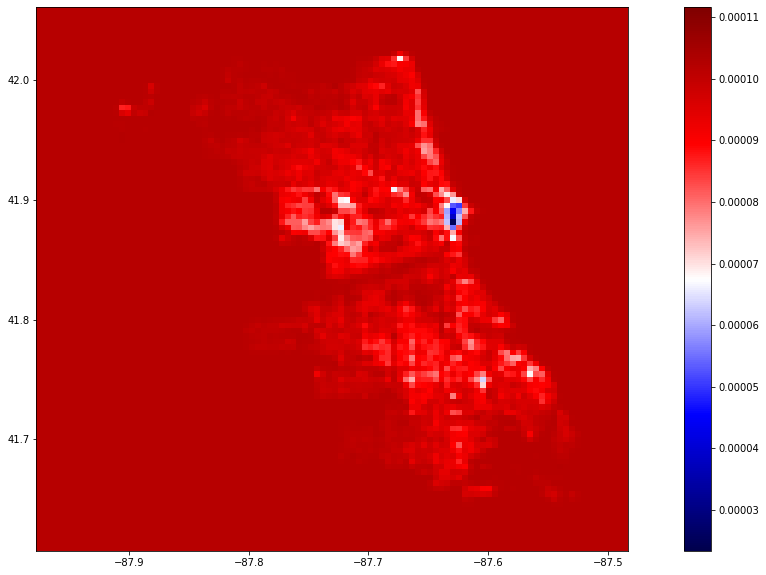

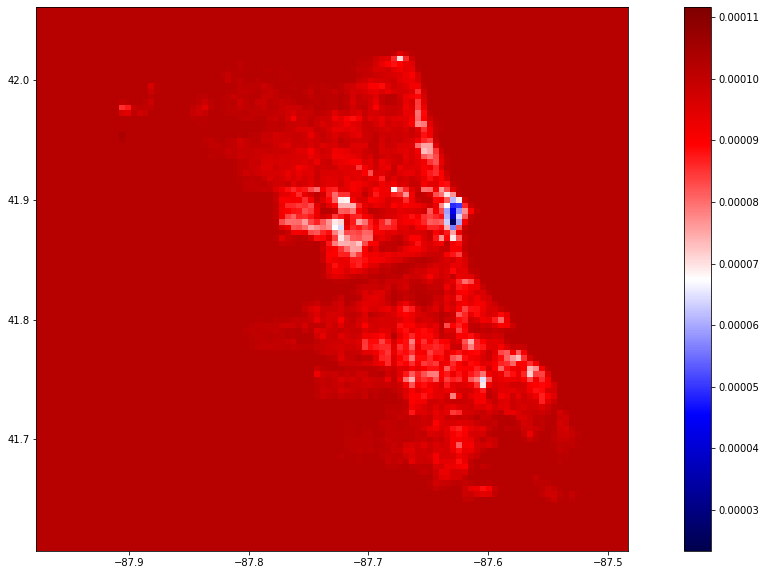

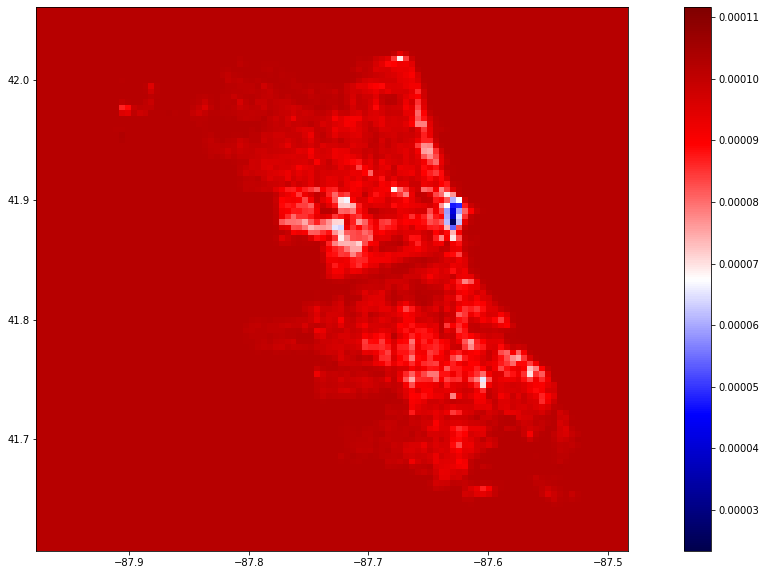

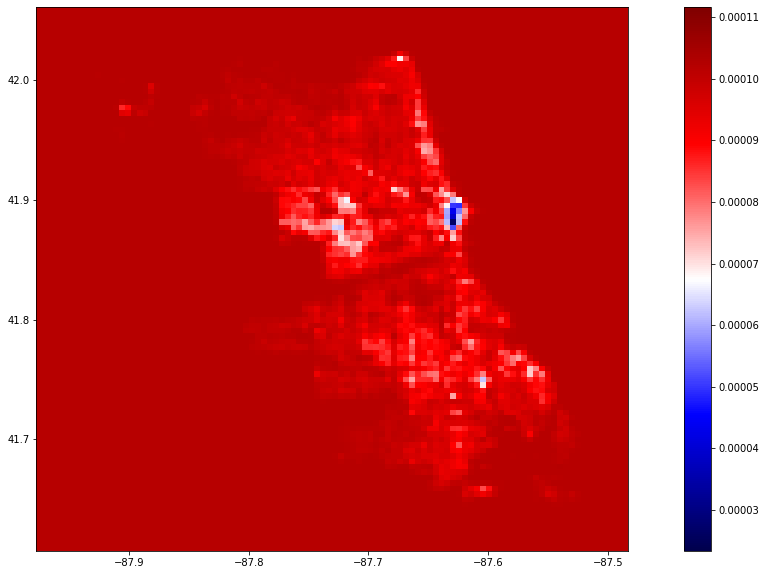

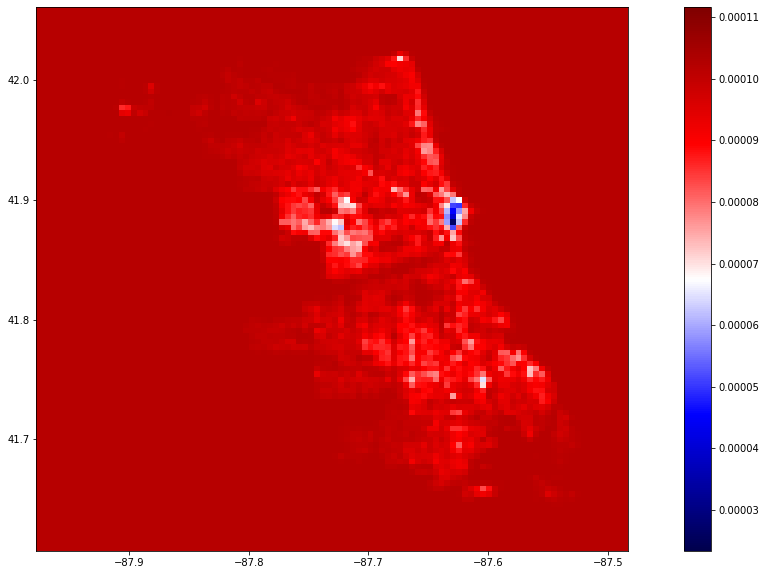

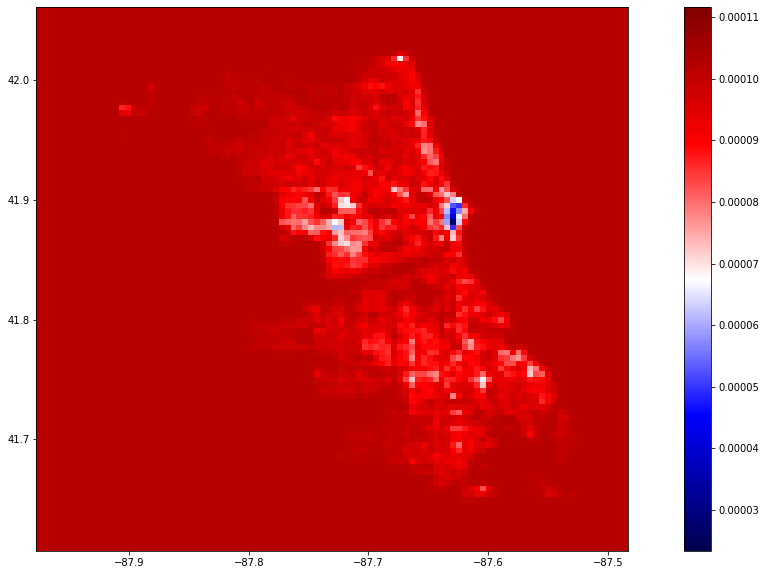

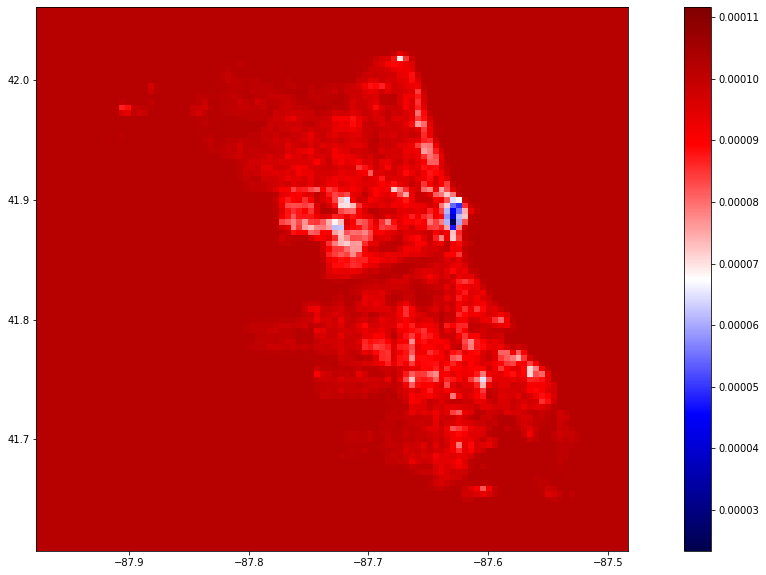

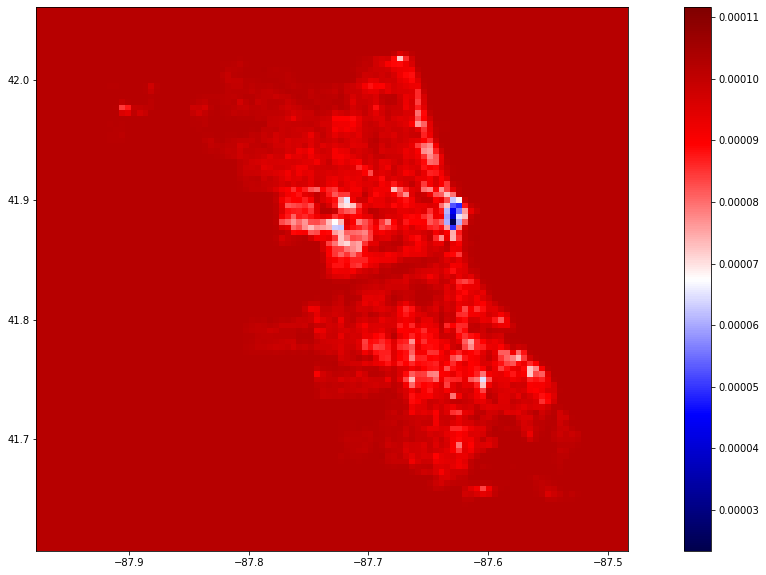

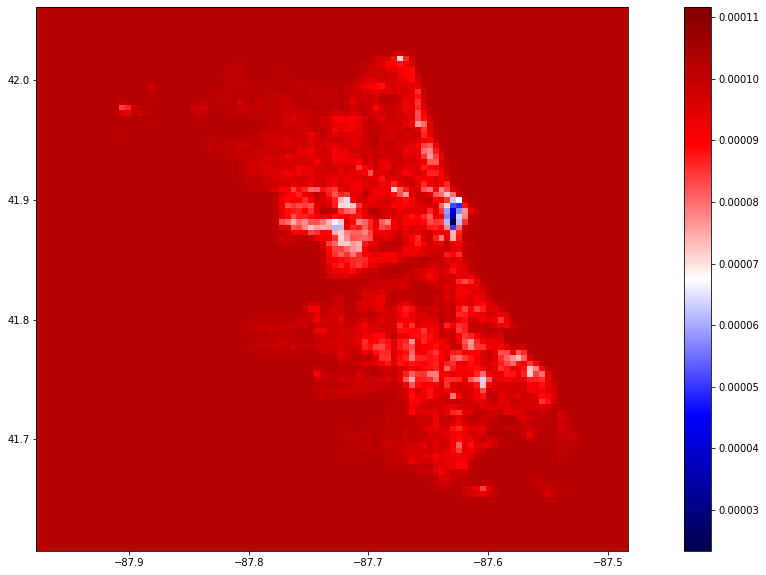

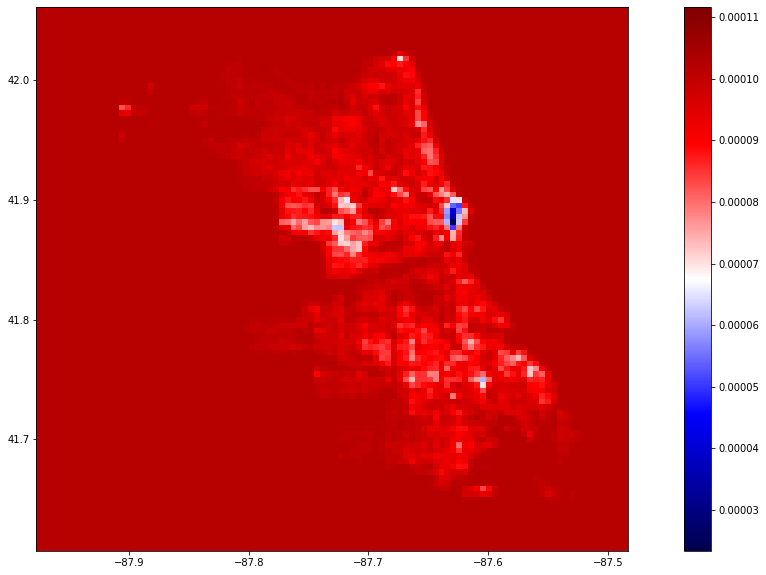

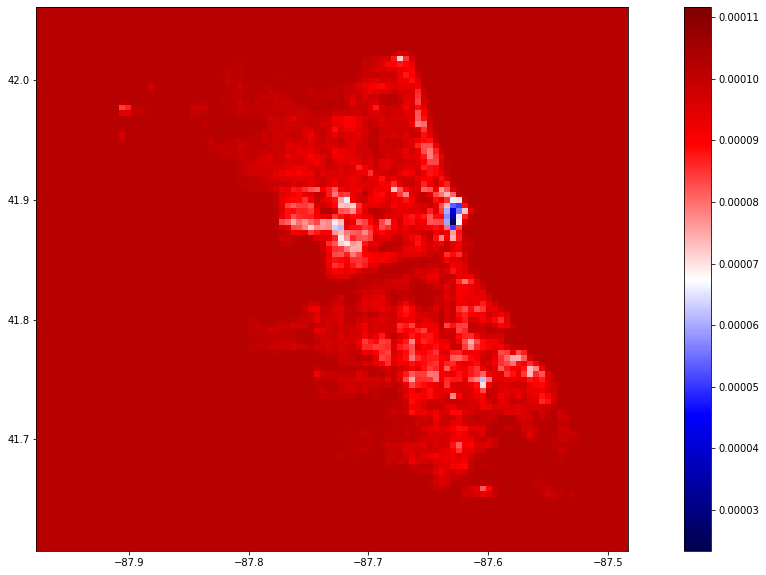

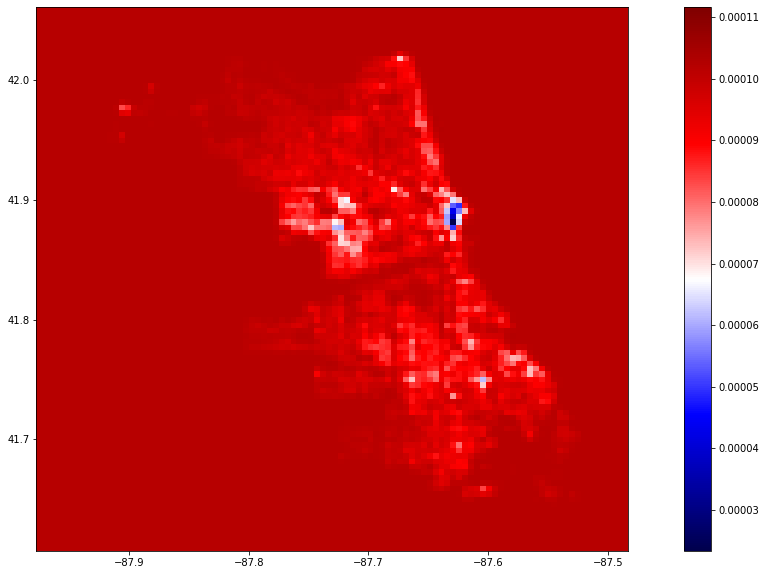

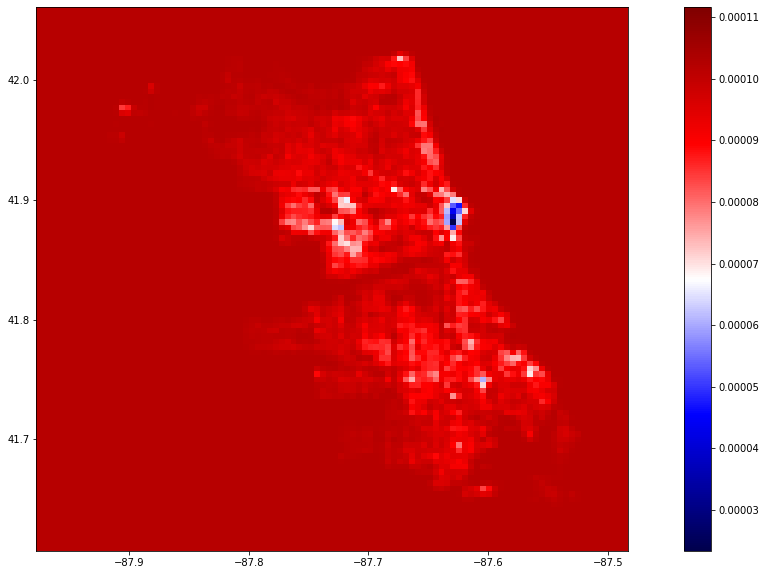

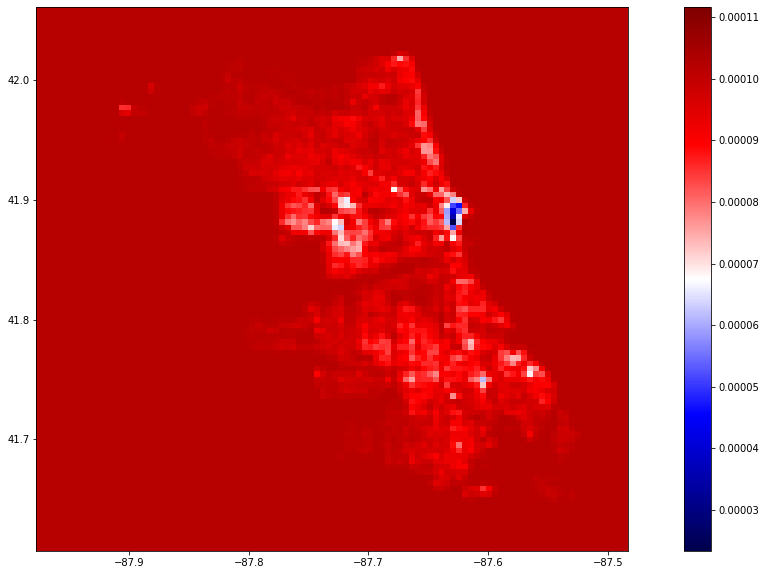

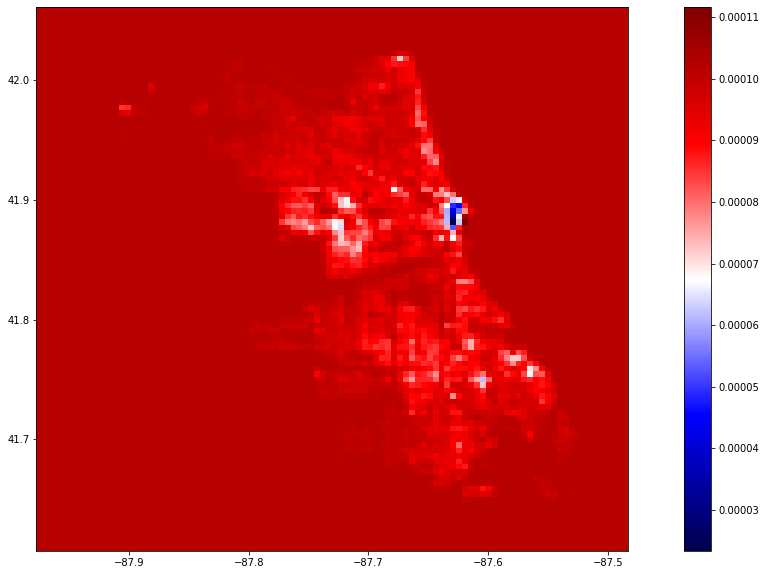

In [77]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

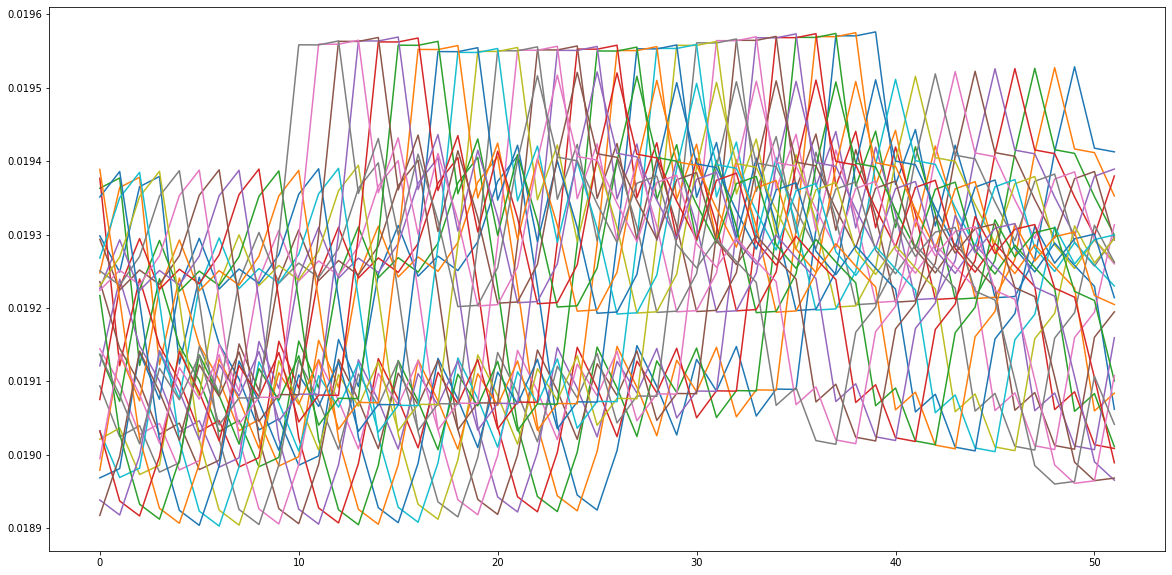

In [117]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## Run fit on any of the previous model here

In [90]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=1, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "2DCNN_LTSM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_42 (TimeDistri (None, 52, 100, 100, 40          input_13[0][0]                   
__________________________________________________________________________________________________
time_distributed_43 (TimeDistri (None, 52, 100, 100, 420         time_distributed_42[0][0]        
__________________________________________________________________________________________________
time_distributed_44 (TimeDistri (None, 52, 50, 50, 2 0           time_distributed_43[0][0]        
_________________________________________________________________________________________

87/88 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00012: val_loss improved from 0.00181 to 0.00179, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-183444_model.hdf5
88/88 [==============================] - 4s 45ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 13/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00013: val_loss improved from 0.00179 to 0.00179, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-183444_model.hdf5
88/88 [==============================] - 4s 45ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 14/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00014: val_loss did not improve from 0

Epoch 36/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00036: val_loss did not improve from 0.00174
88/88 [==============================] - 4s 42ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 37/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00037: val_loss did not improve from 0.00174
88/88 [==============================] - 4s 42ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 38/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00038: val_loss did not improve from 0.00174
88/88 [==============================] - 4s 44ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 39/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00039: val_loss did not improve from 0.00174
88/88 [==============================] - 4s 44ms/sample - loss

Epoch 66/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00066: val_loss did not improve from 0.00174
88/88 [==============================] - 3s 40ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 67/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00067: val_loss did not improve from 0.00174
88/88 [==============================] - 4s 41ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 68/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00068: val_loss did not improve from 0.00174
88/88 [==============================] - 3s 39ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 69/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00069: val_loss did not improve from 0.00174
88/88 [==============================] - 3s 39ms/sample - loss

Epoch 96/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00096: val_loss did not improve from 0.00173
88/88 [==============================] - 3s 40ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 97/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00097: val_loss did not improve from 0.00173
88/88 [==============================] - 4s 42ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 98/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00098: val_loss did not improve from 0.00173
88/88 [==============================] - 4s 42ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 99/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00099: val_loss did not improve from 0.00173
88/88 [==============================] - 3s 40ms/sample - loss

Epoch 127/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00127: val_loss did not improve from 0.00173
88/88 [==============================] - 4s 45ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 128/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00128: val_loss did not improve from 0.00173
88/88 [==============================] - 4s 45ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 129/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00129: val_loss did not improve from 0.00173
88/88 [==============================] - 4s 40ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 130/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00130: val_loss improved from 0.00173 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/C

87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00157: val_loss improved from 0.00173 to 0.00172, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-183444_model.hdf5
88/88 [==============================] - 5s 51ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 158/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00158: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 44ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 159/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00159: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 40ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 160/1000
86/88 [=====================

87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00187: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 43ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 188/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00188: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 44ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 189/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00189: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 41ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 190/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00190: val_loss did not improve from 0.00172
88/88 [==============================] - 3s 39ms/sample - loss: 0.0016 - 

87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00217: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 41ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 218/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00218: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 42ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 219/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00219: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 42ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 220/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00220: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 41ms/sample - loss: 0.0016 - 

87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00247: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 42ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 248/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00248: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 41ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 249/1000
86/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00249: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 40ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 250/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00250: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 40ms/sample - loss: 0.0016 - 

87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00277: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 43ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 278/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00278: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 42ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 279/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00279: val_loss did not improve from 0.00172
88/88 [==============================] - 3s 40ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 280/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00280: val_loss did not improve from 0.00172
88/88 [==============================] - 4s 40ms/sample - loss: 0.0016 - 

Epoch 308/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00308: val_loss did not improve from 0.00172
88/88 [==============================] - 3s 39ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 309/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00309: val_loss did not improve from 0.00172
88/88 [==============================] - 3s 39ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 310/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00310: val_loss did not improve from 0.00172
88/88 [==============================] - 3s 39ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 311/1000
87/88 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00311: val_loss did not improve from 0.00172
88/88 [==============================] - 3s 39ms/sample - 

ResourceExhaustedError:  OOM when allocating tensor with shape[1456,20,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node 2DCNN_LTSM/time_distributed_42/conv2d_8/Conv2D (defined at <ipython-input-90-2cd95fe8bfc2>:40) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_762435]

Function call stack:
distributed_function


# Test Set accuracy

#### Flattened+Attention

In [54]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002142413, valid_loss=0.002142413053661585


#### Flattened+LSTM+Attention

In [48]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021439143, valid_loss=0.002143914345651865


#### FFT+Attention

In [104]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002143551, valid_loss=0.0021435508970171213


#### Attention on Attention

In [135]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021426608, valid_loss=0.0021426607854664326


# Validation Set:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016915

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016920

### Best FFT + Attention Heads on  TimeDistributed is at MAE of 0.0016920

## Best Pixel Attention + Time Distributed is at MAE of 0.00169077

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [56]:
Predict = model.predict(X_valid)

In [57]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

In [58]:
vmax, vmin = np.max(Predict),np.min(Predict)
vmax, vmin

(0.90123886, -0.0057265237)

In [59]:
dvmax, dvmin = np.max(np.abs(Predict-Y_valid)),np.min(np.abs(Predict-Y_valid))
dvmax, dvmin

(0.20142937565946034, 6.002654461177196e-11)

In [60]:
diff_max,diff_min = (dvmax , dvmin ) 
def scaleDiff(diff,diff_max,diff_min):
    return (diff - diff_min)/(diff_max - diff_min)

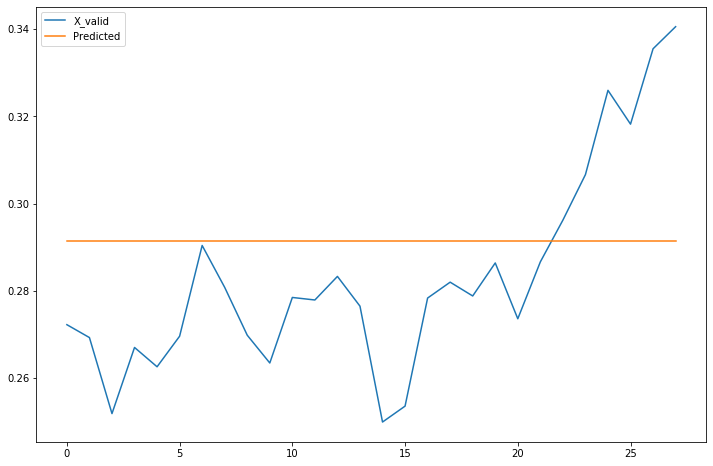

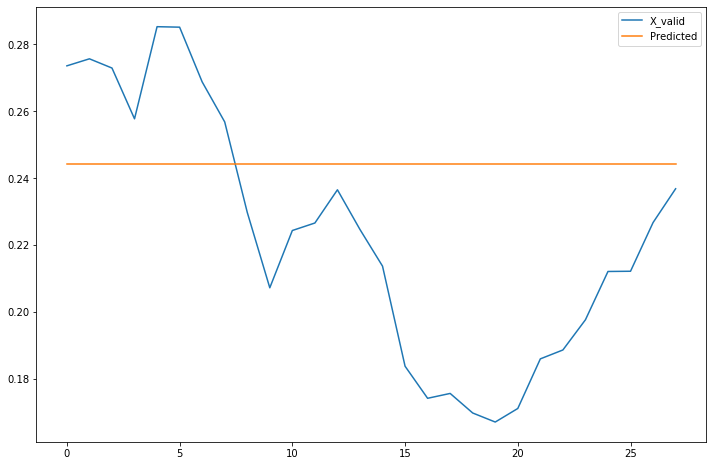

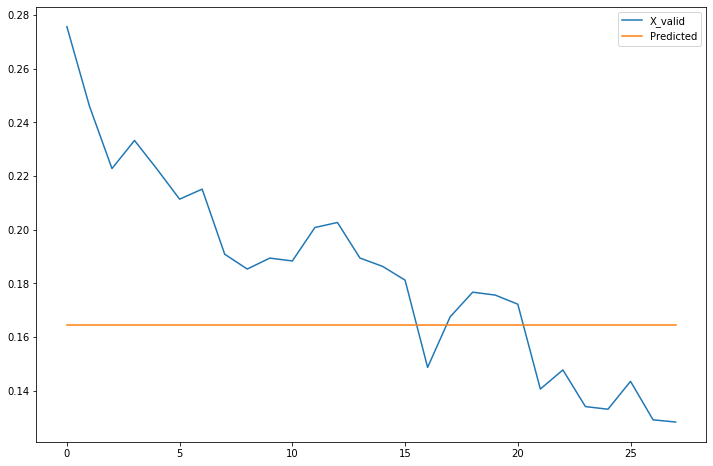

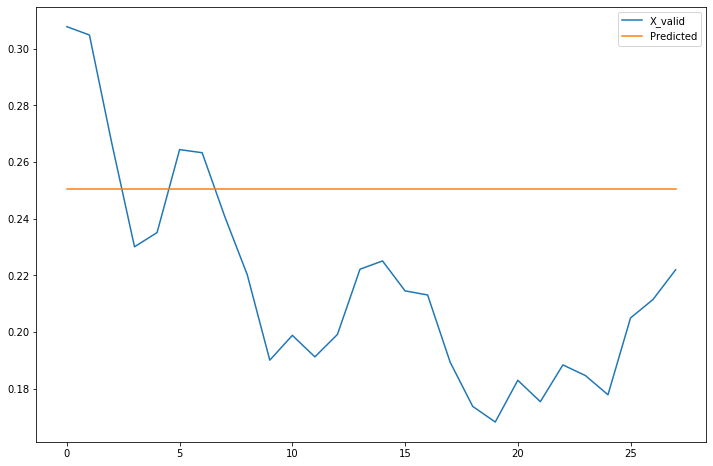

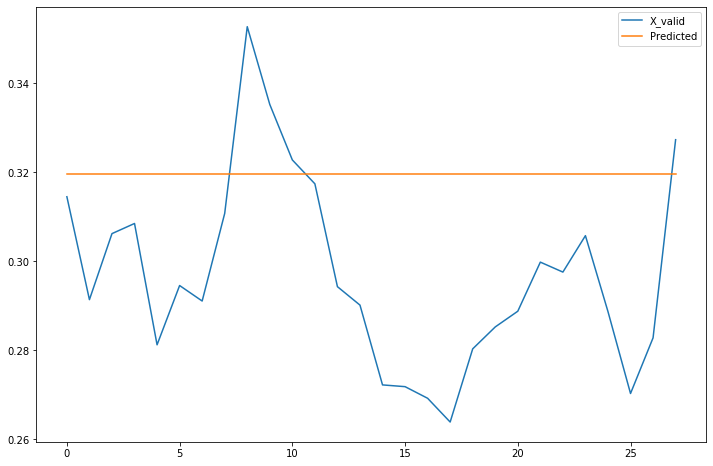

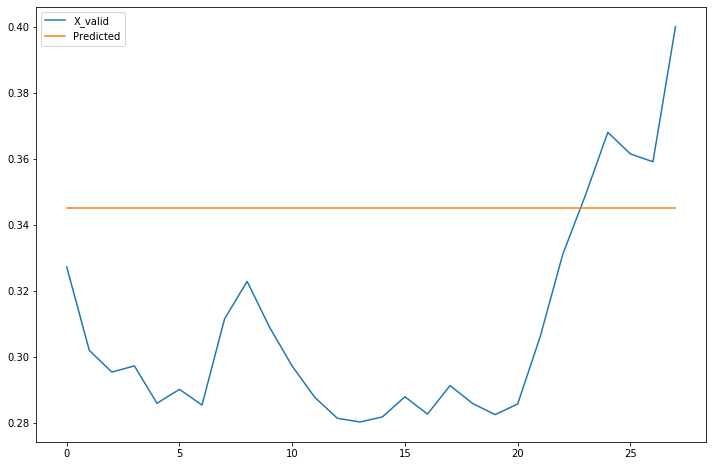

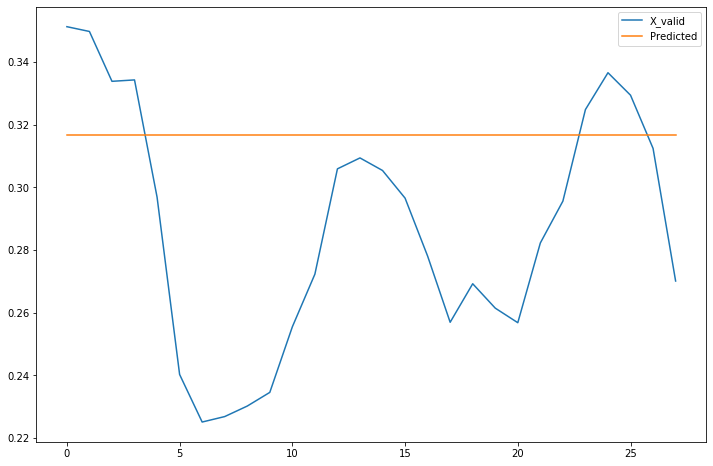

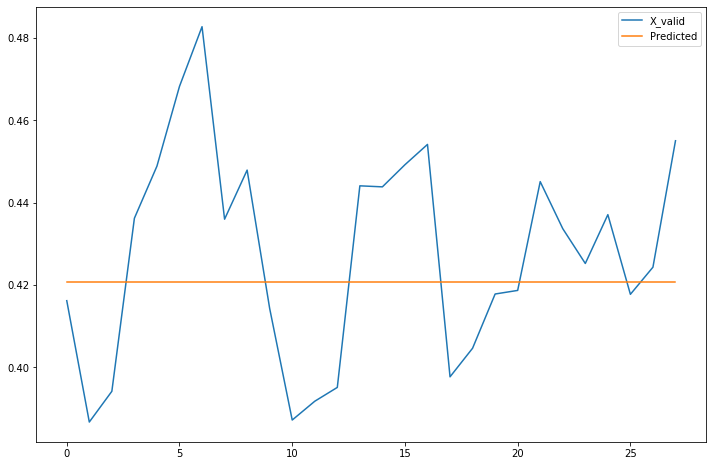

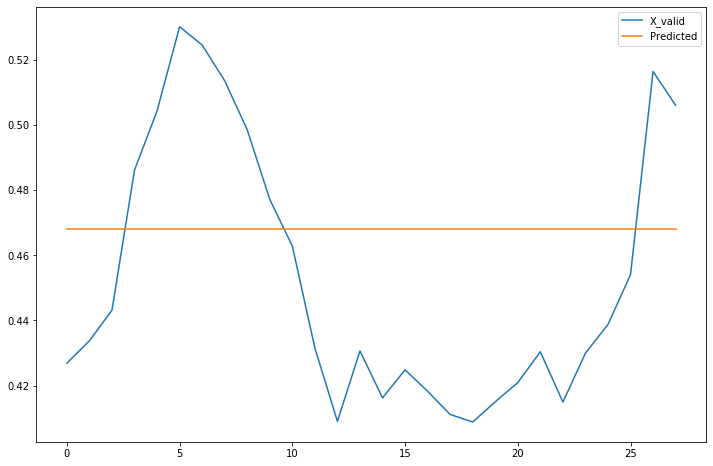

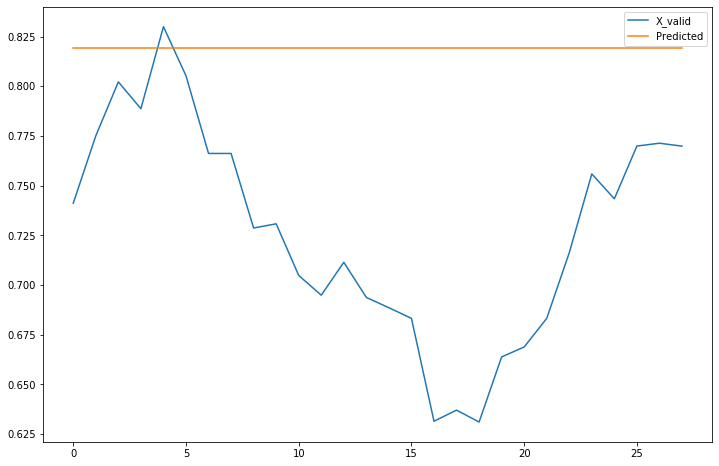

In [86]:
Predict = model.predict(X_valid)
for i in np.argsort(Y_valid)[:,-10:][0]:
    pd.DataFrame(np.transpose(np.vstack([Y_valid[:,i],Predict[:,i]])),columns=["X_valid","Predicted"]).plot(figsize=(12,8))

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

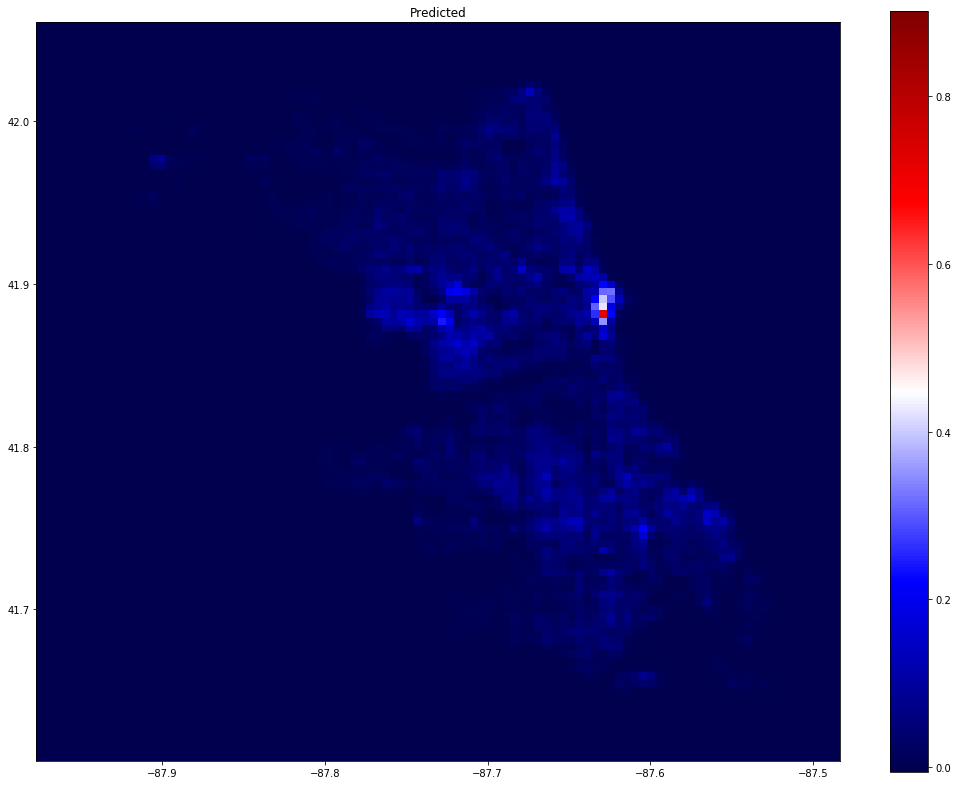

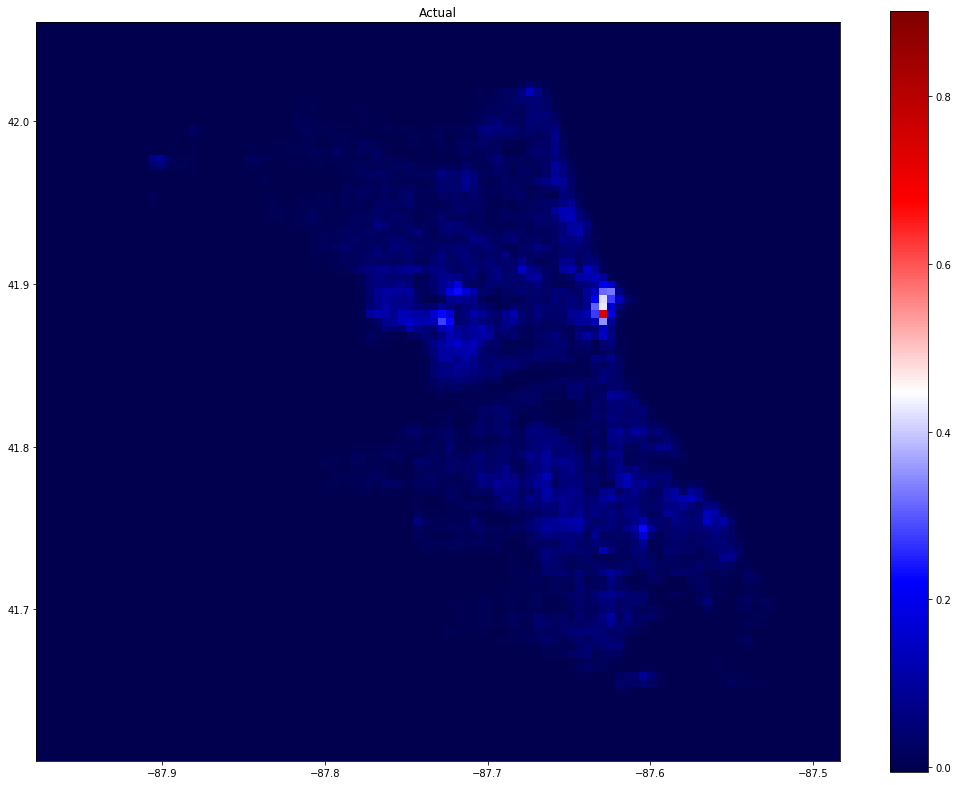

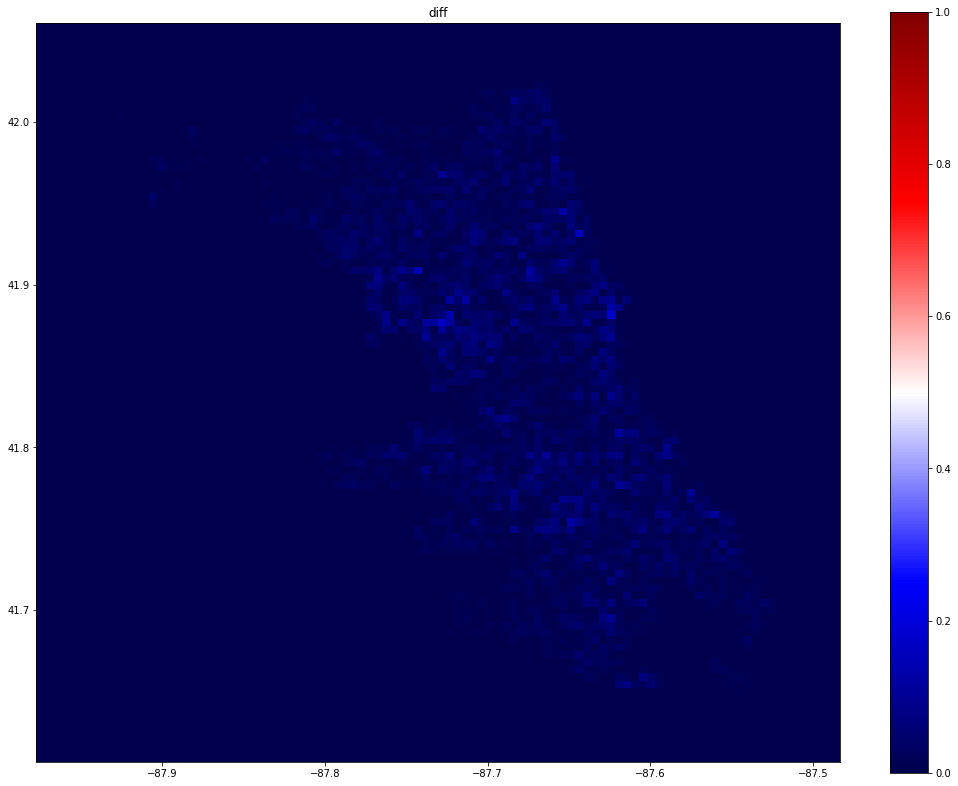

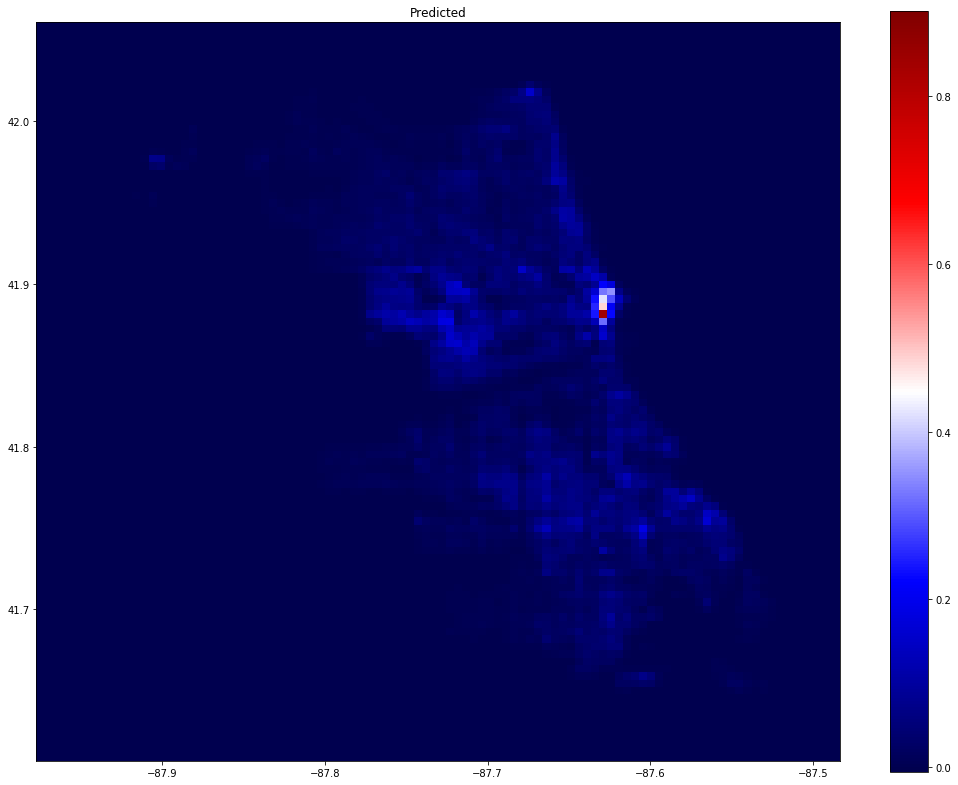

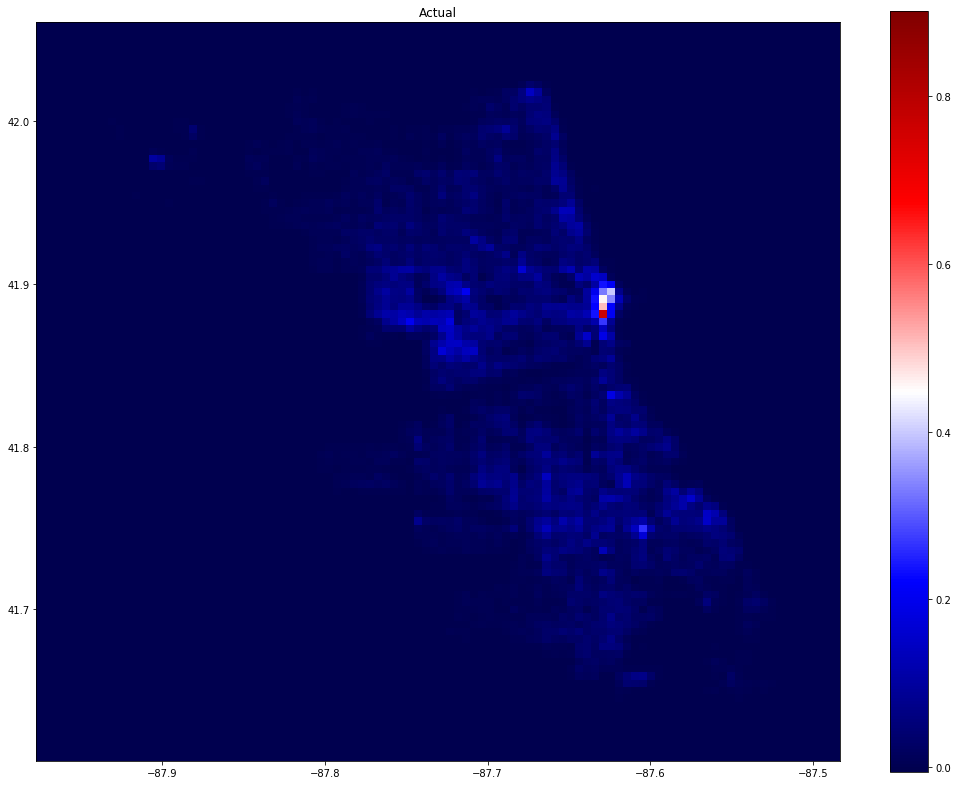

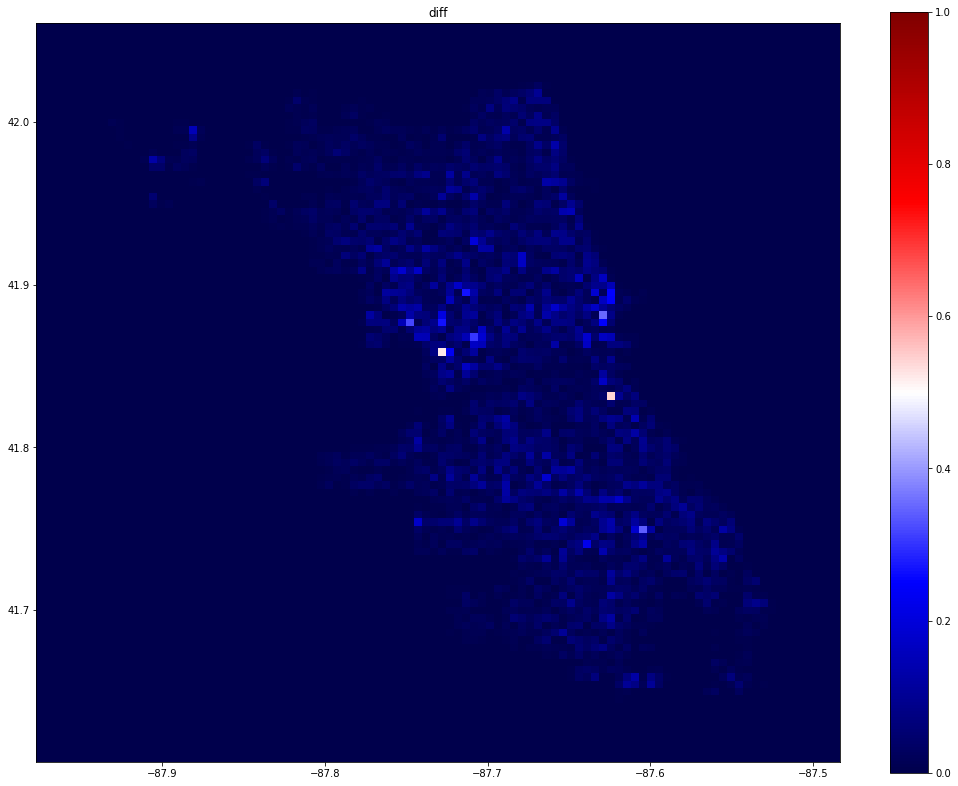

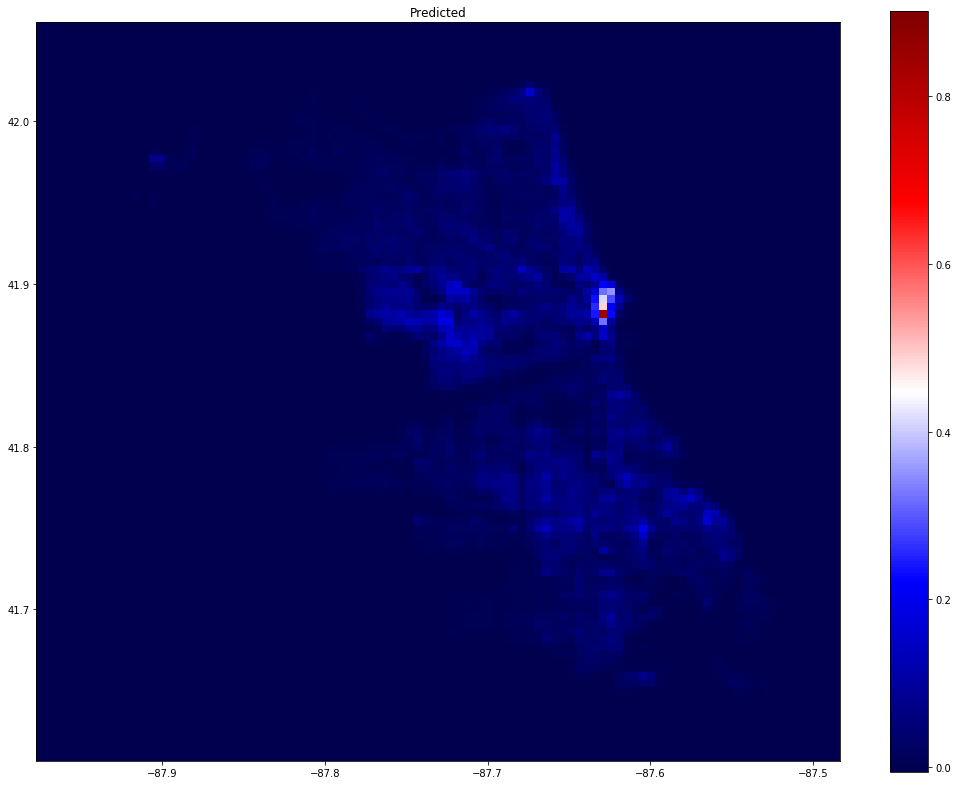

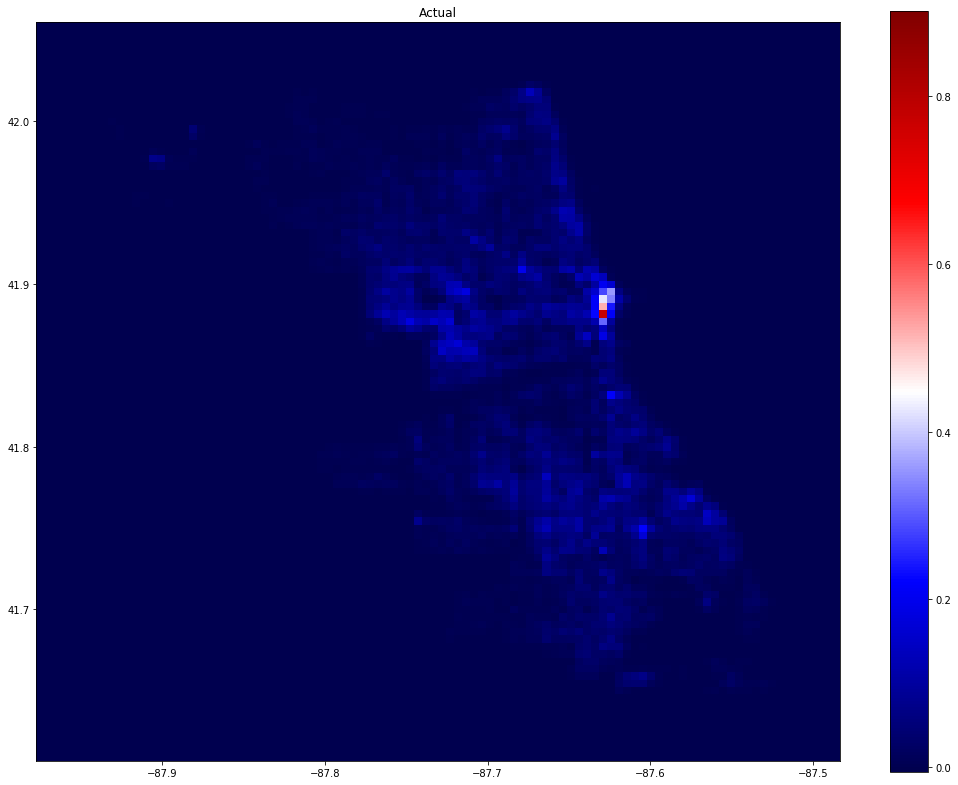

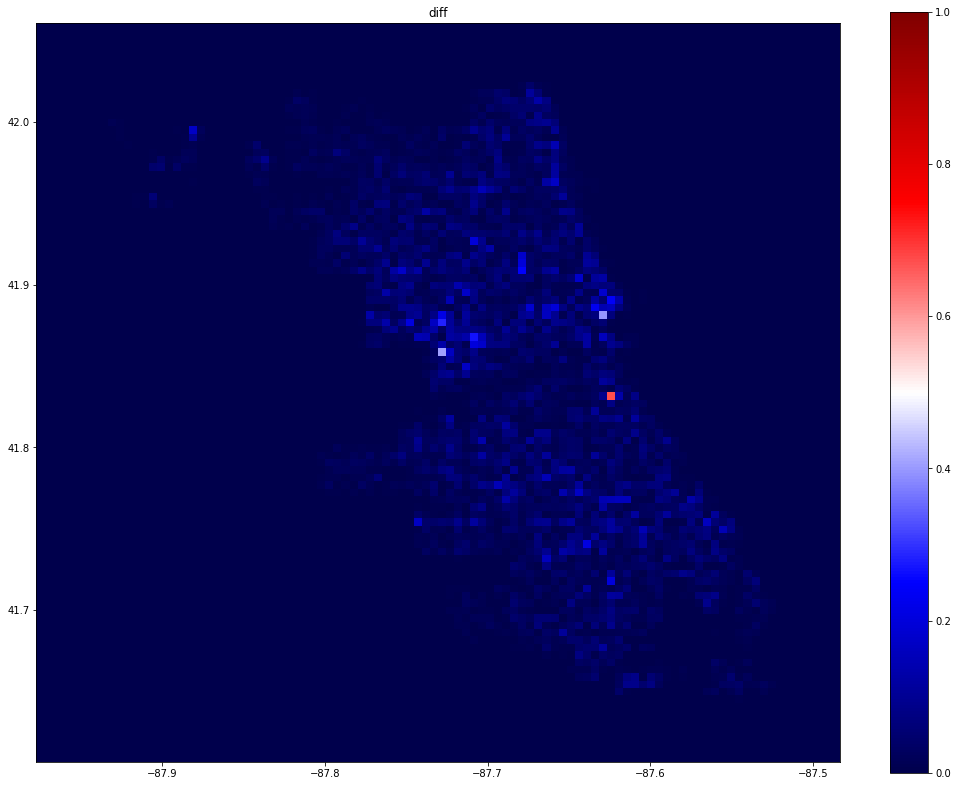

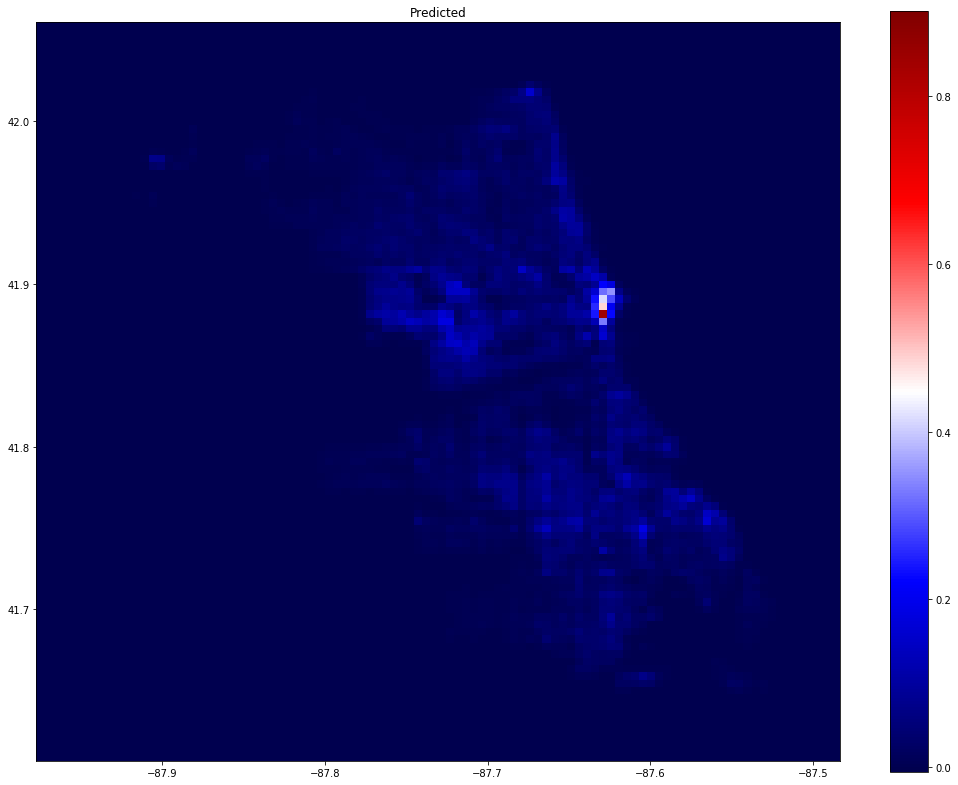

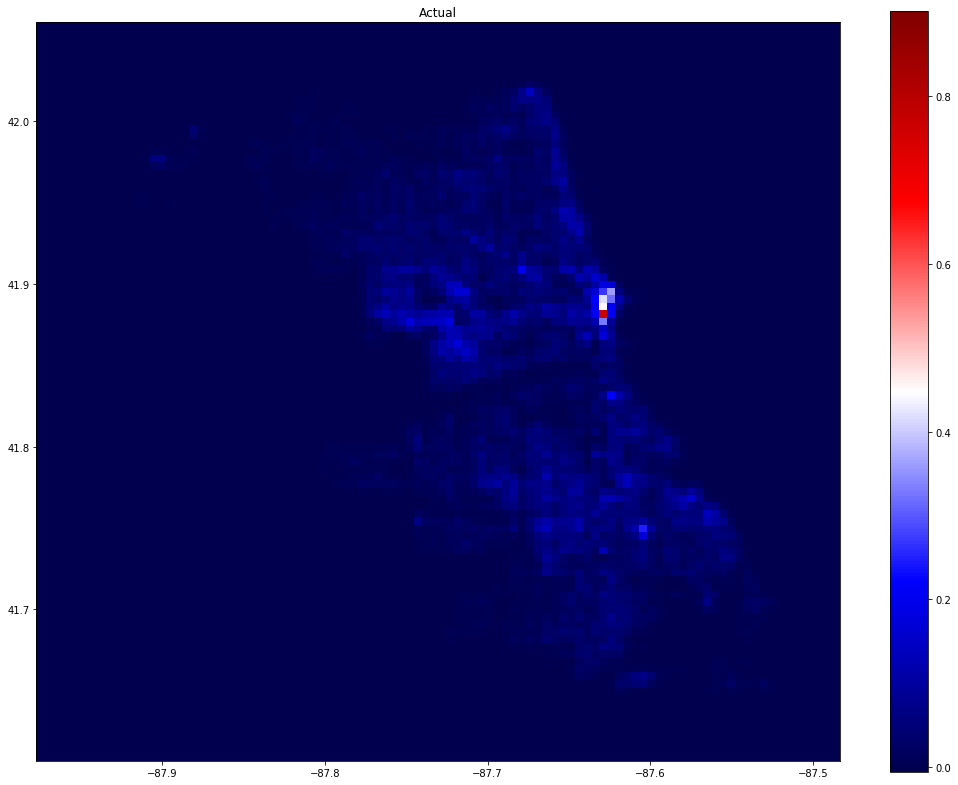

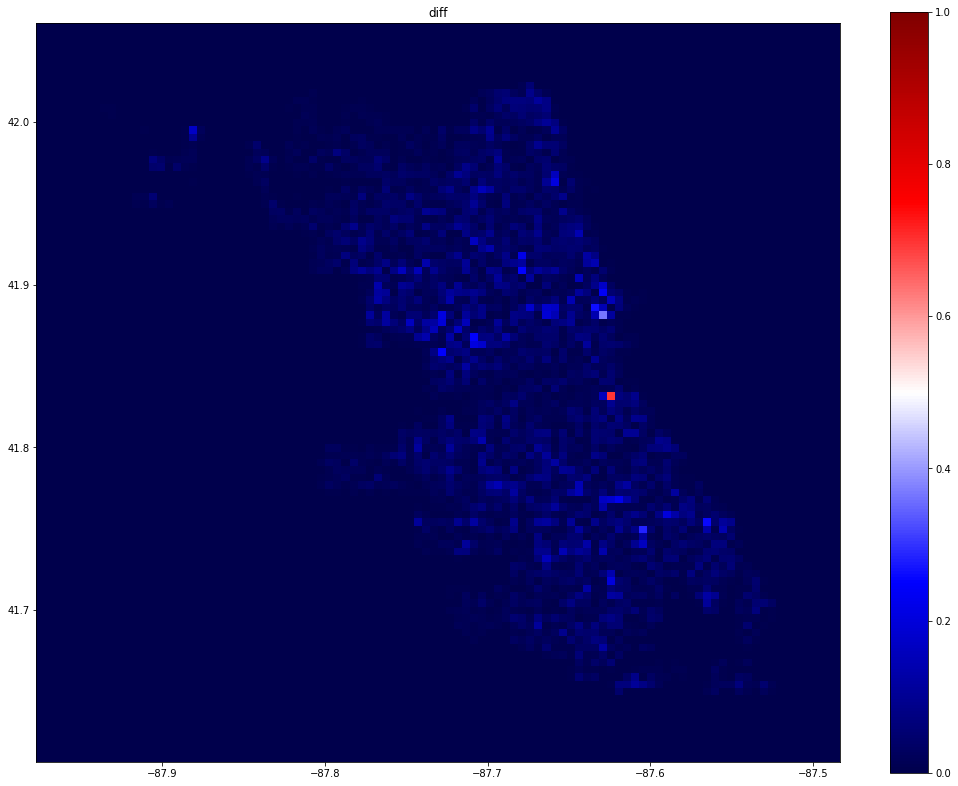

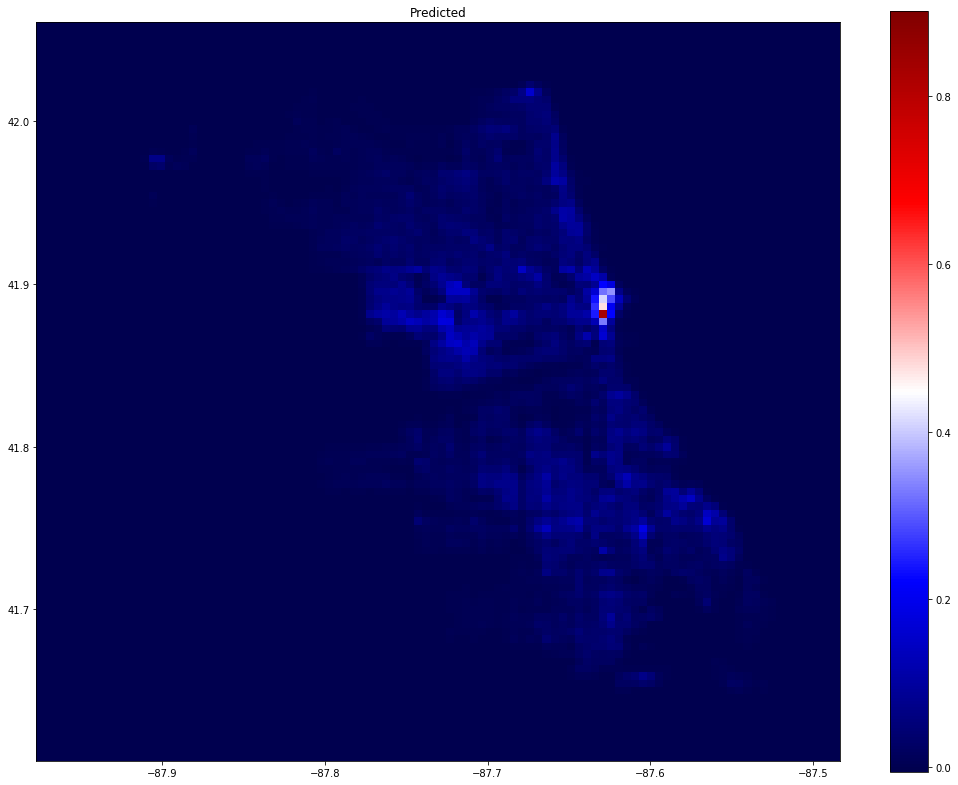

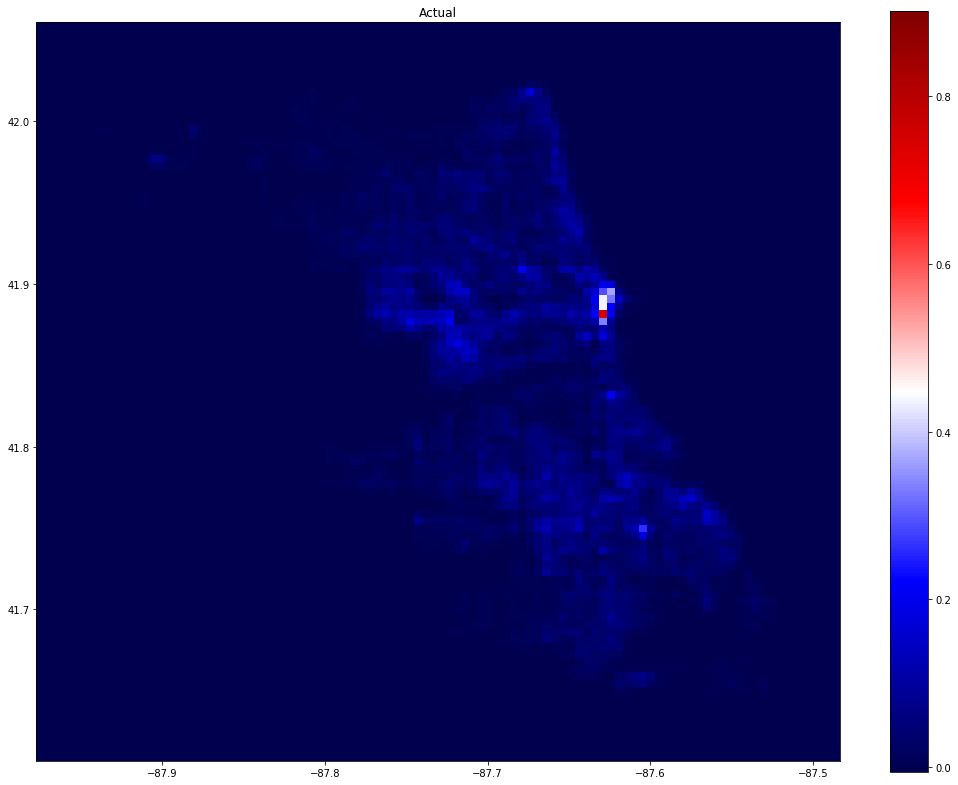

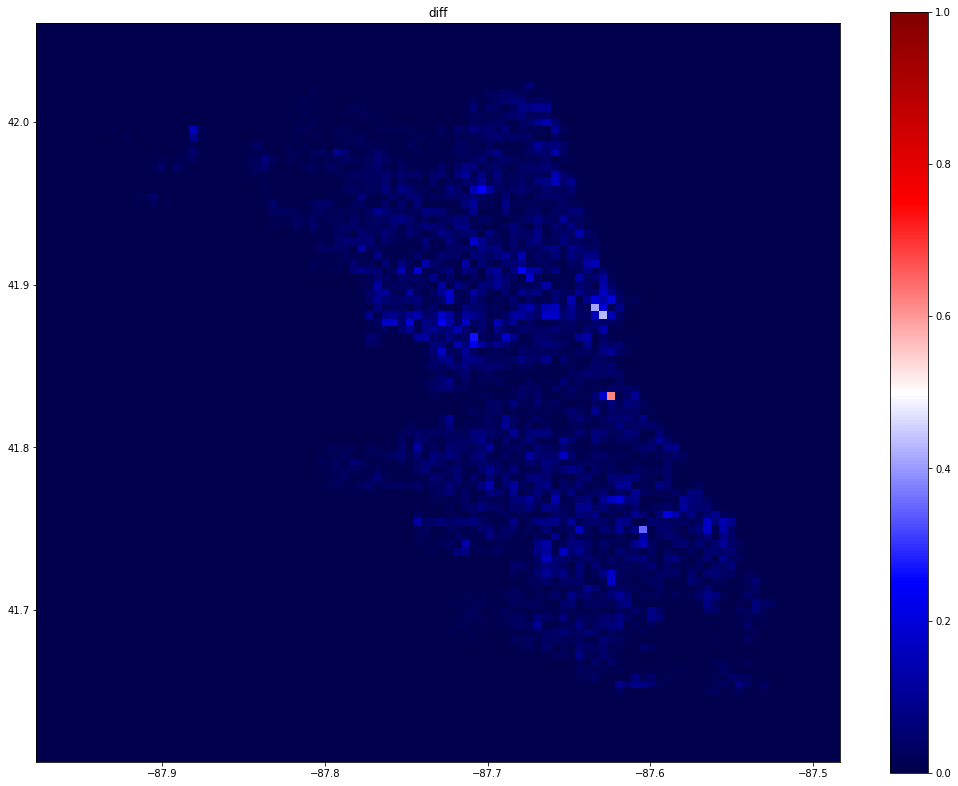

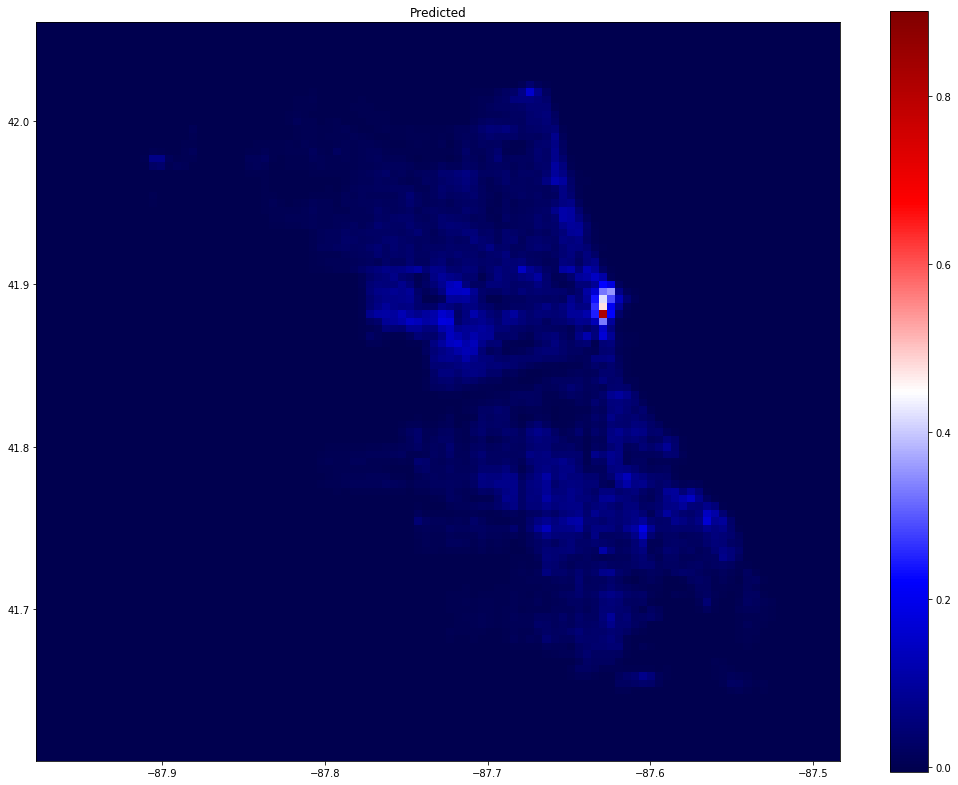

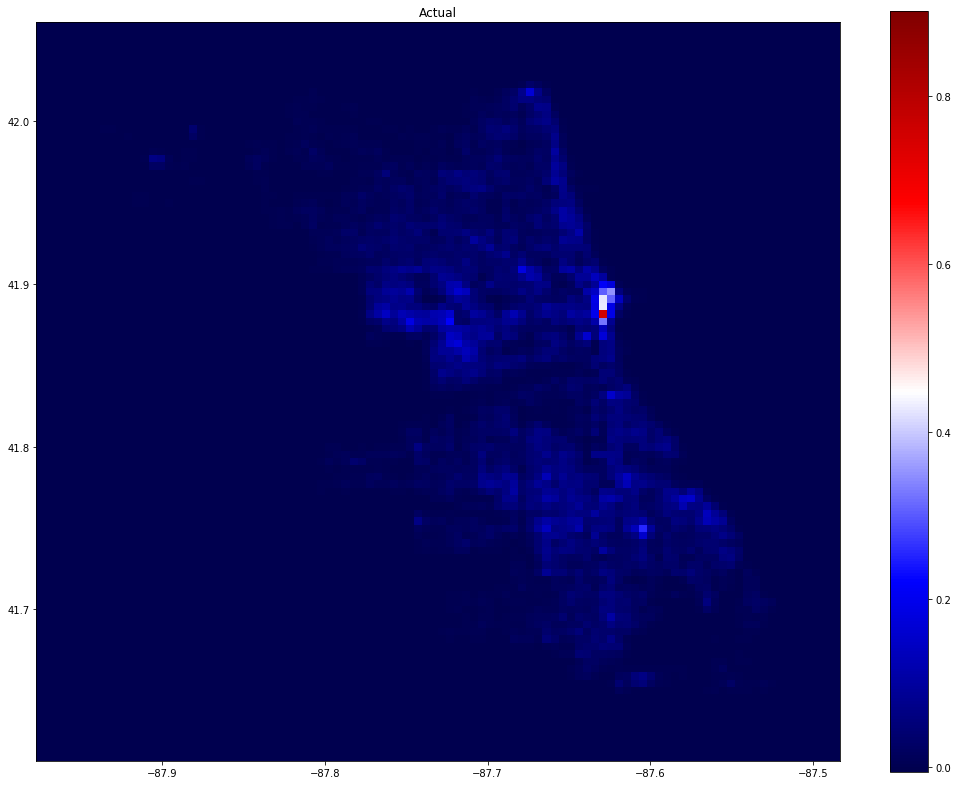

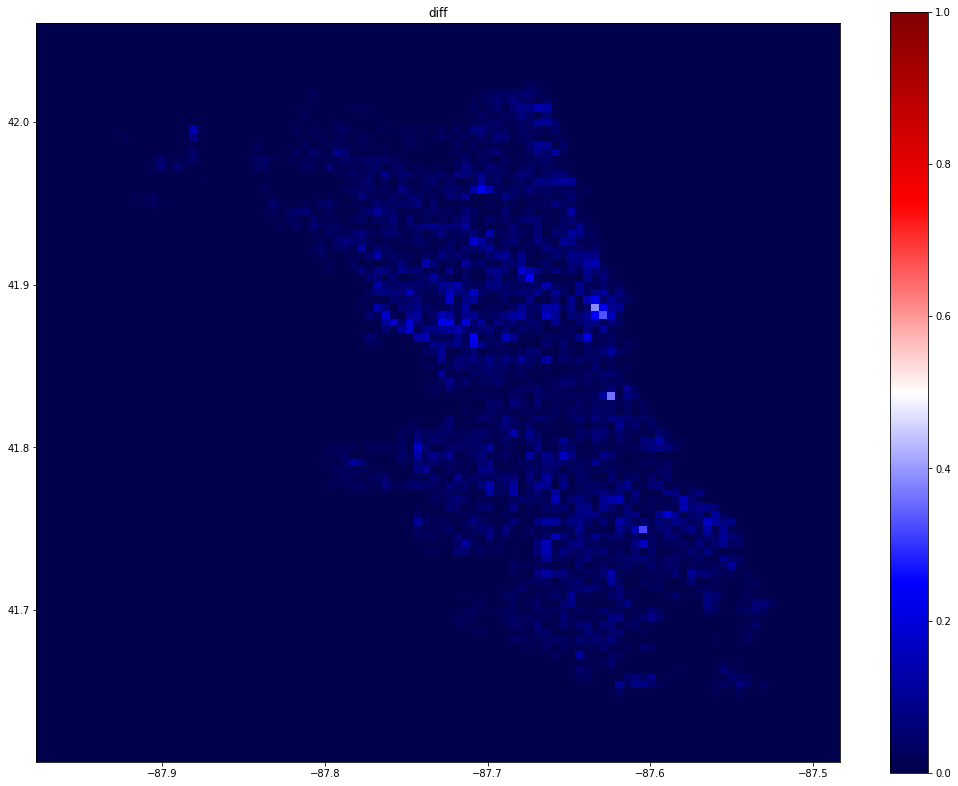

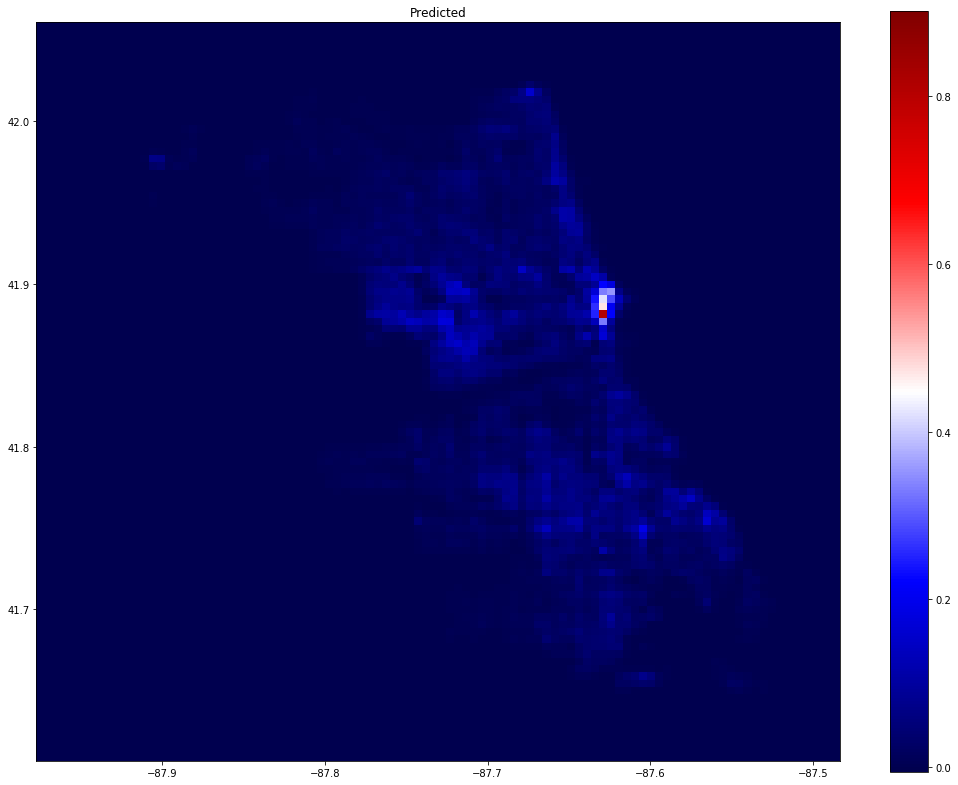

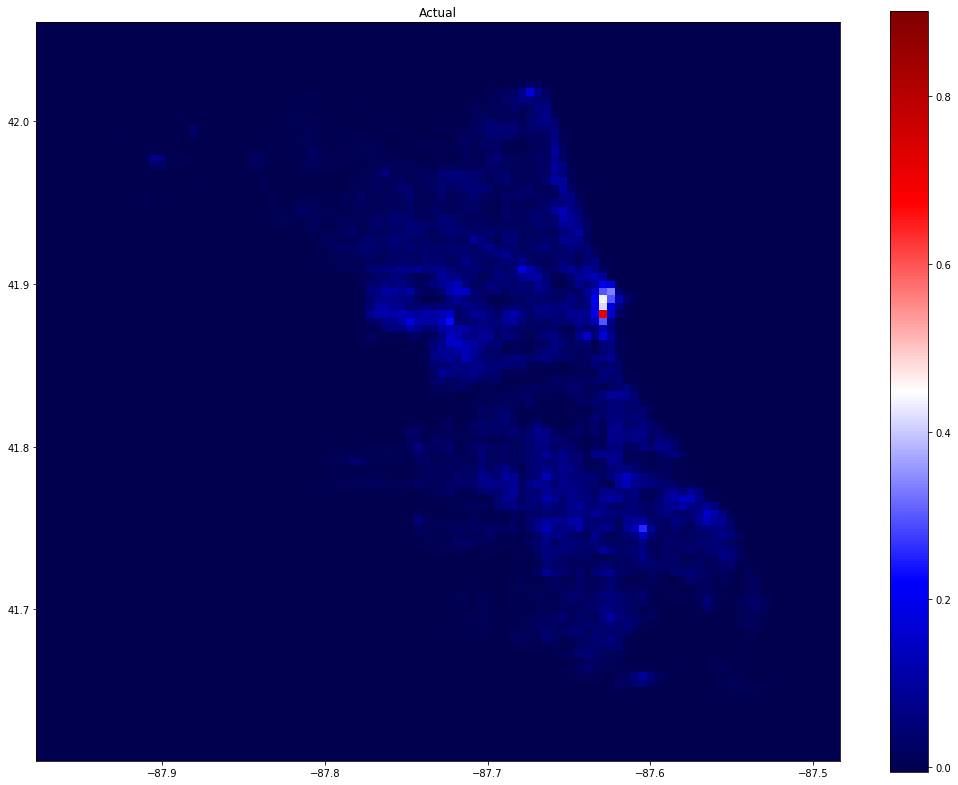

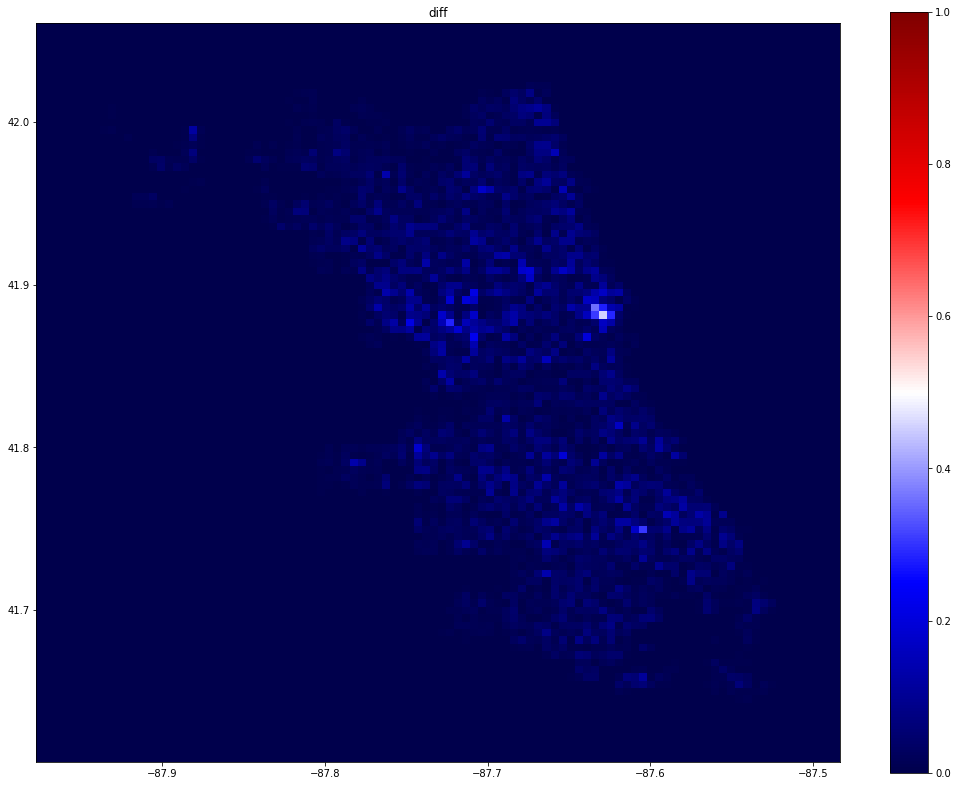

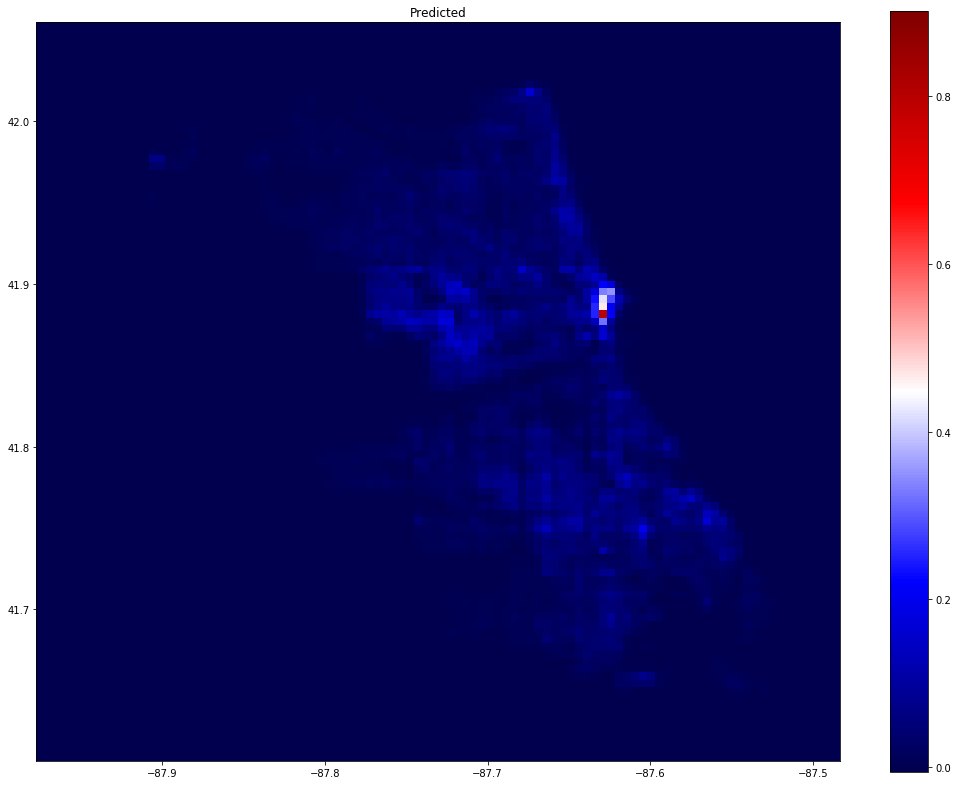

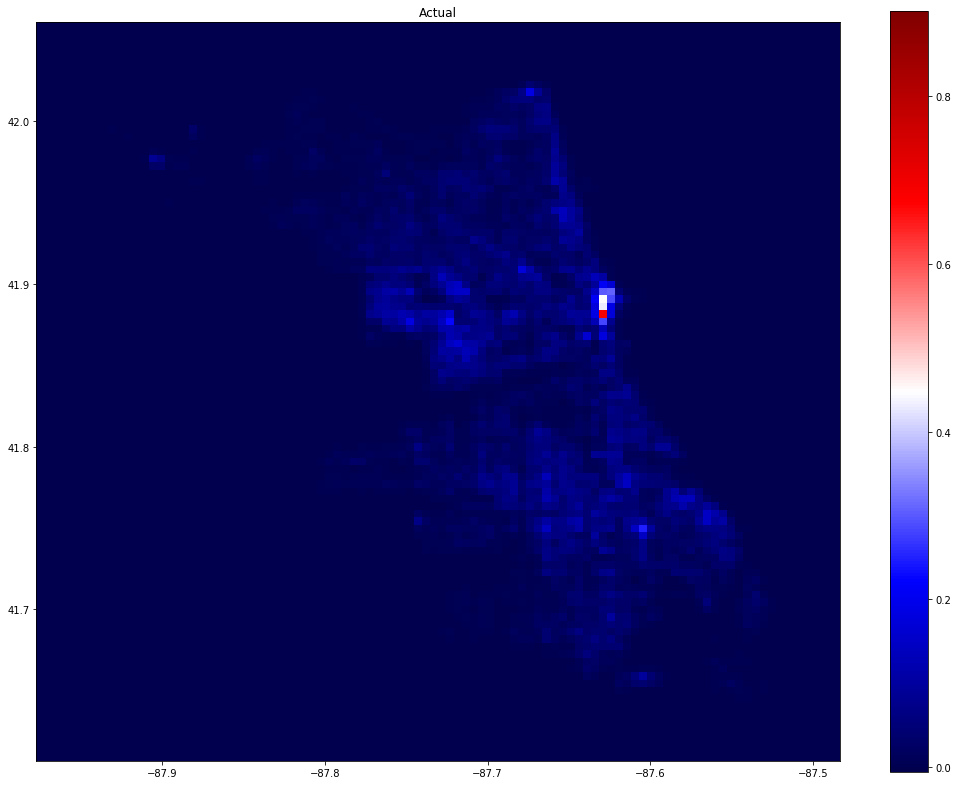

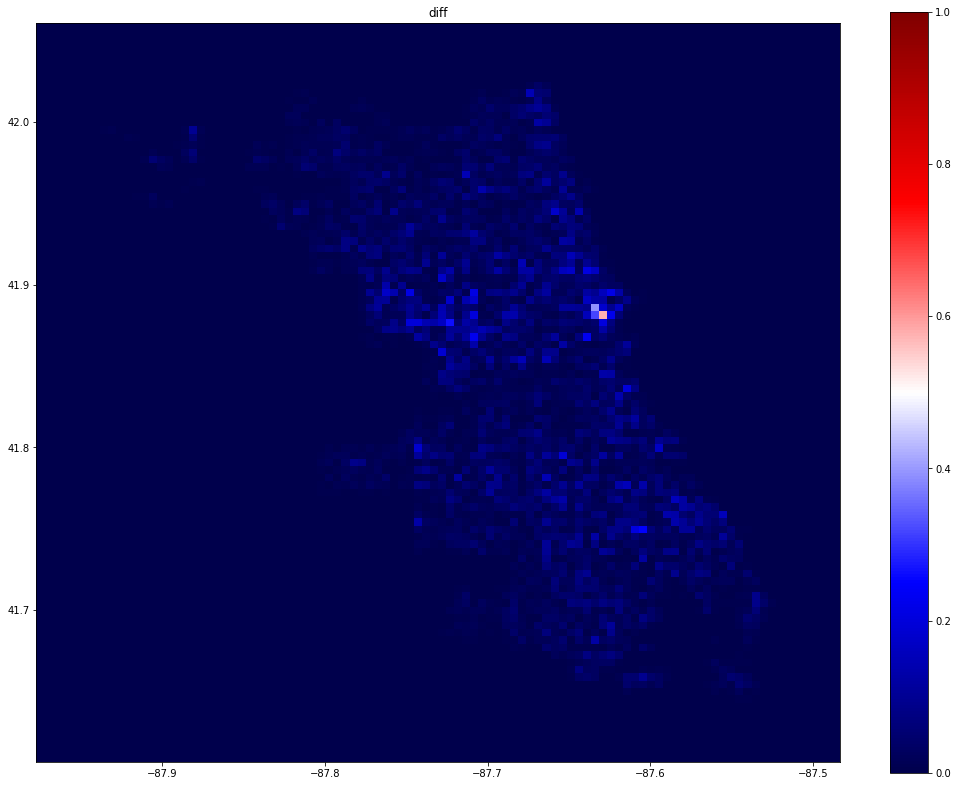

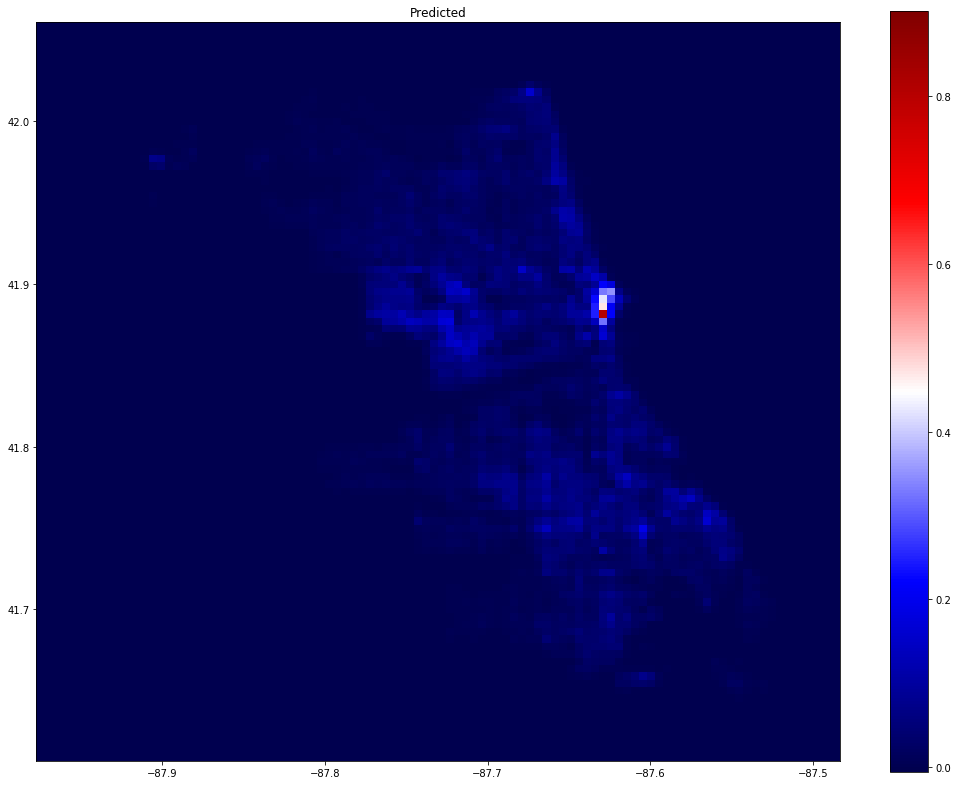

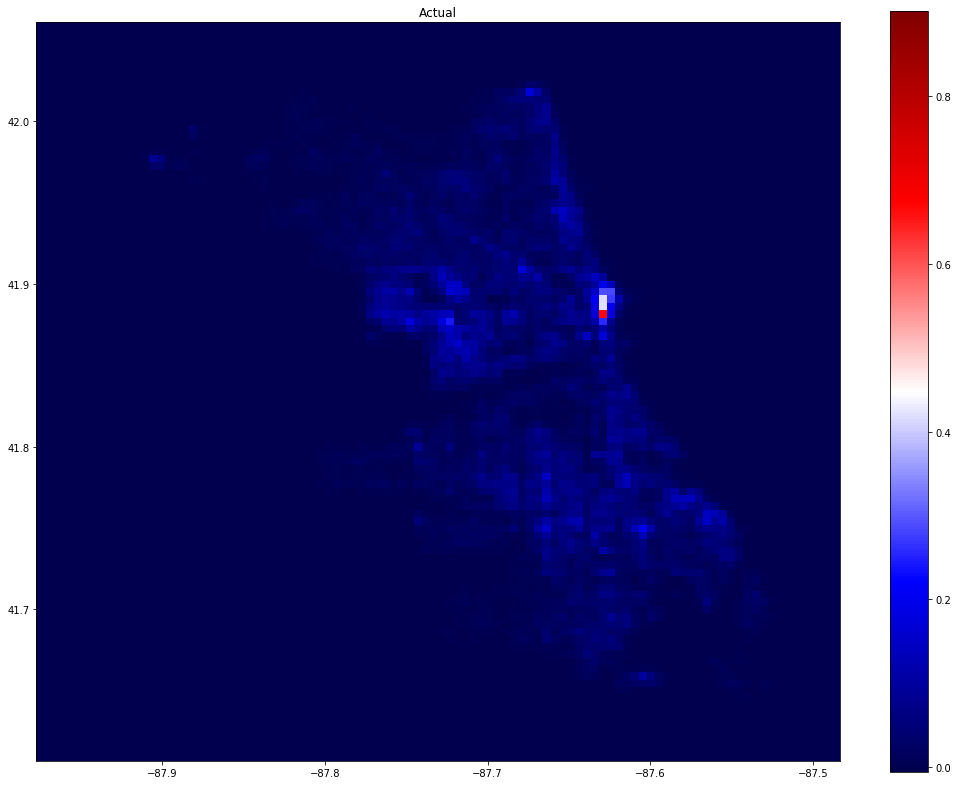

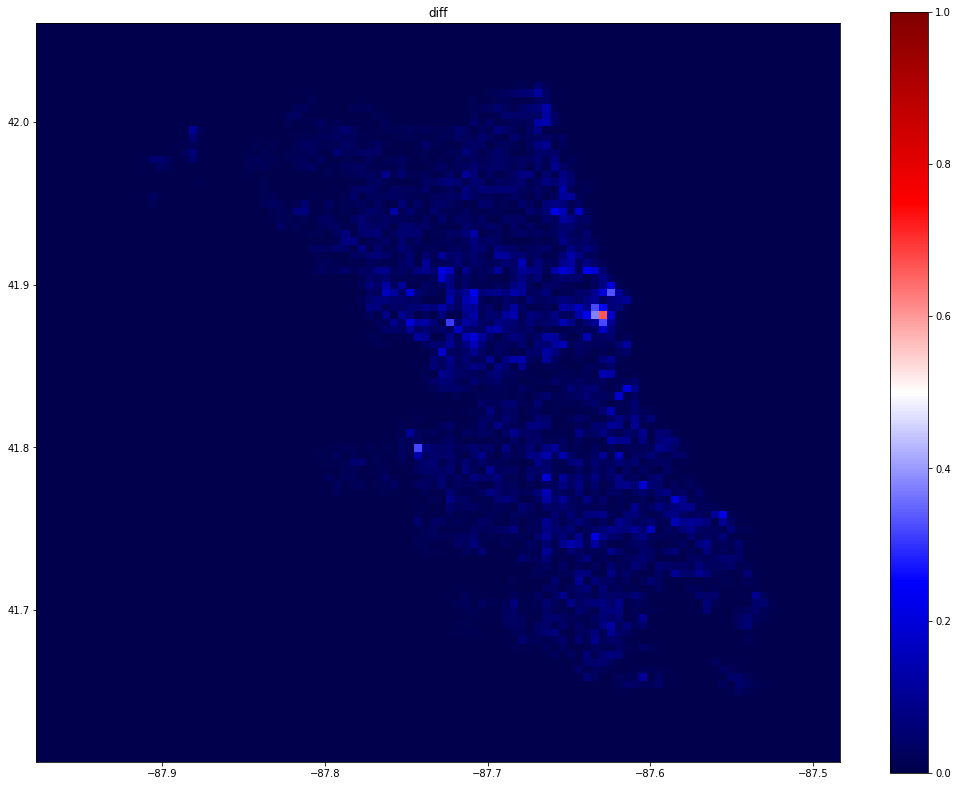

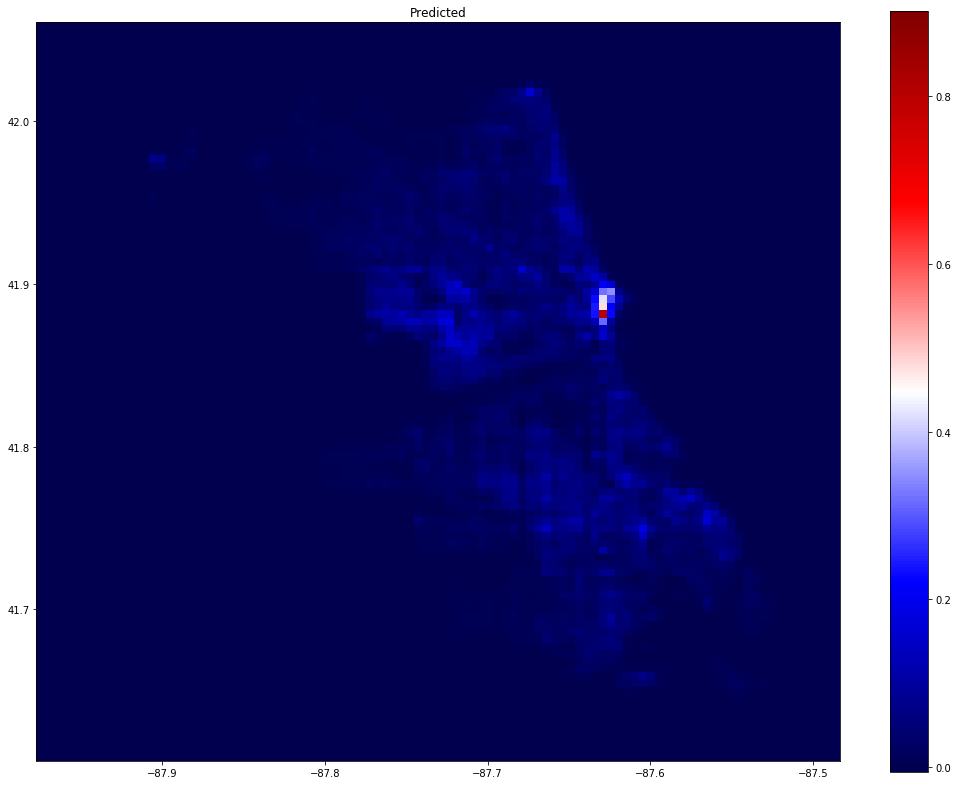

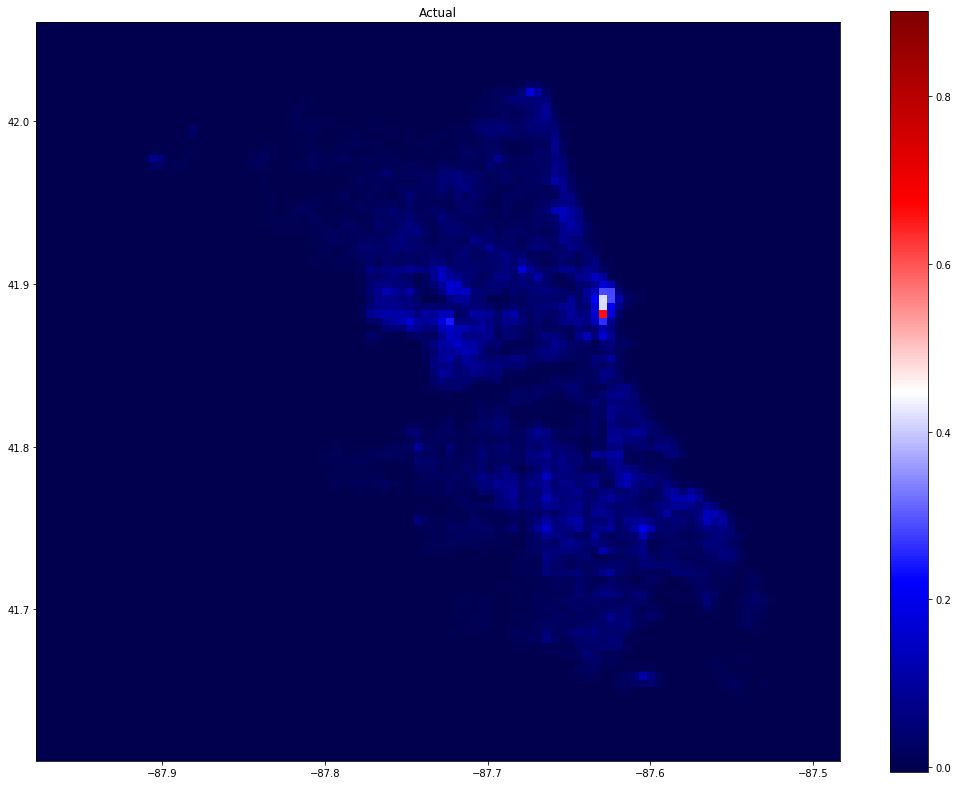

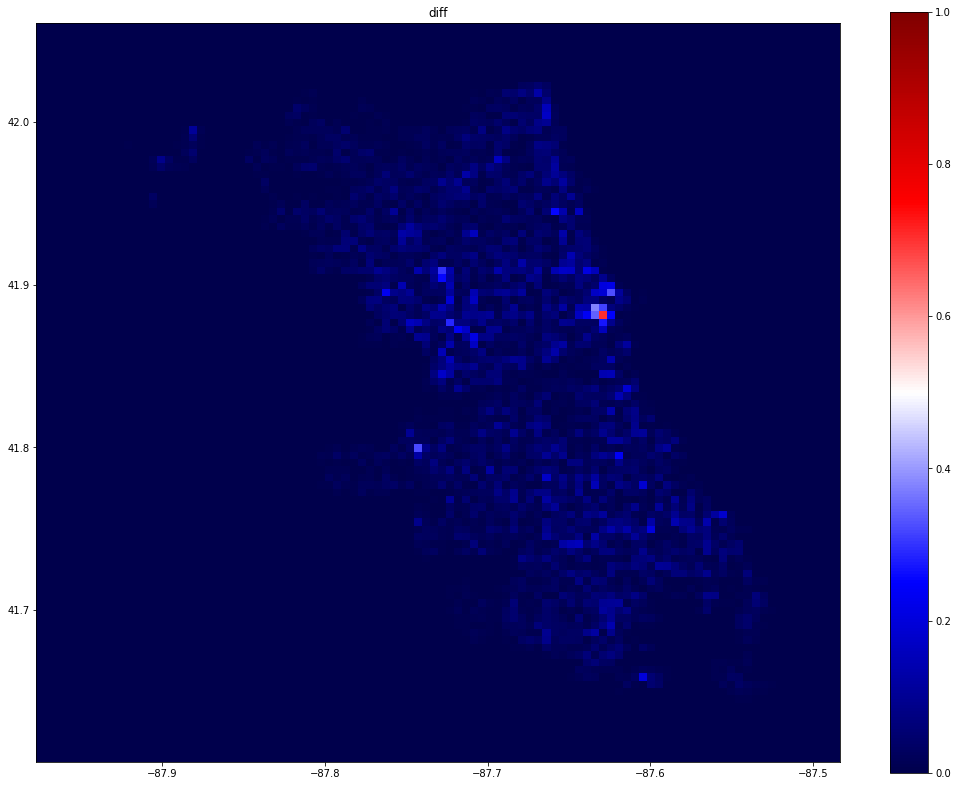

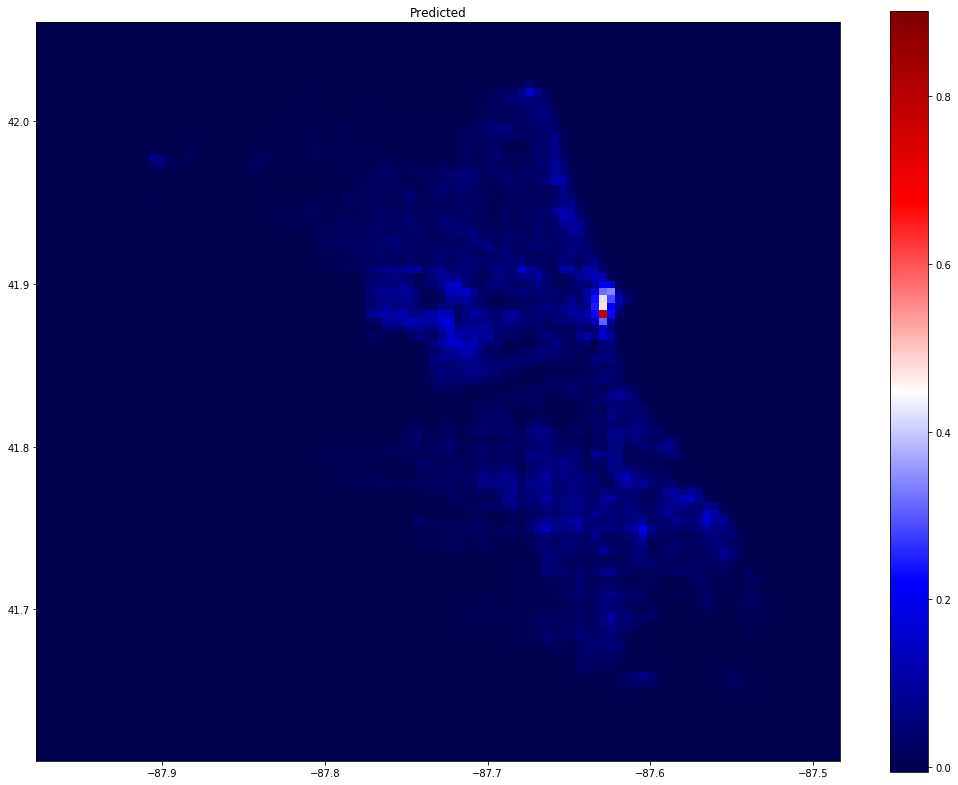

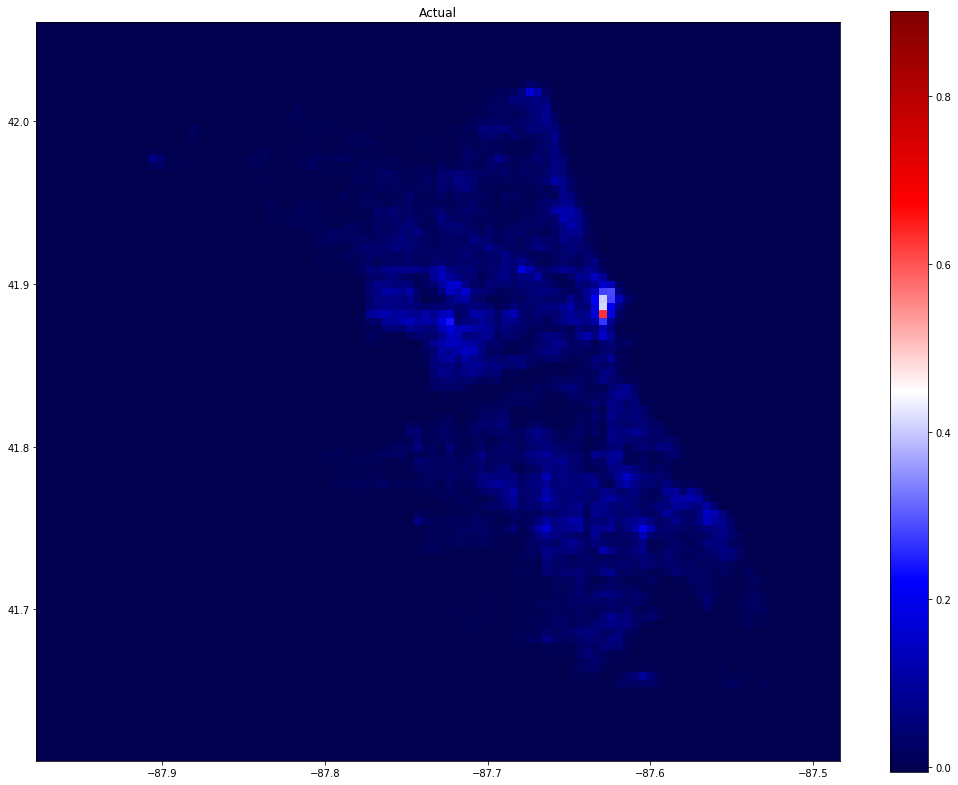

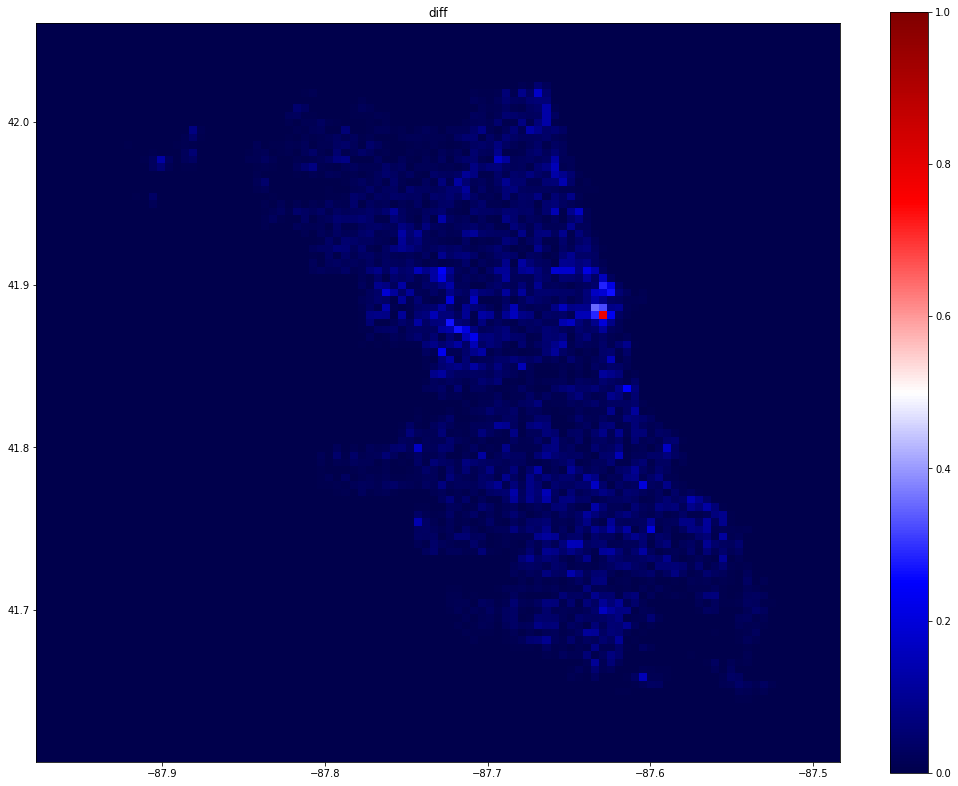

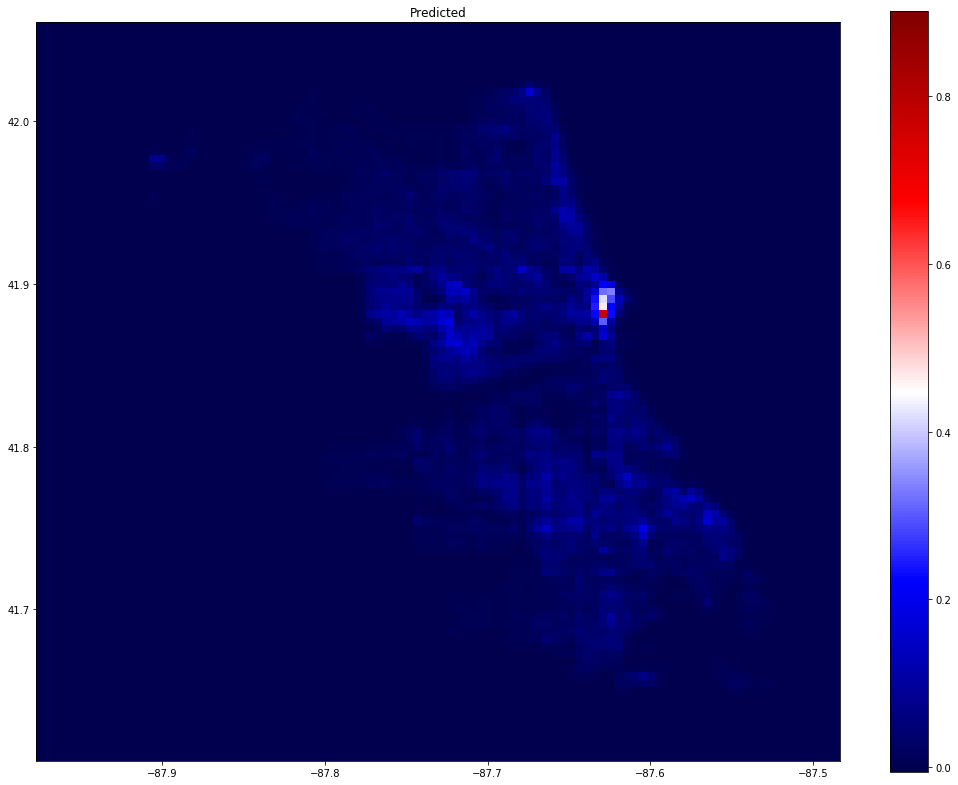

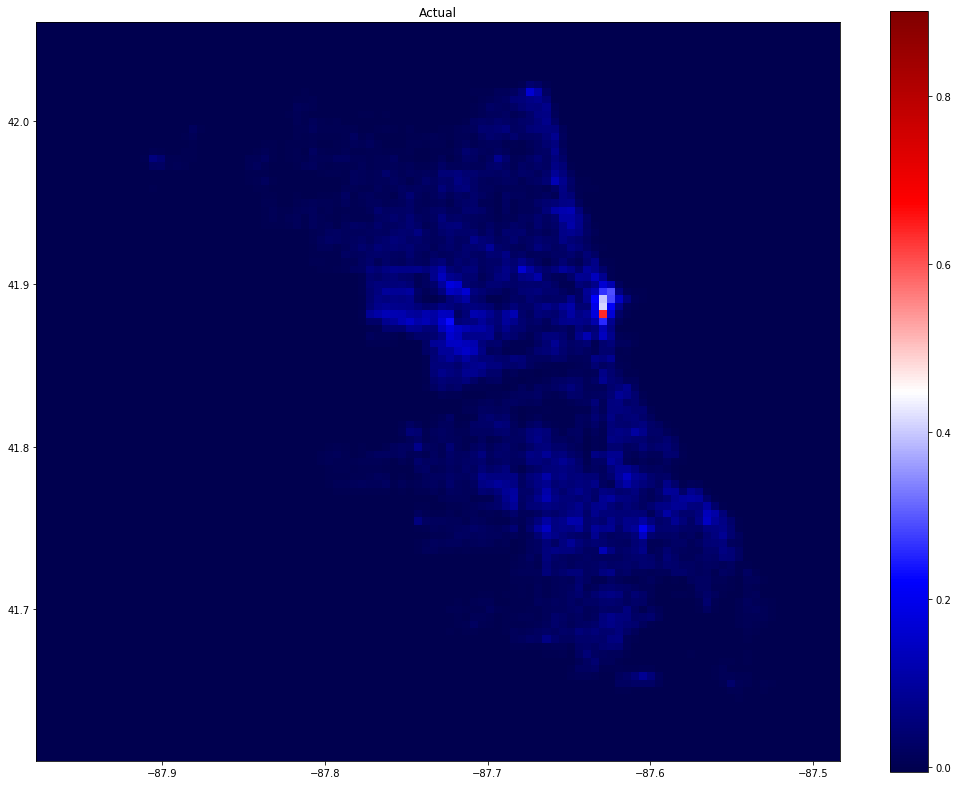

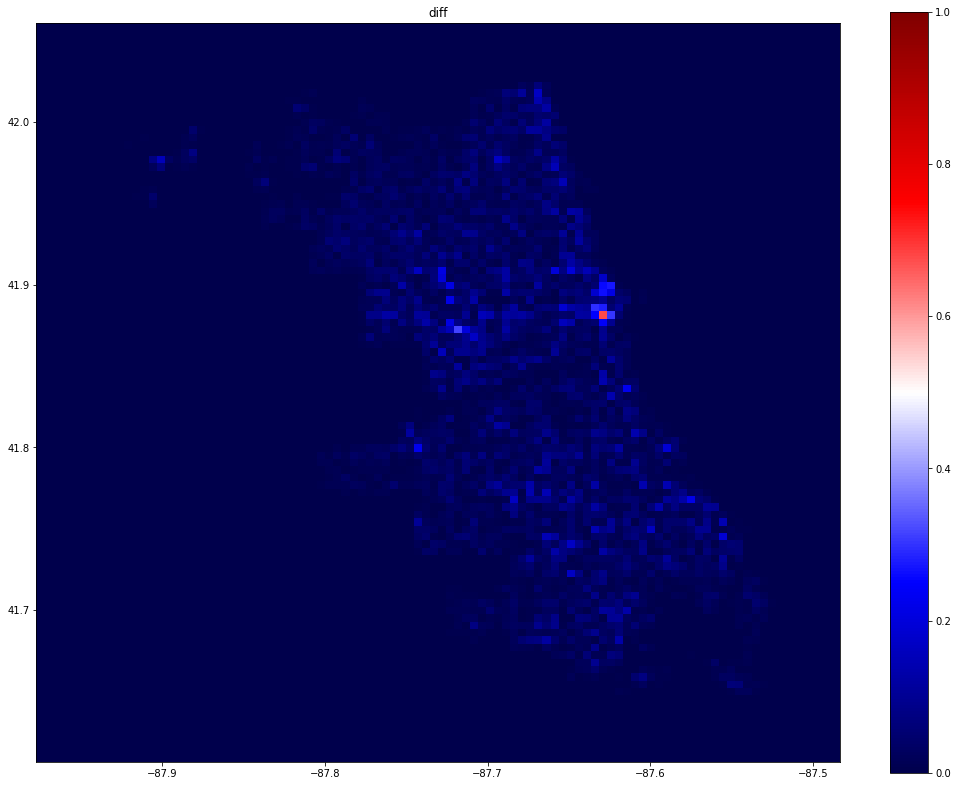

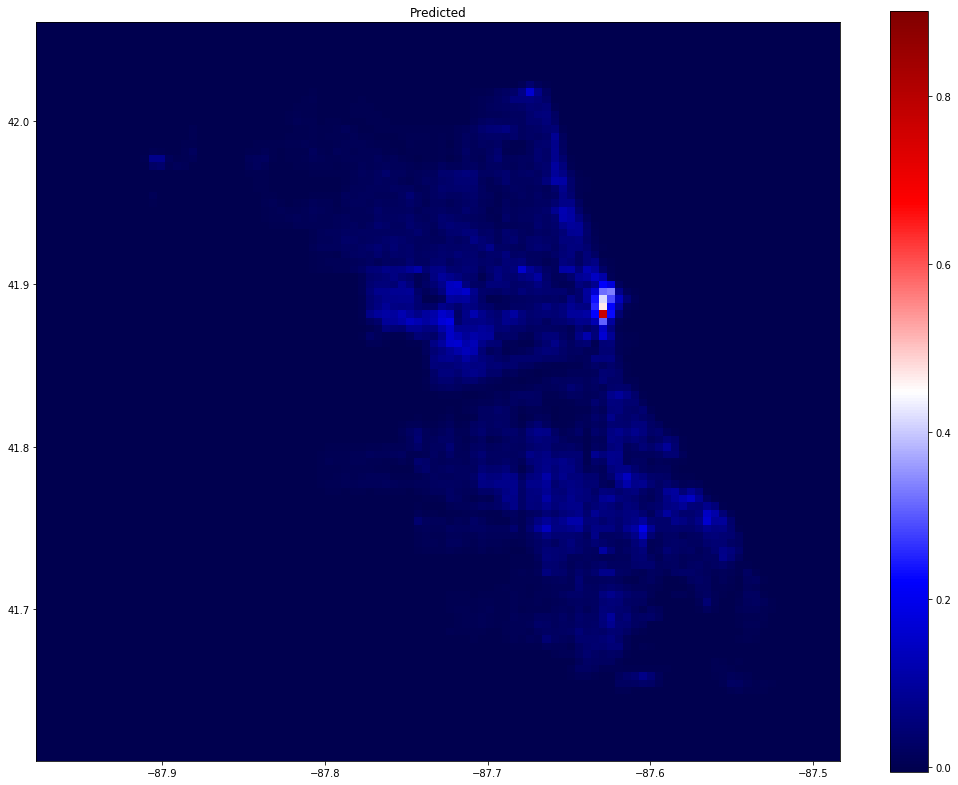

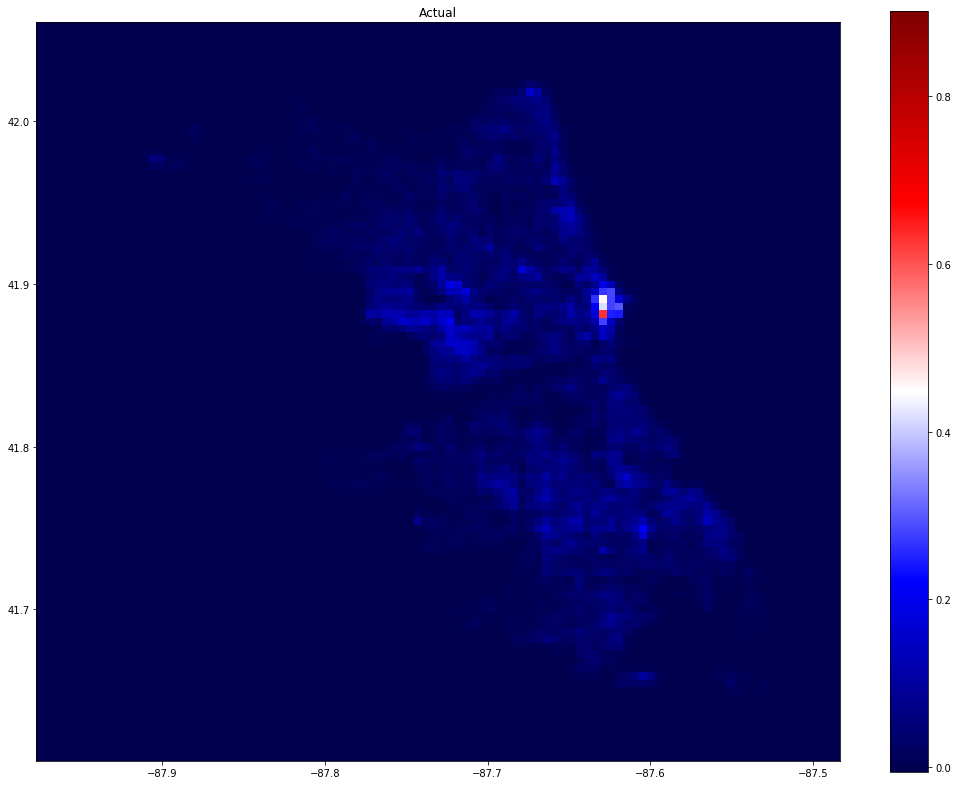

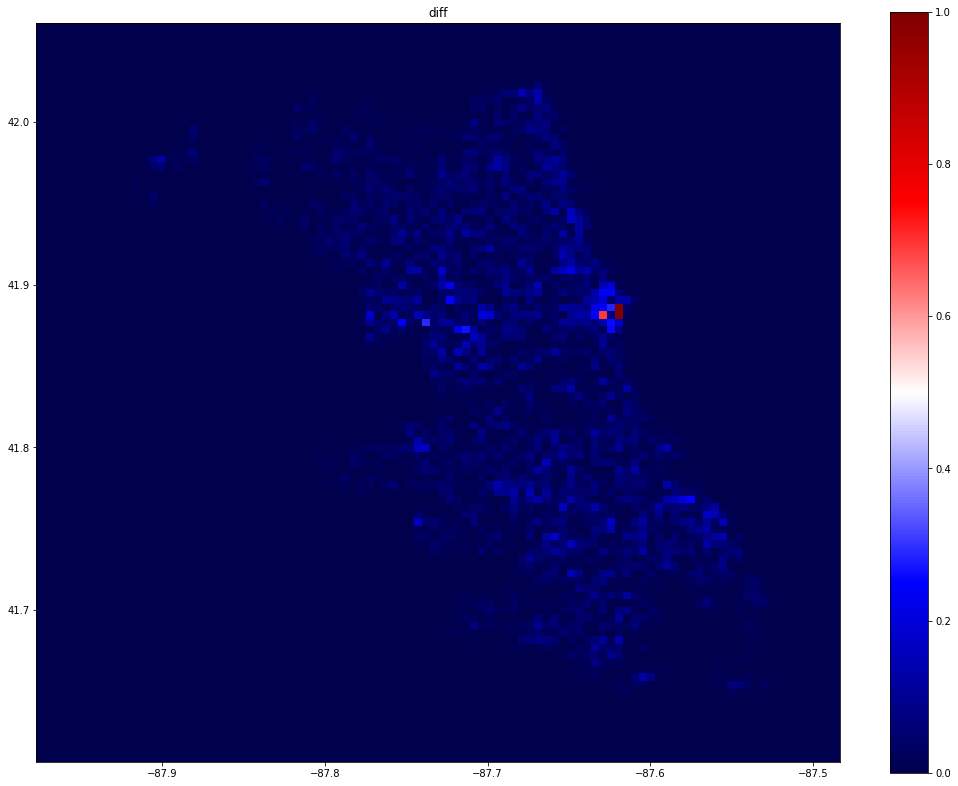

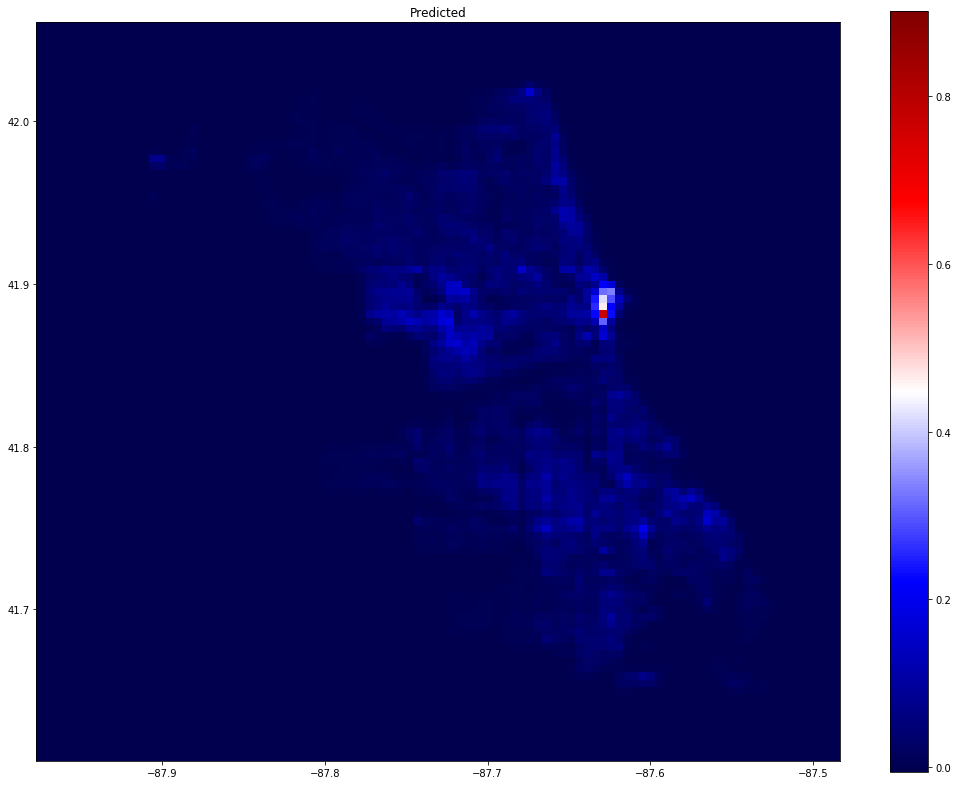

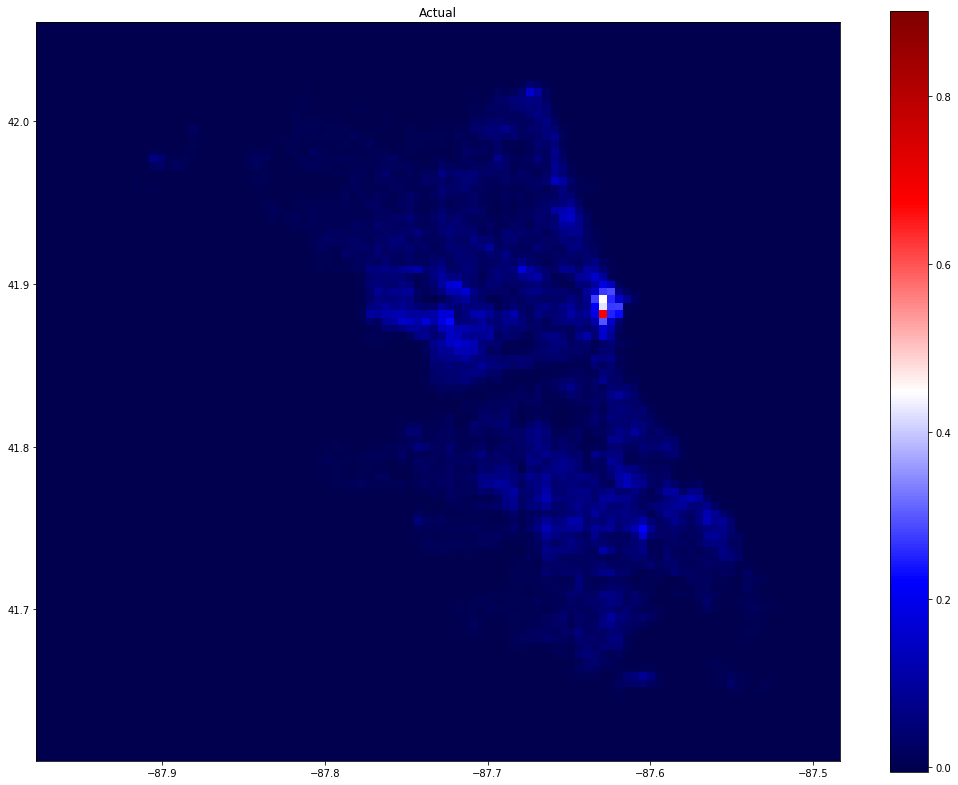

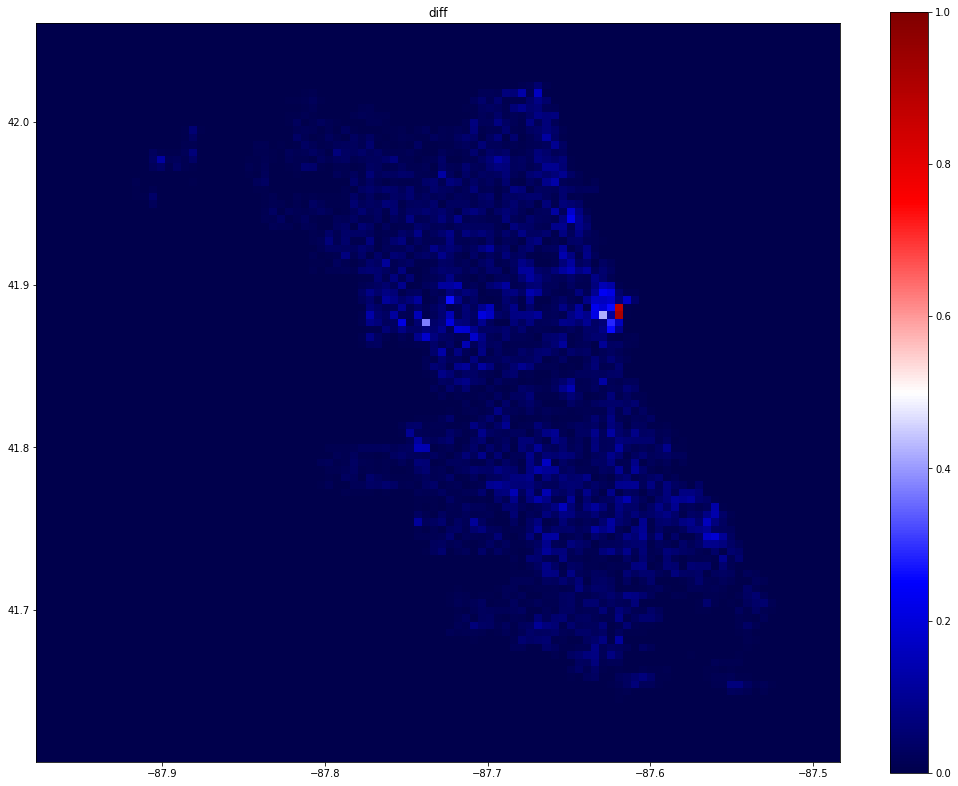

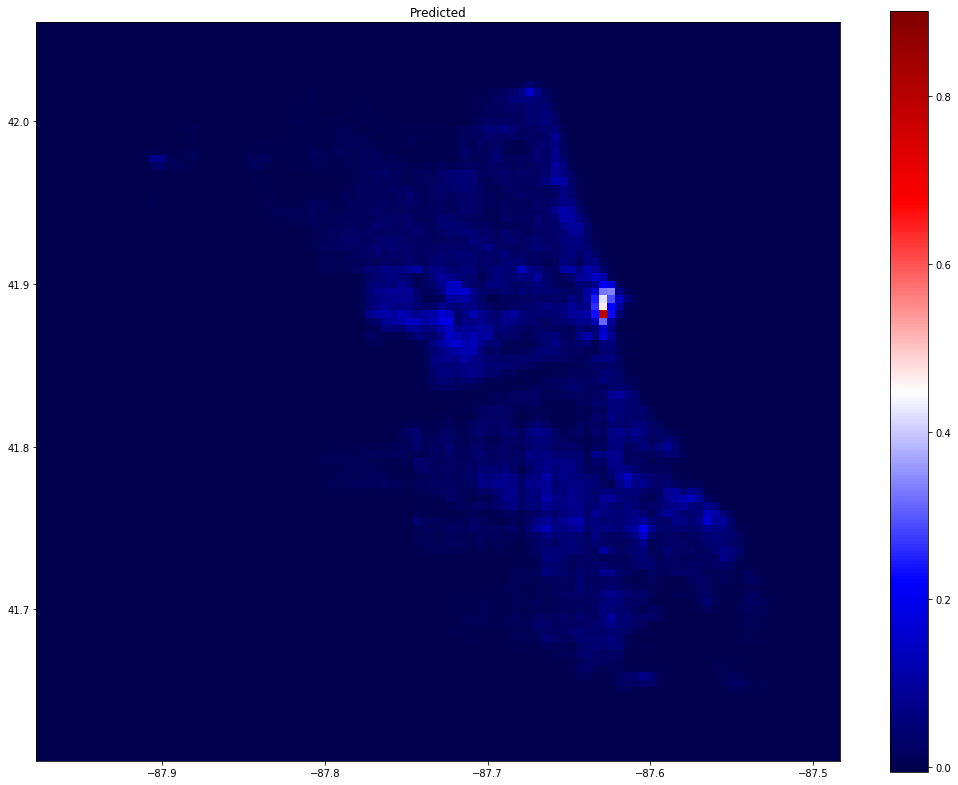

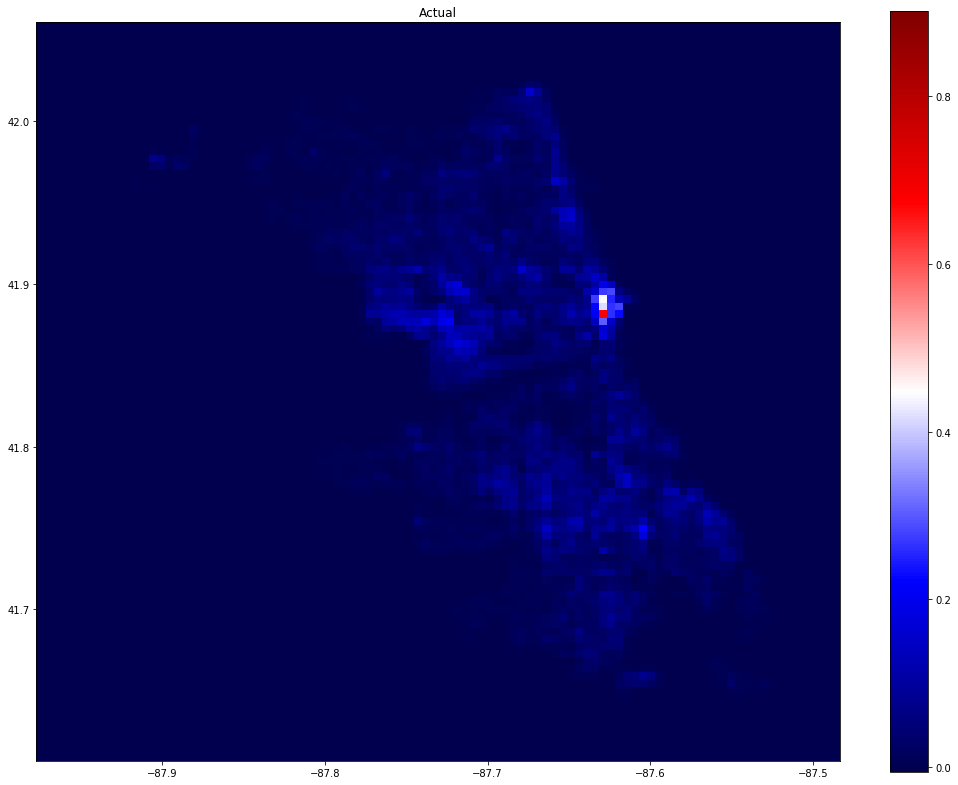

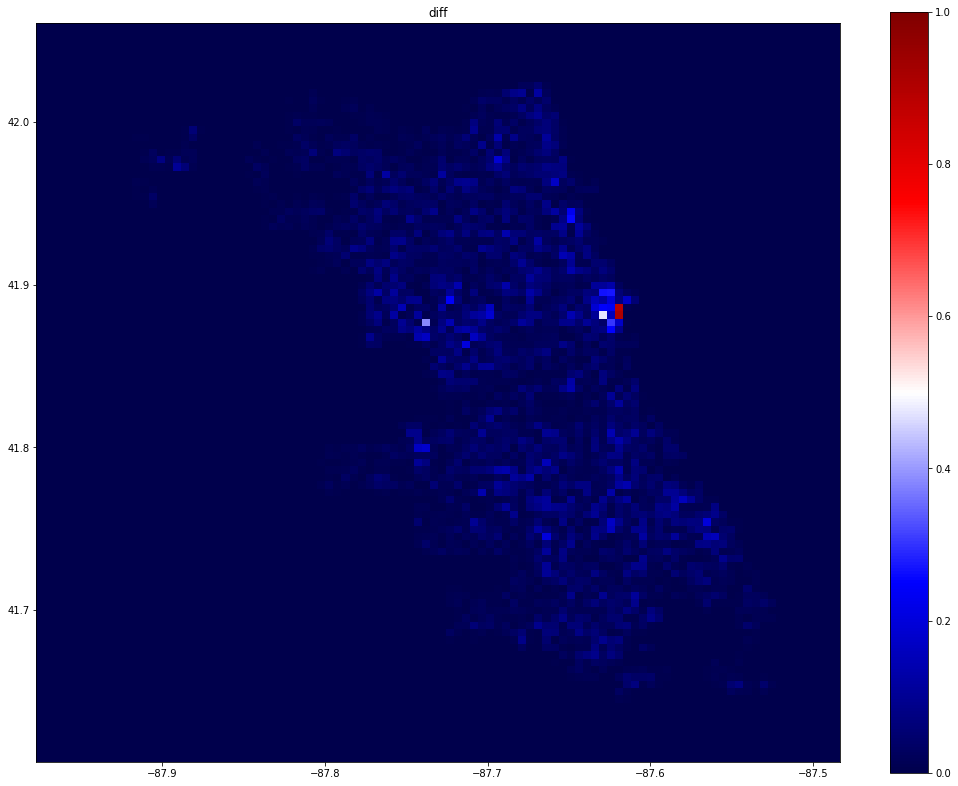

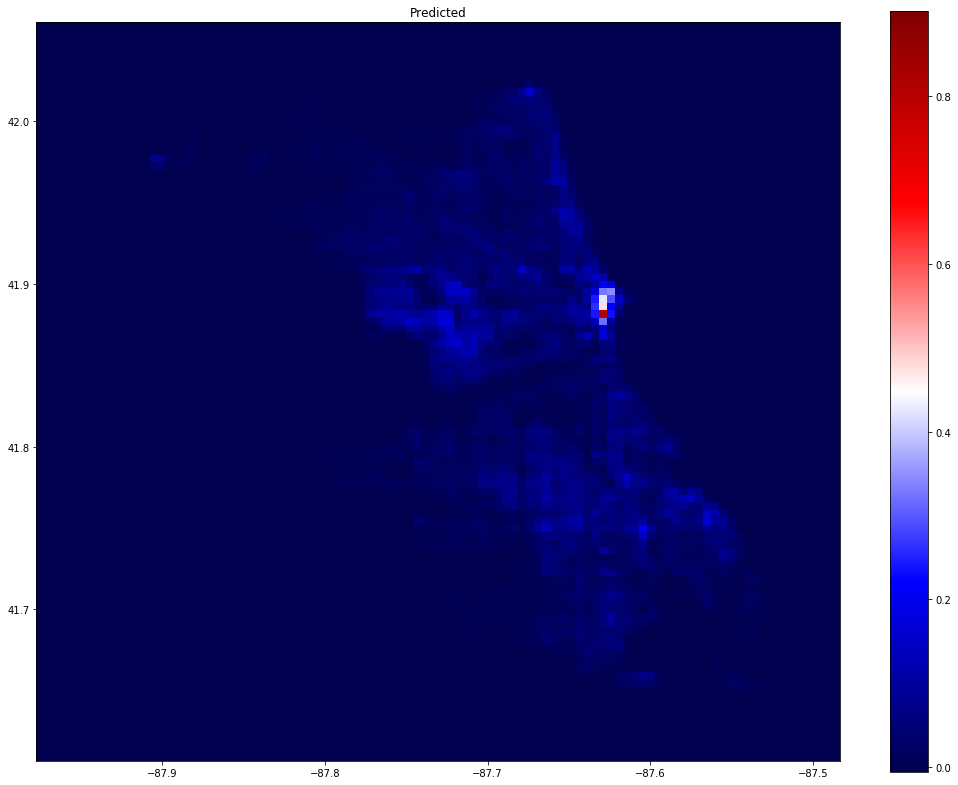

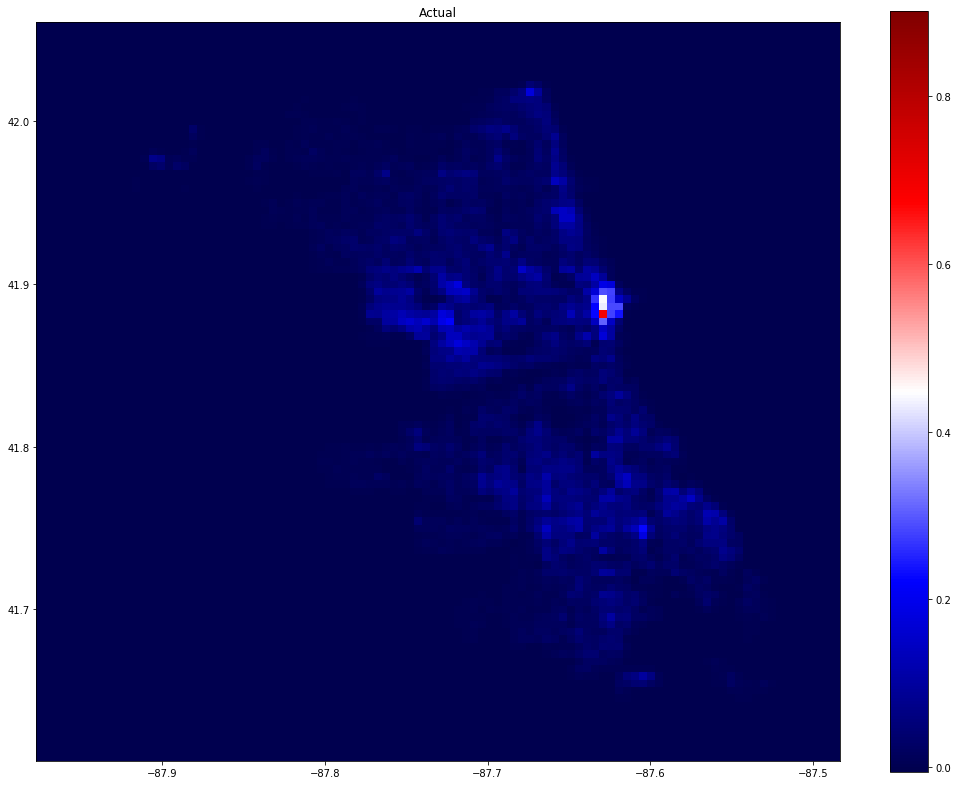

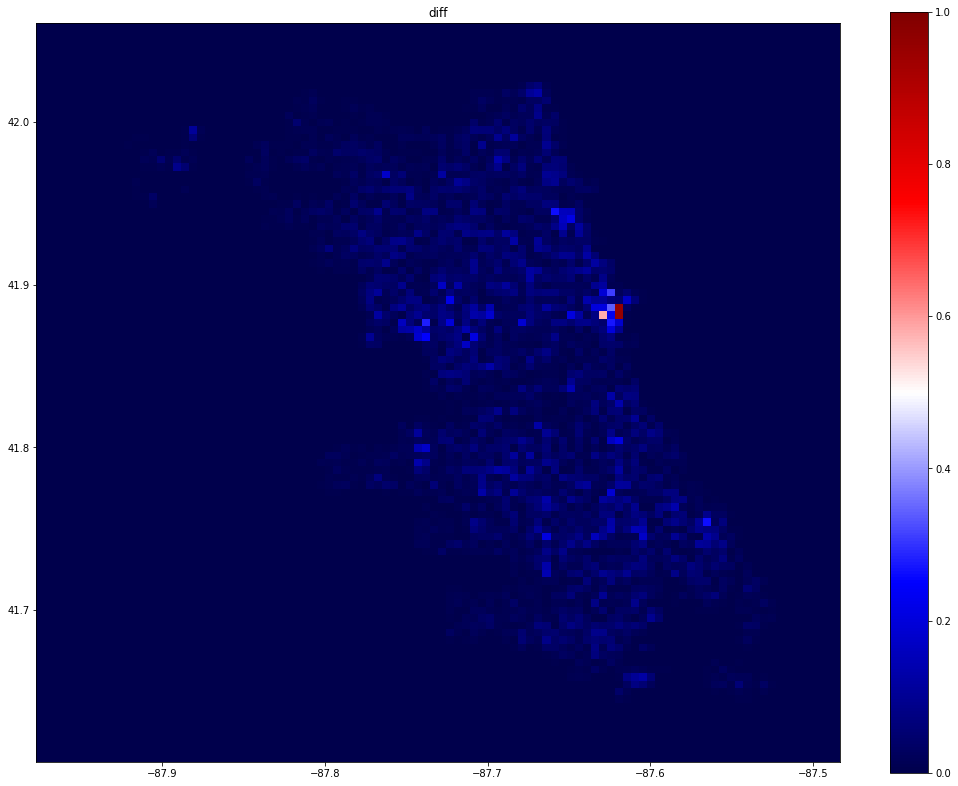

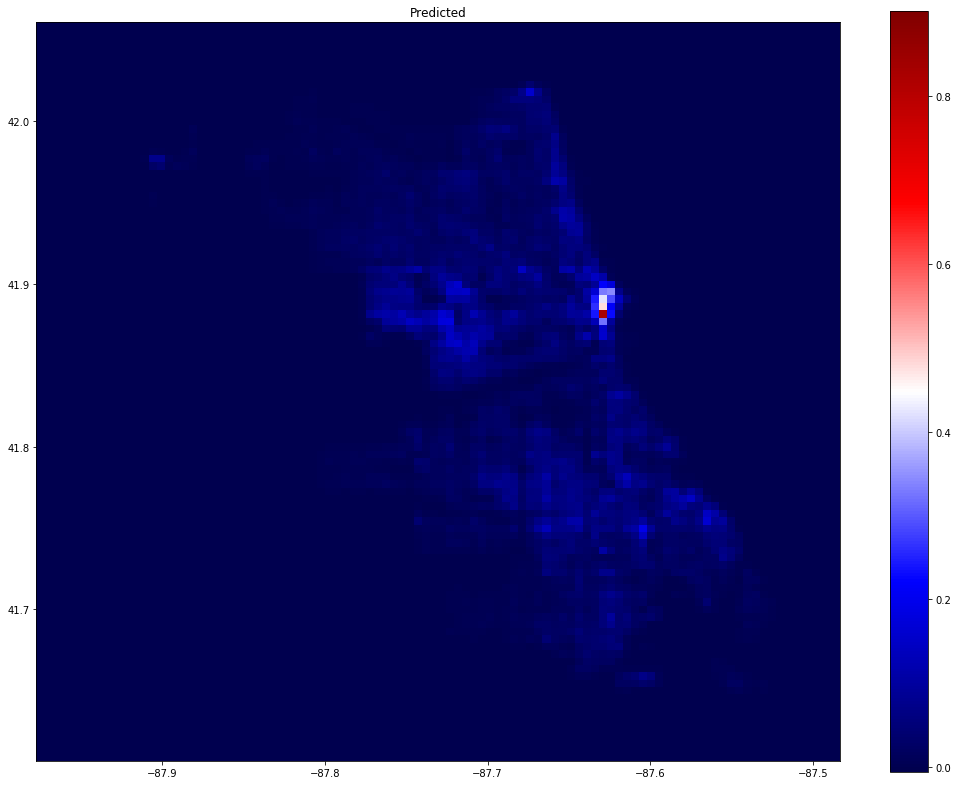

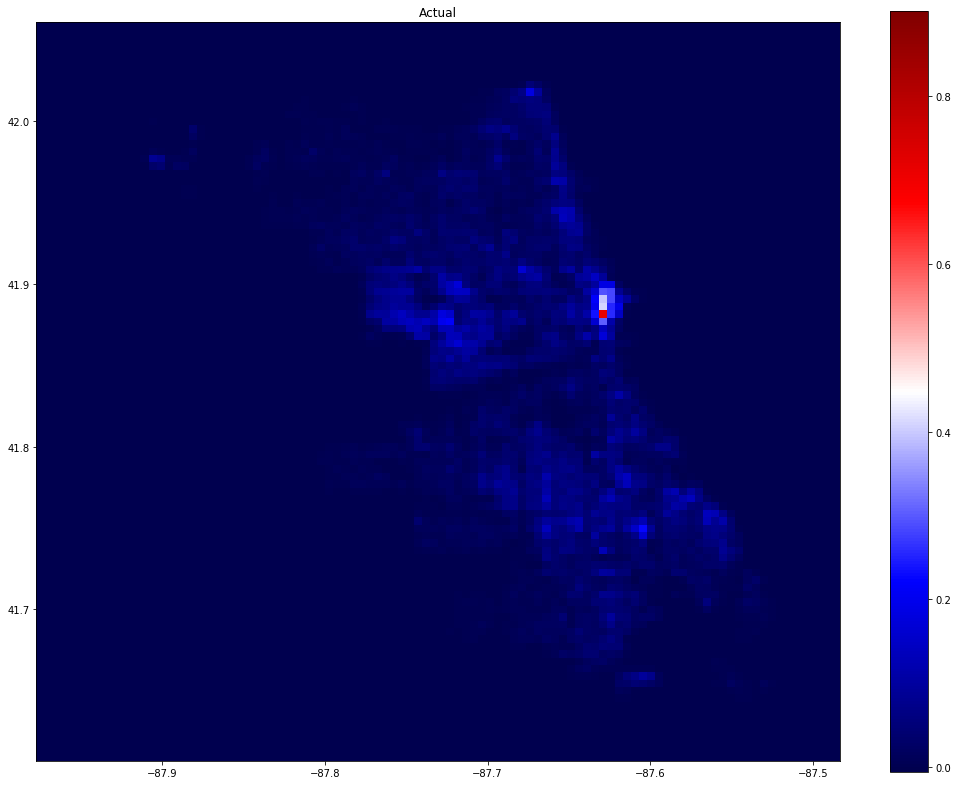

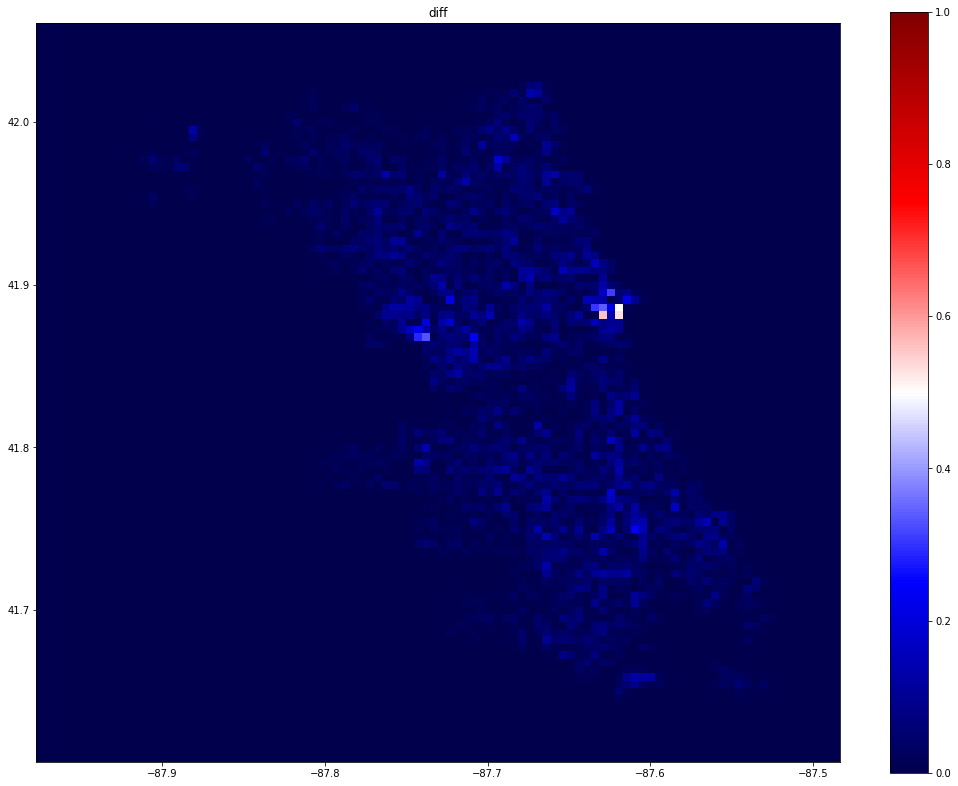

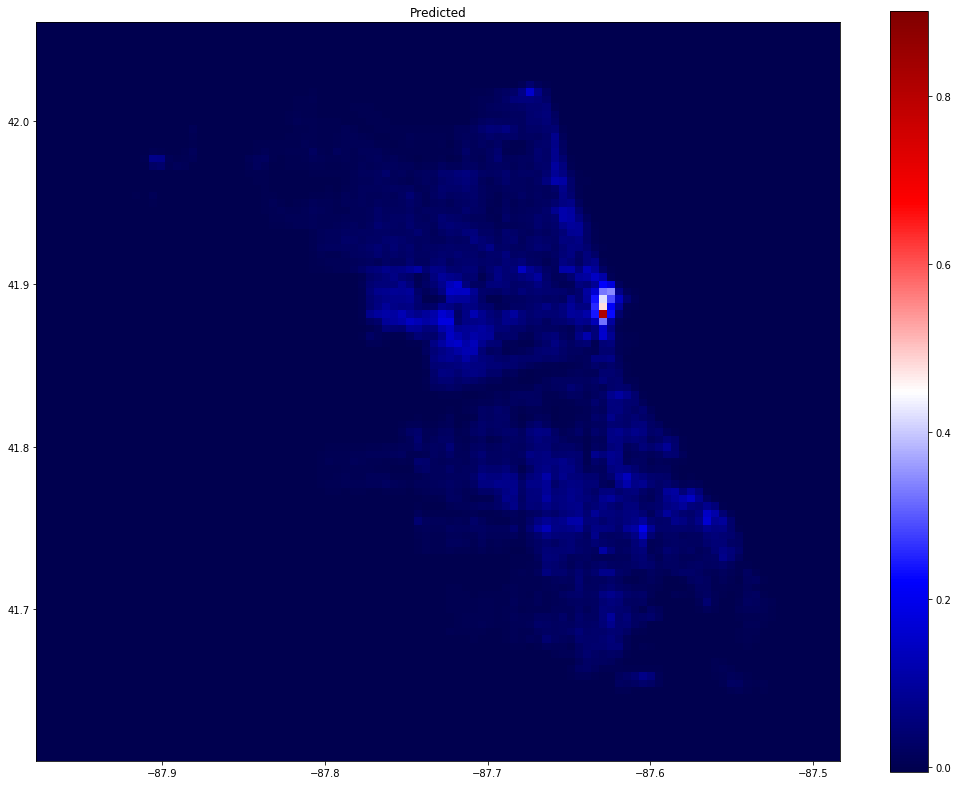

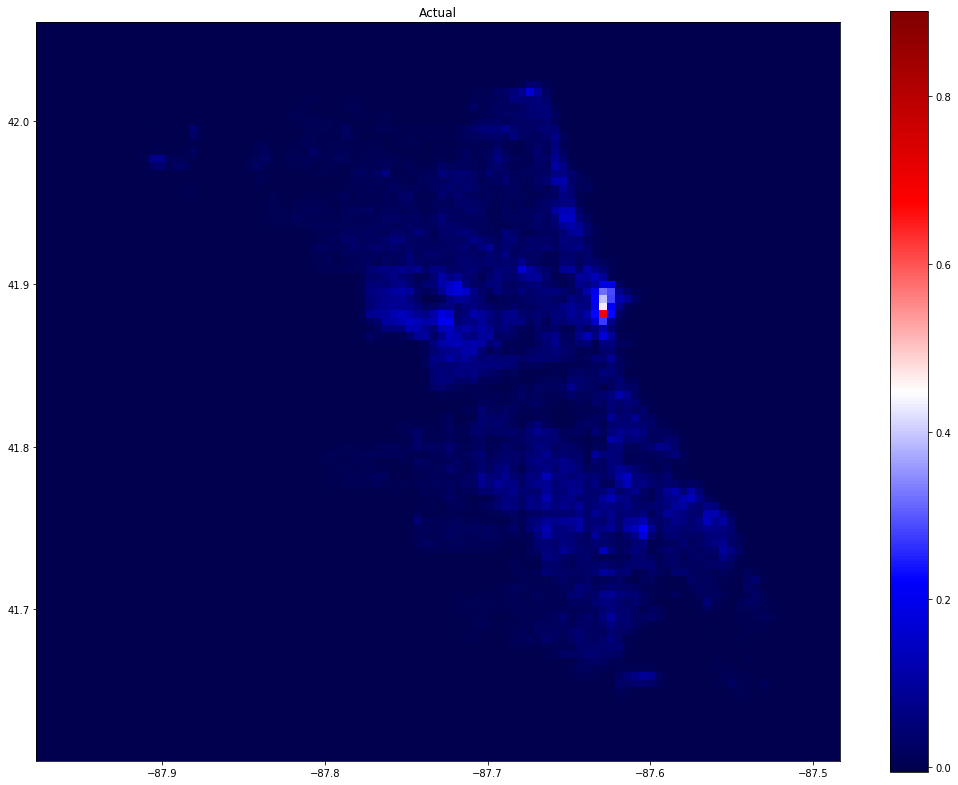

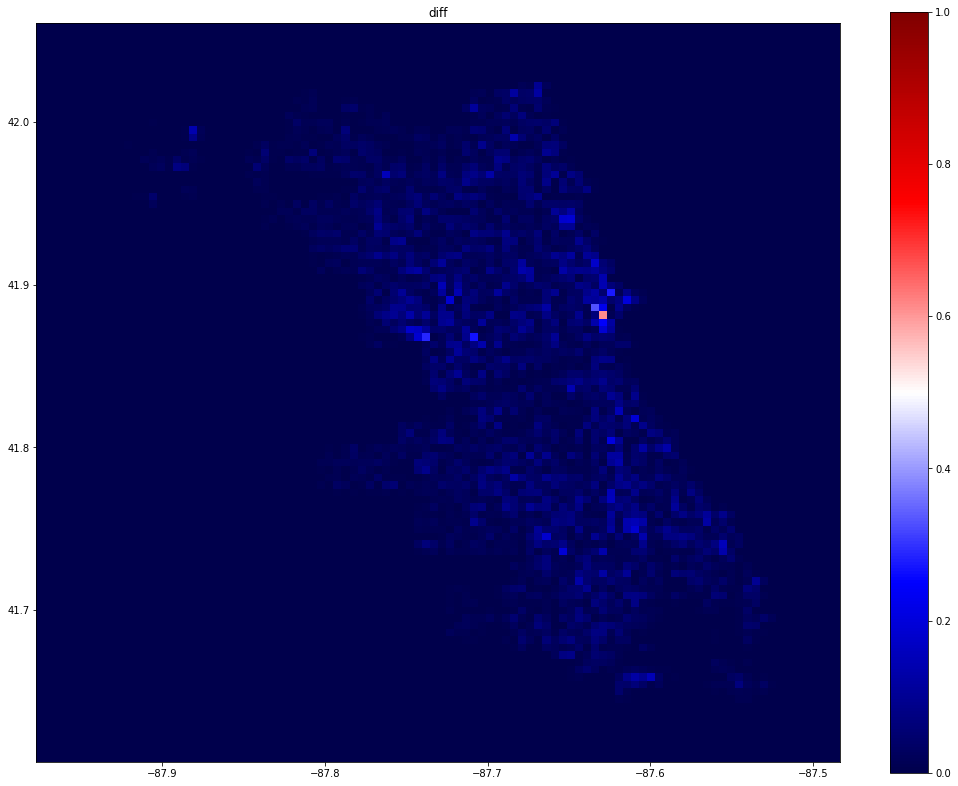

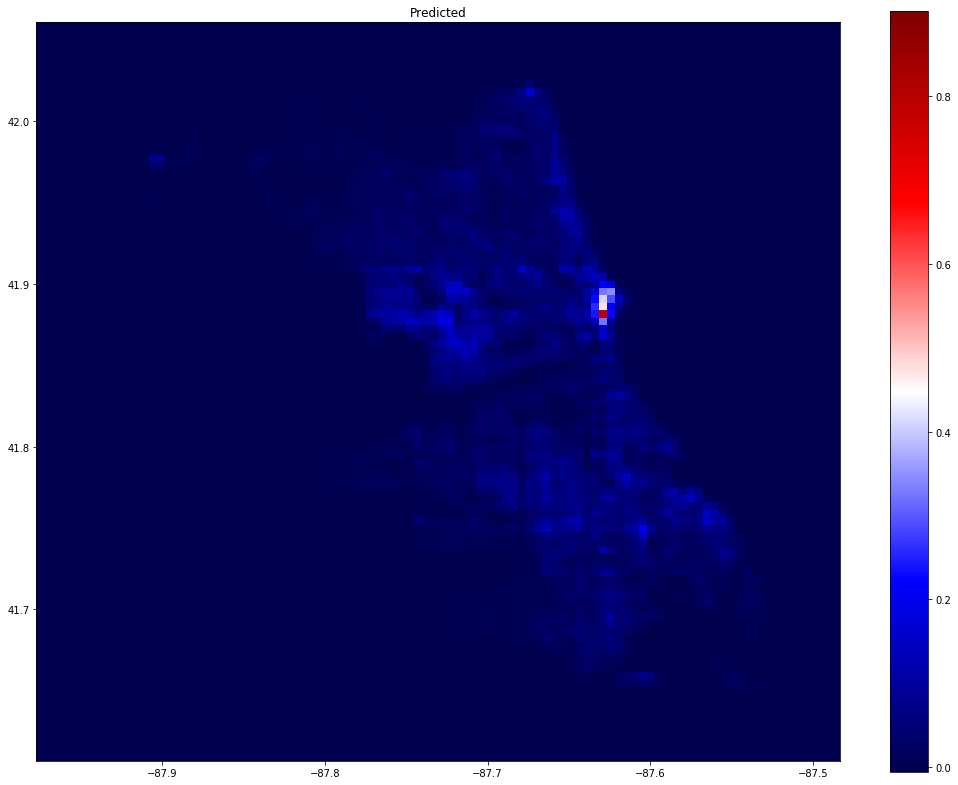

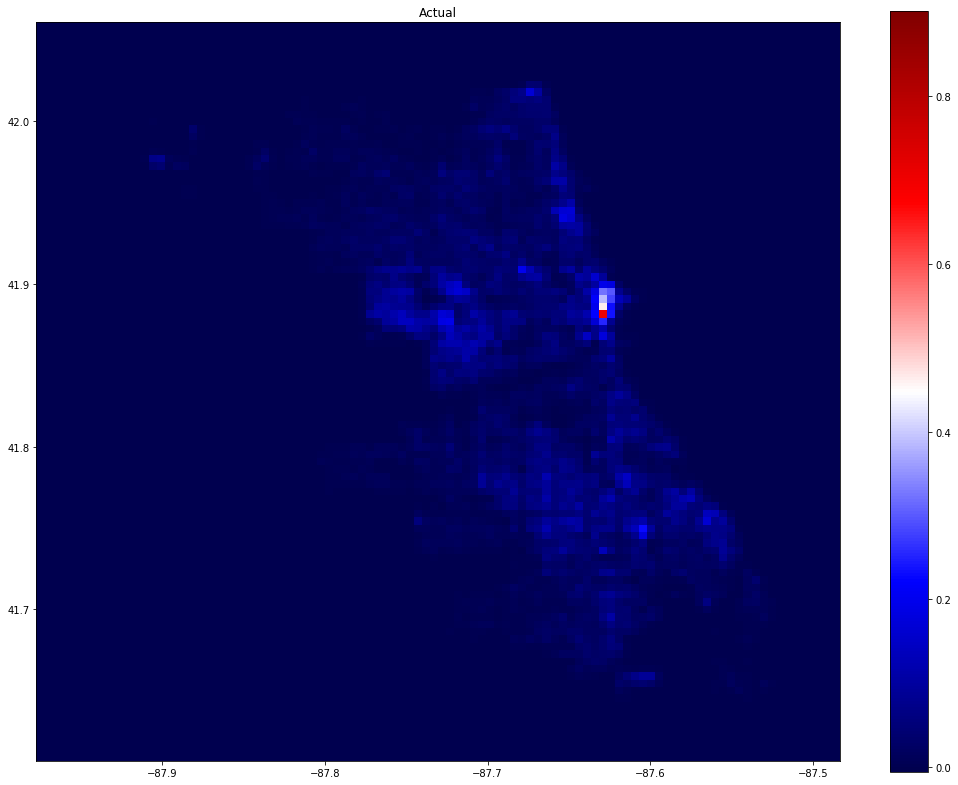

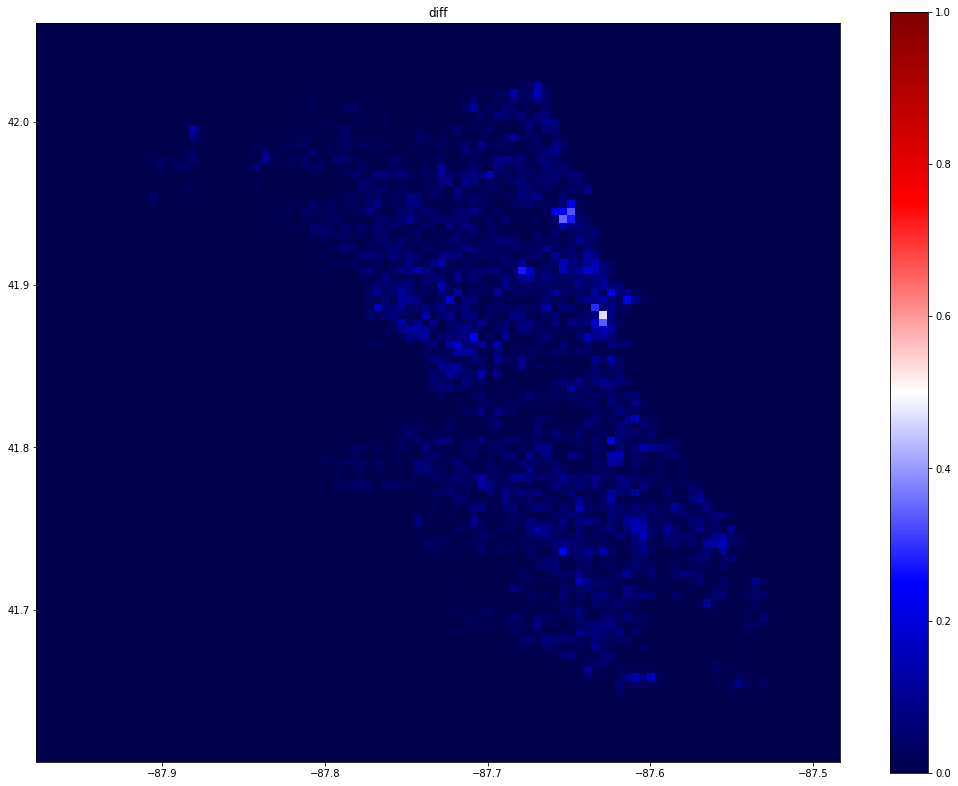

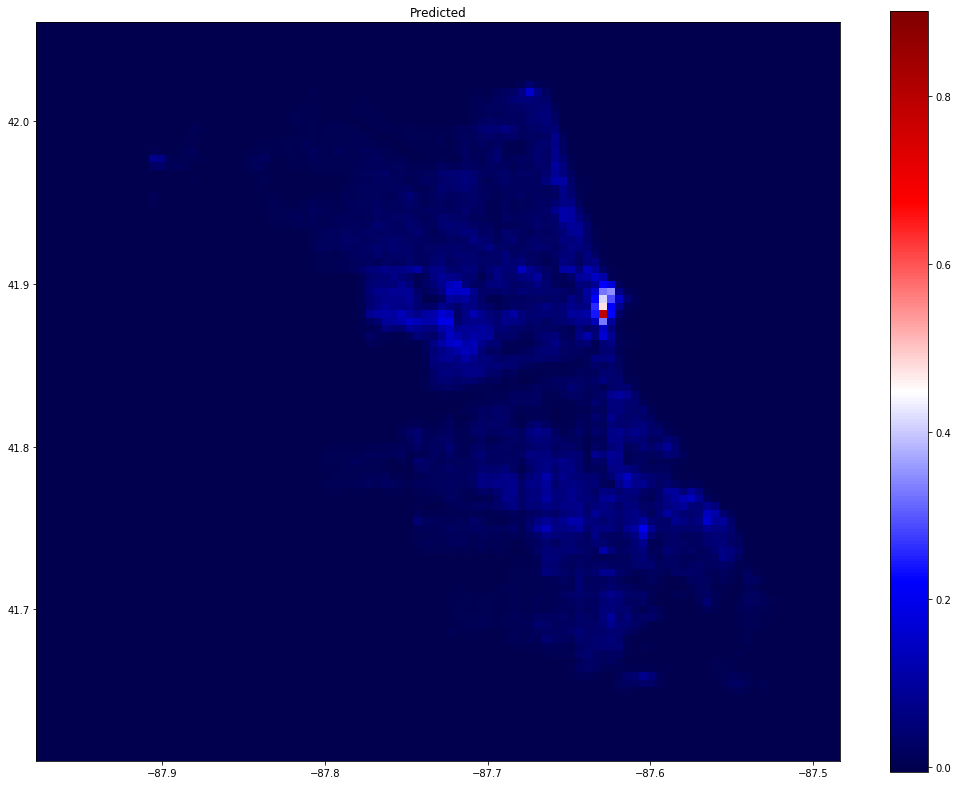

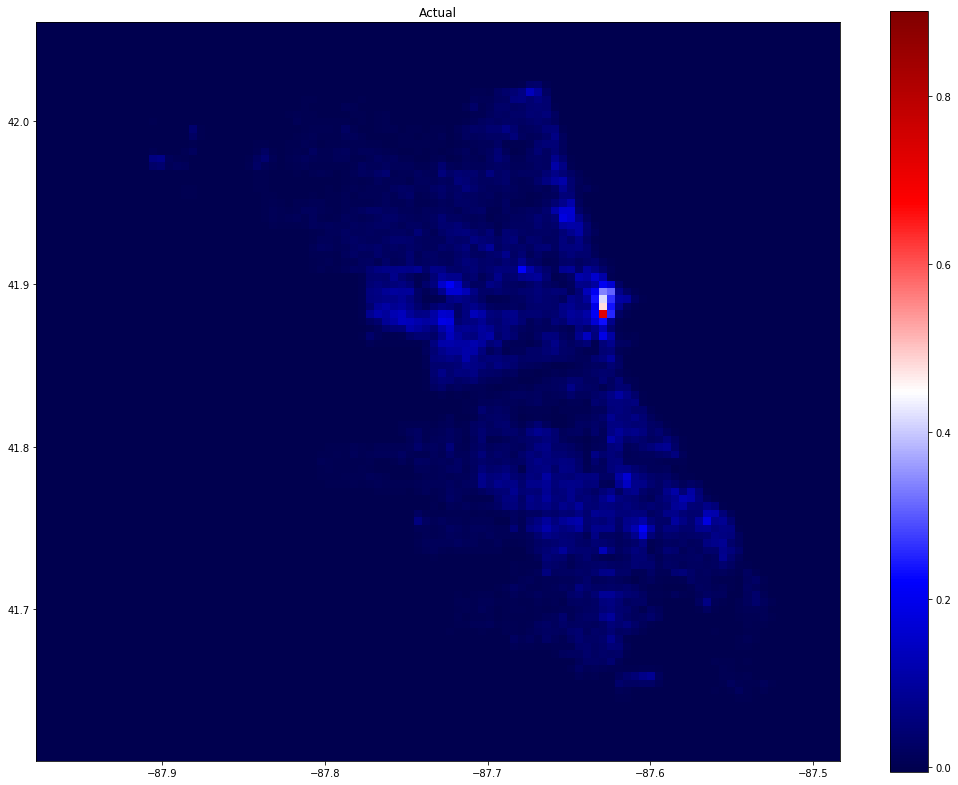

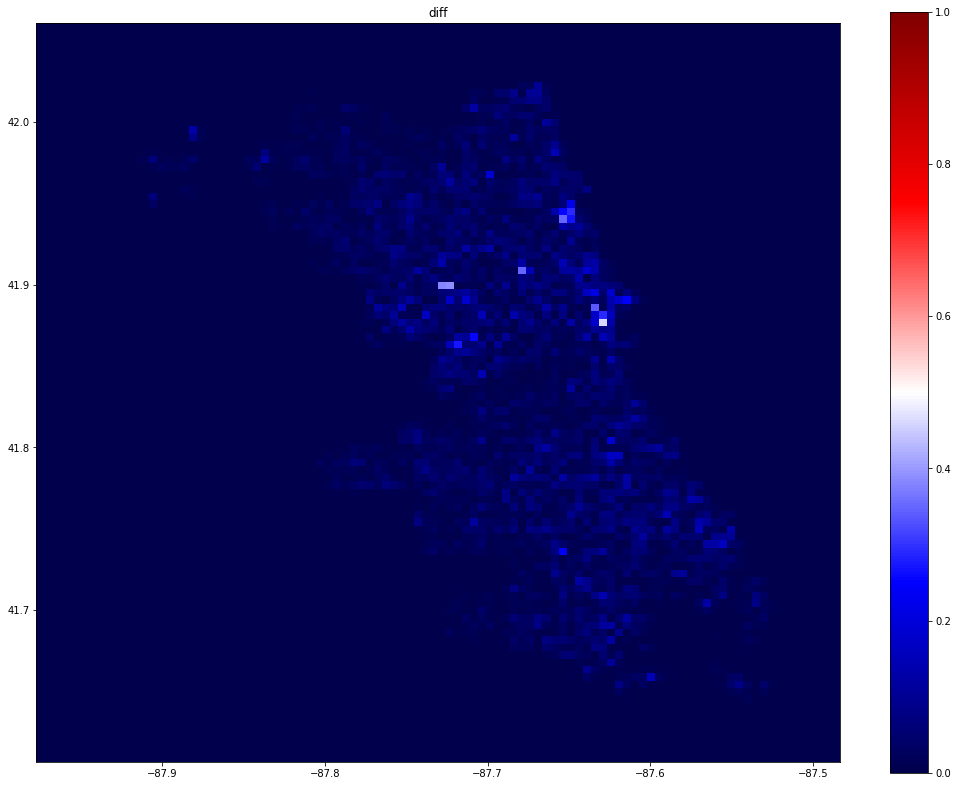

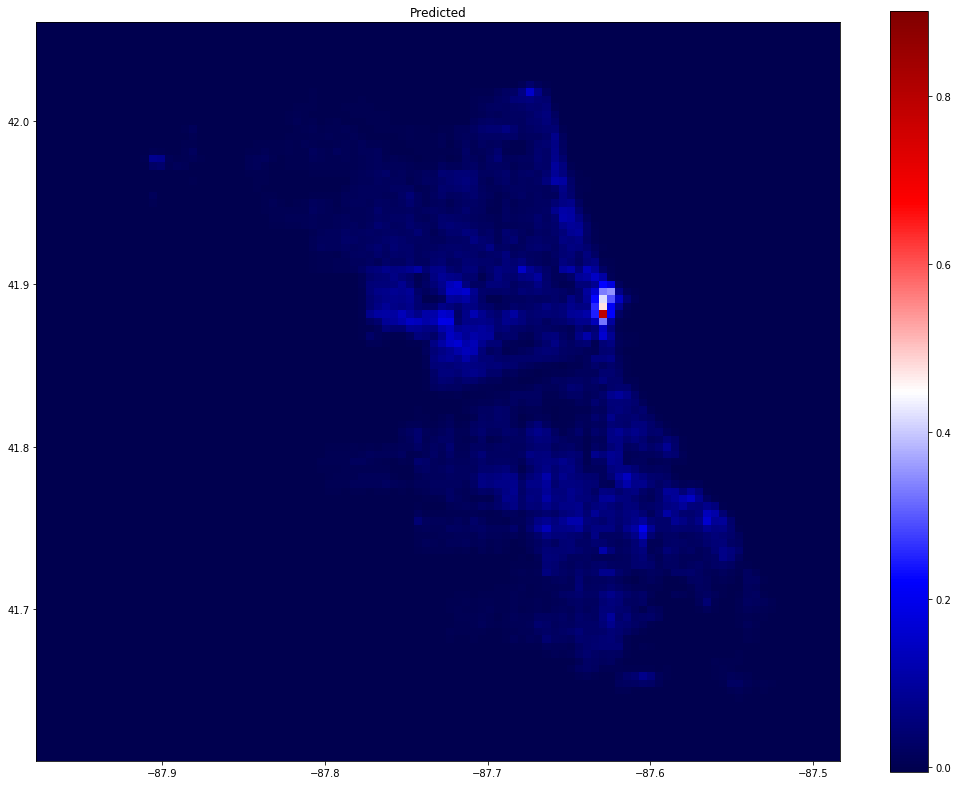

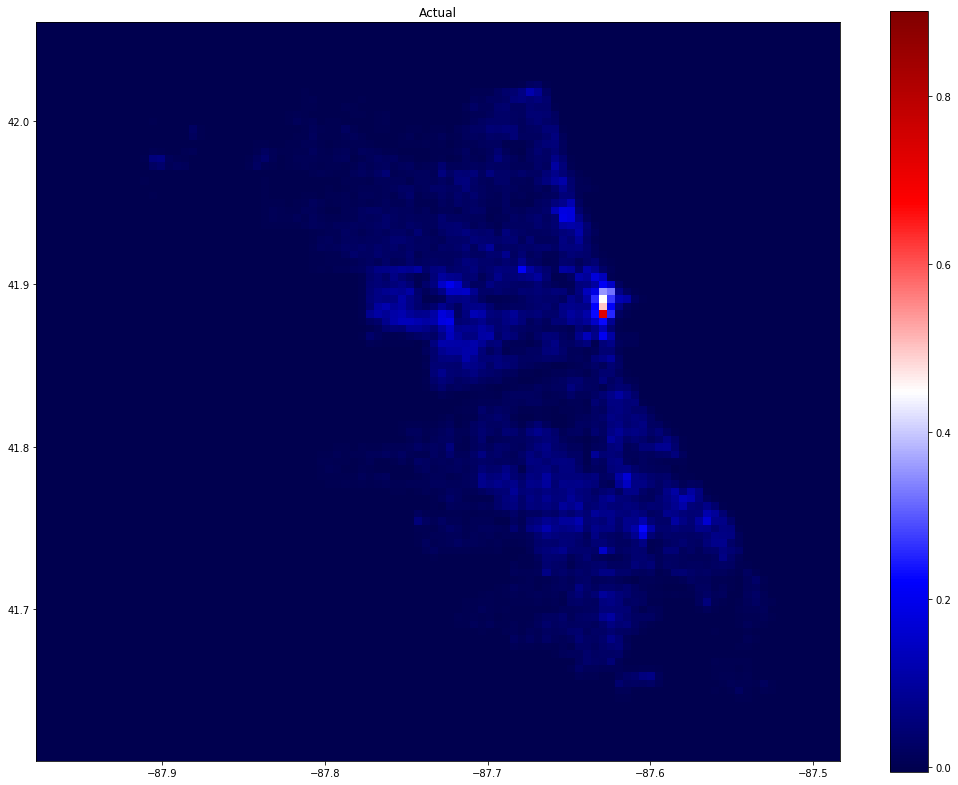

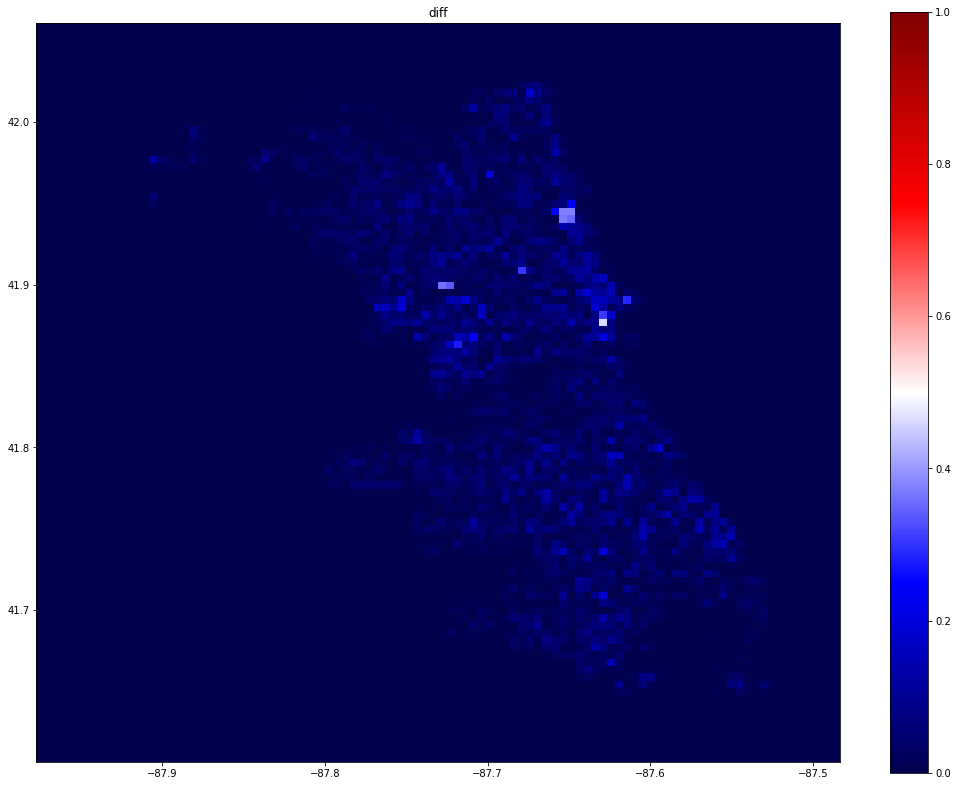

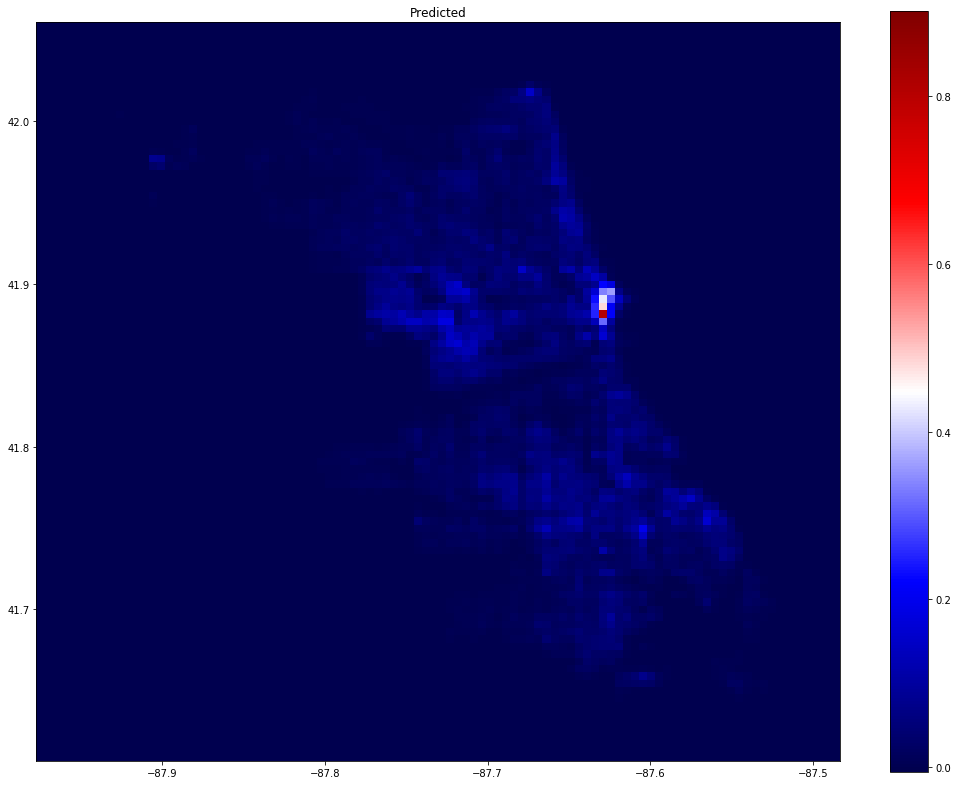

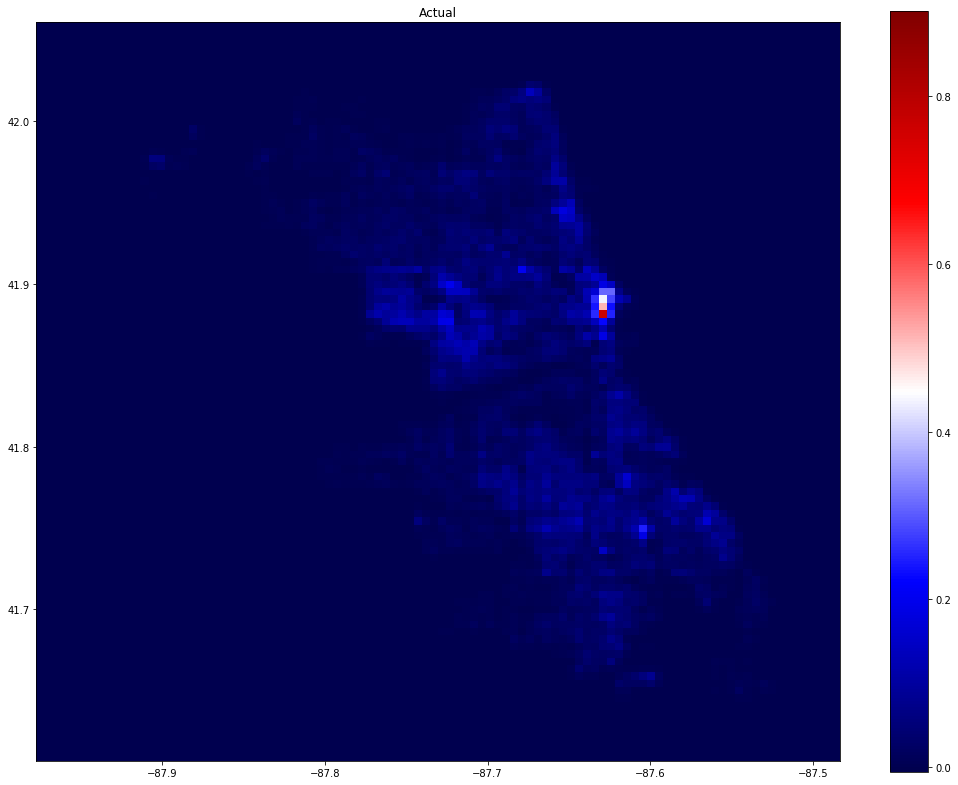

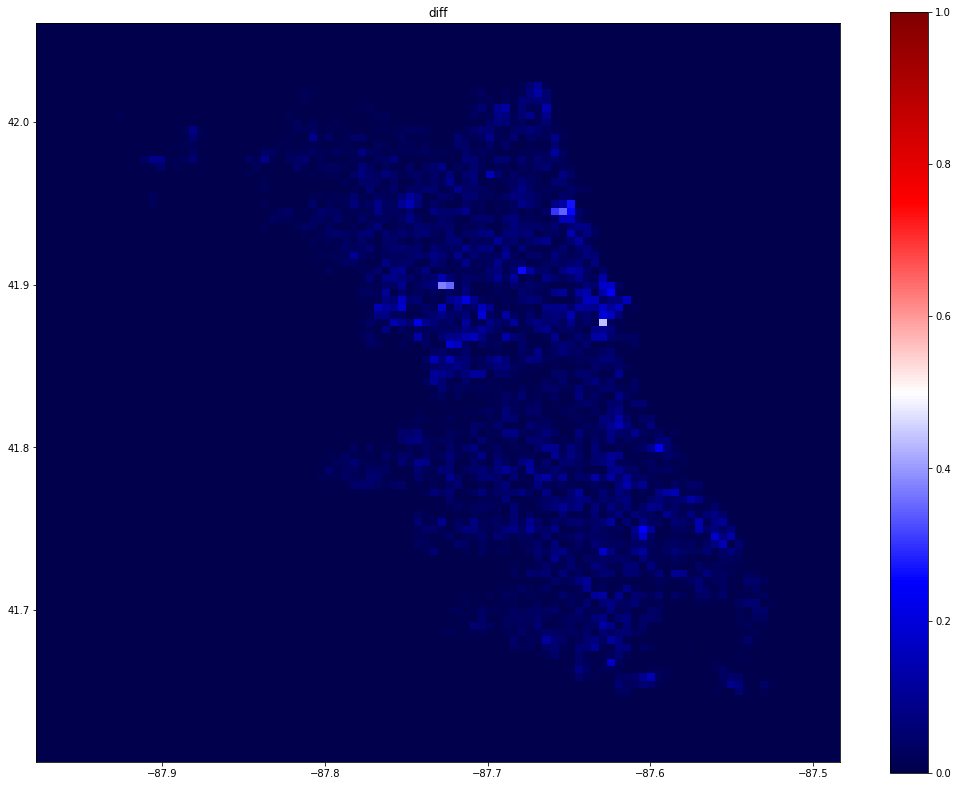

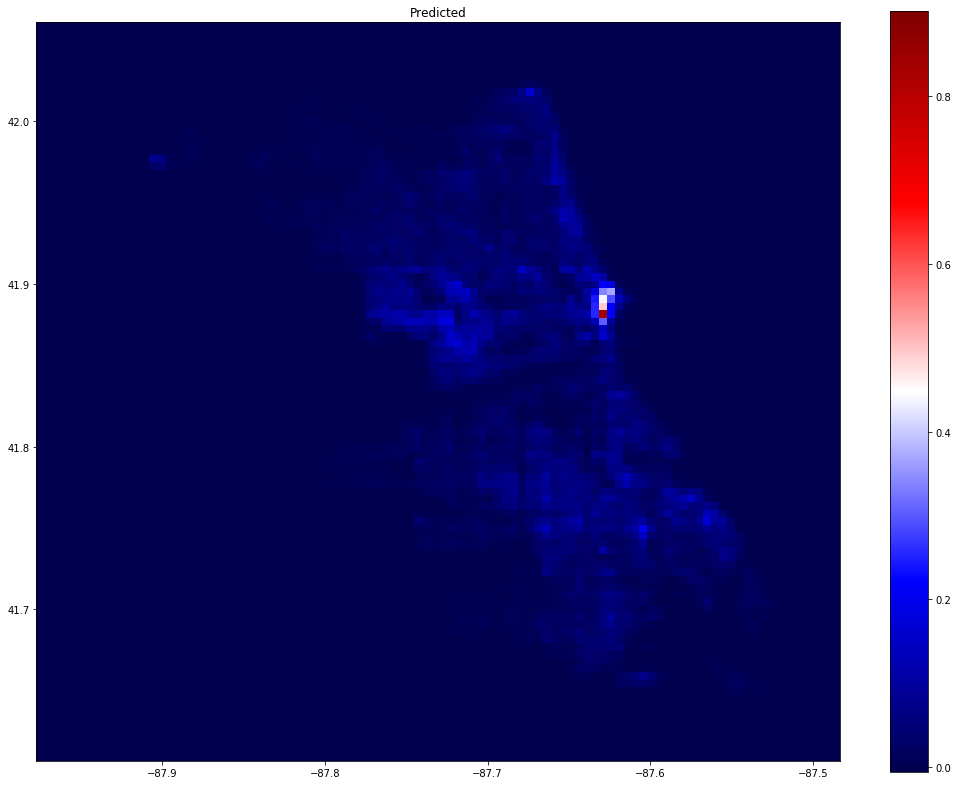

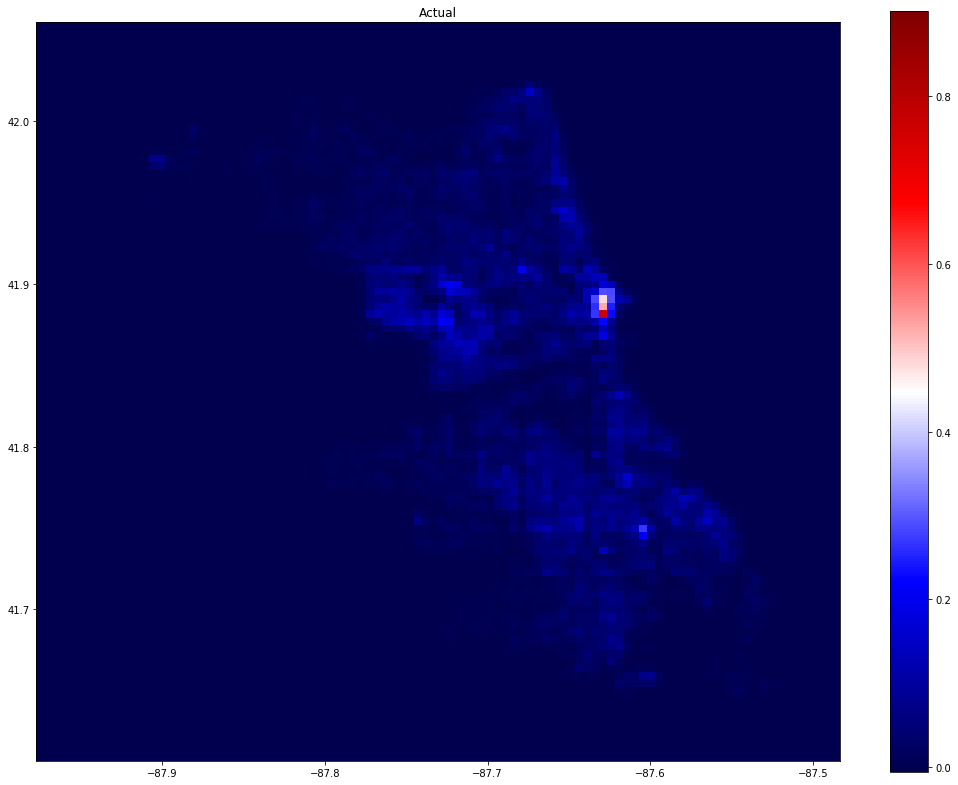

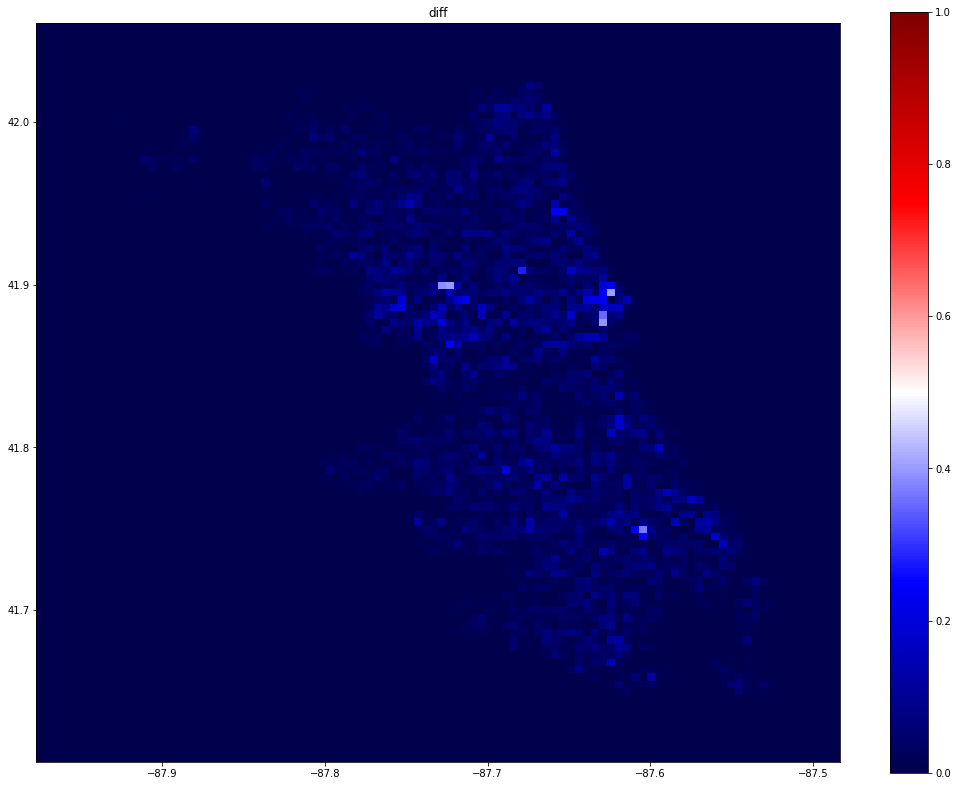

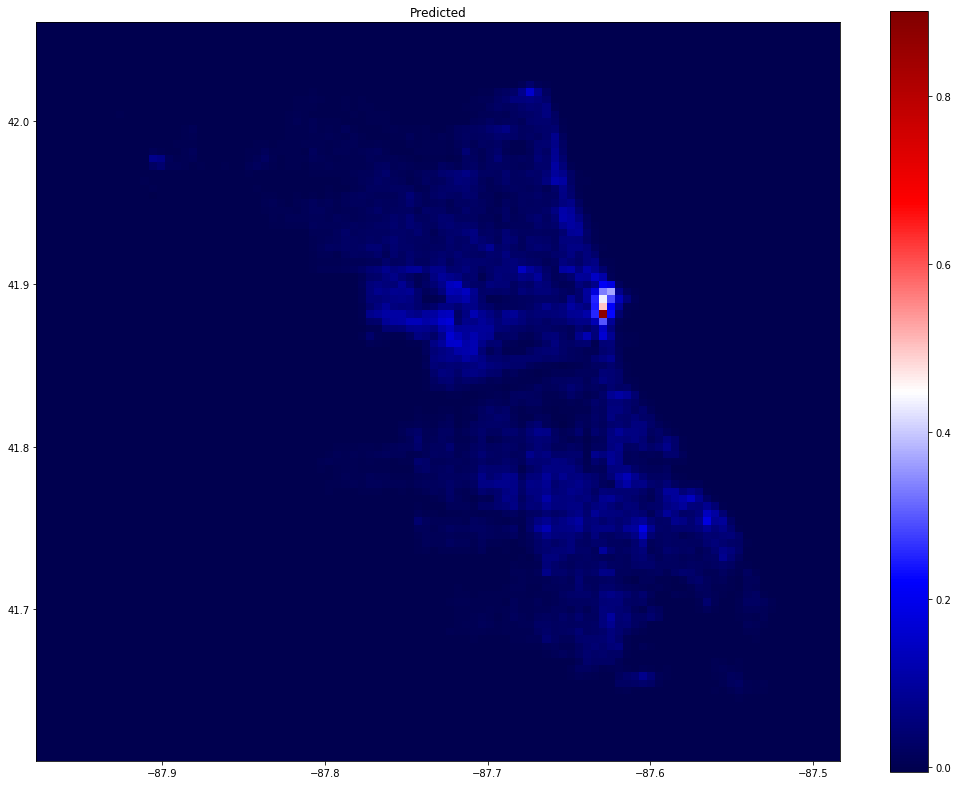

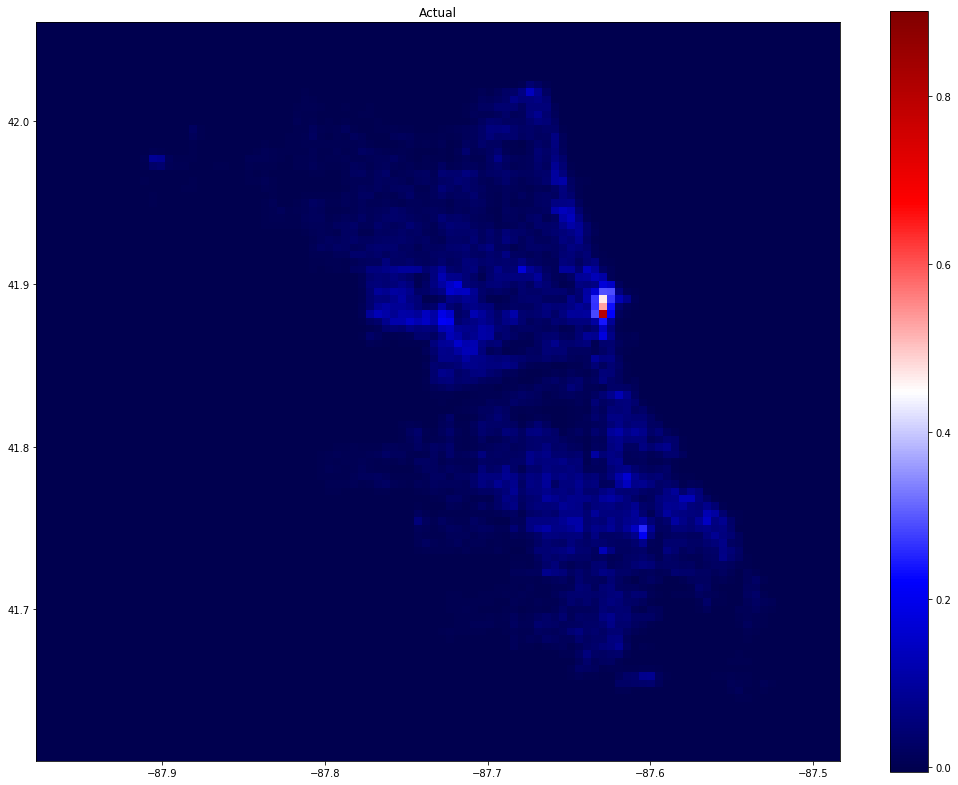

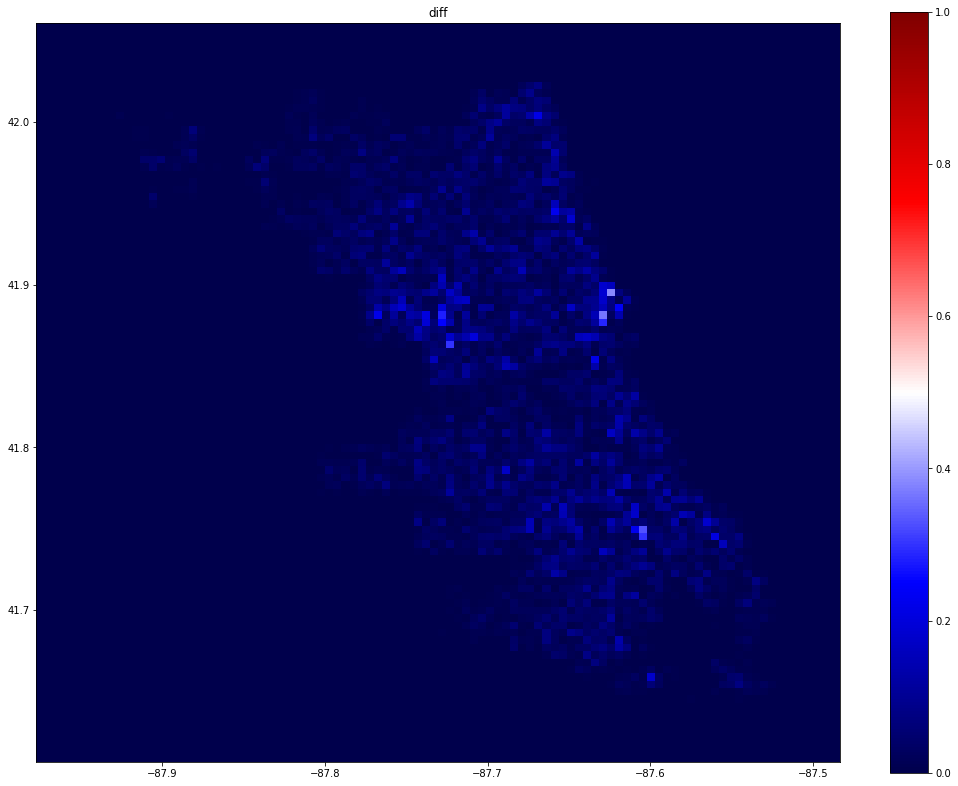

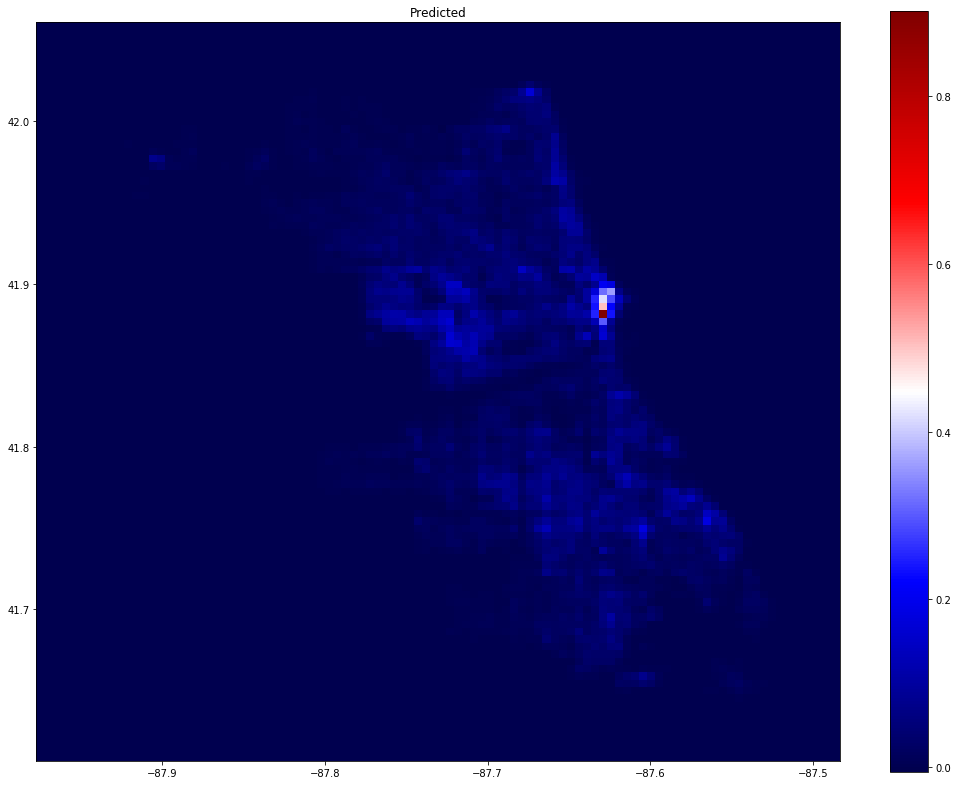

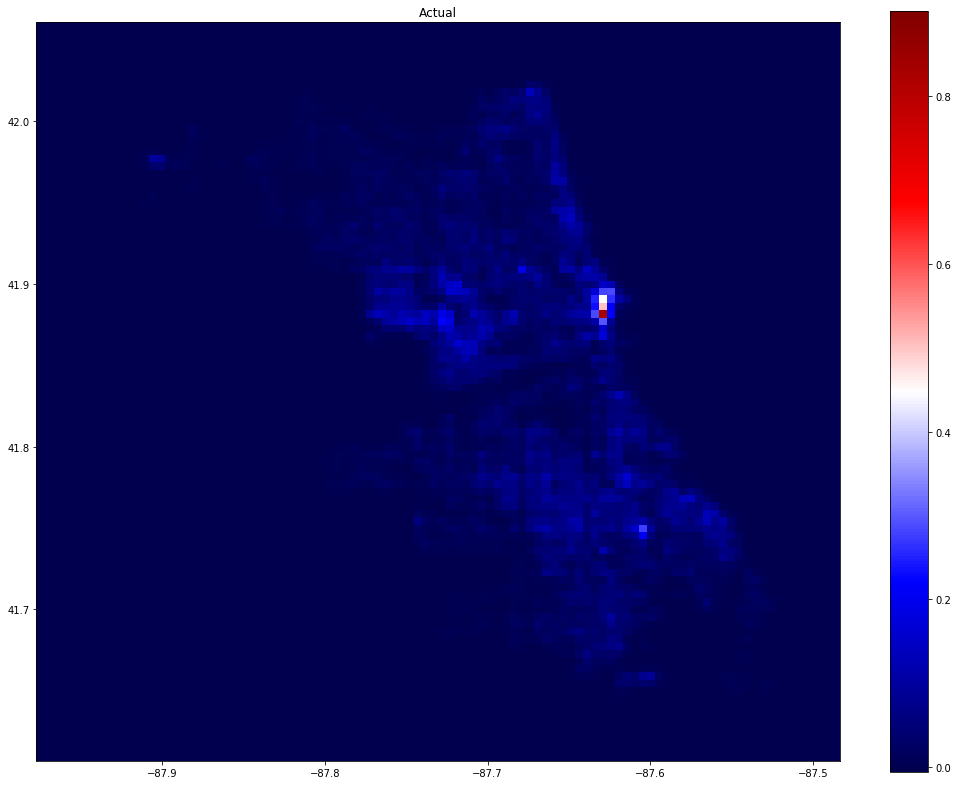

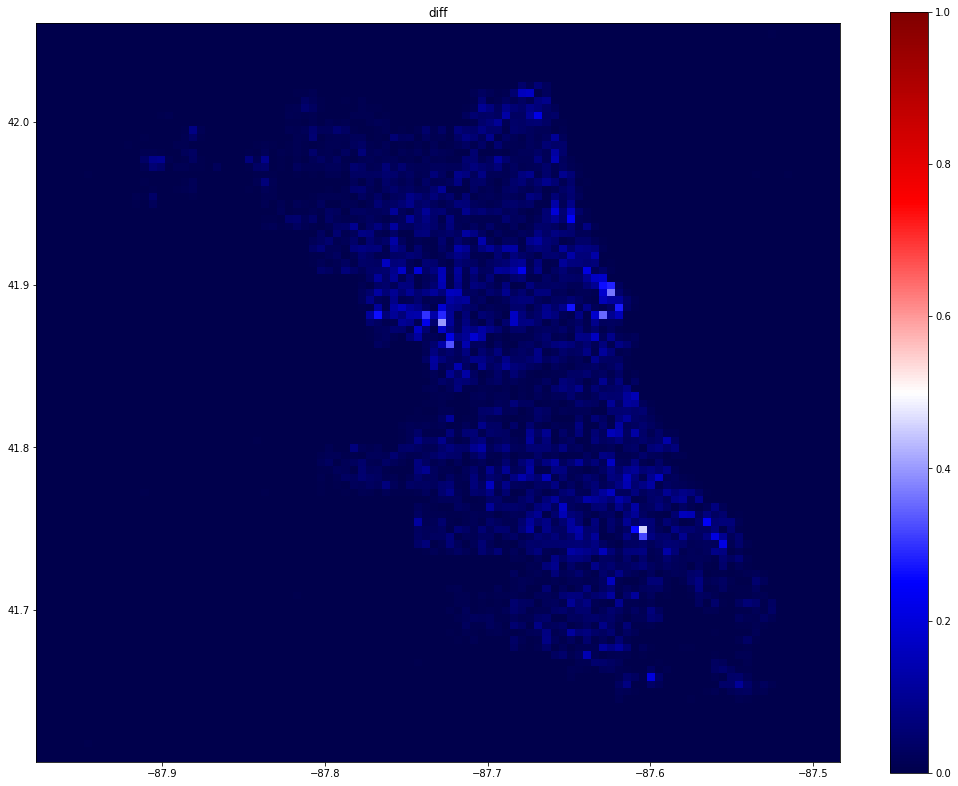

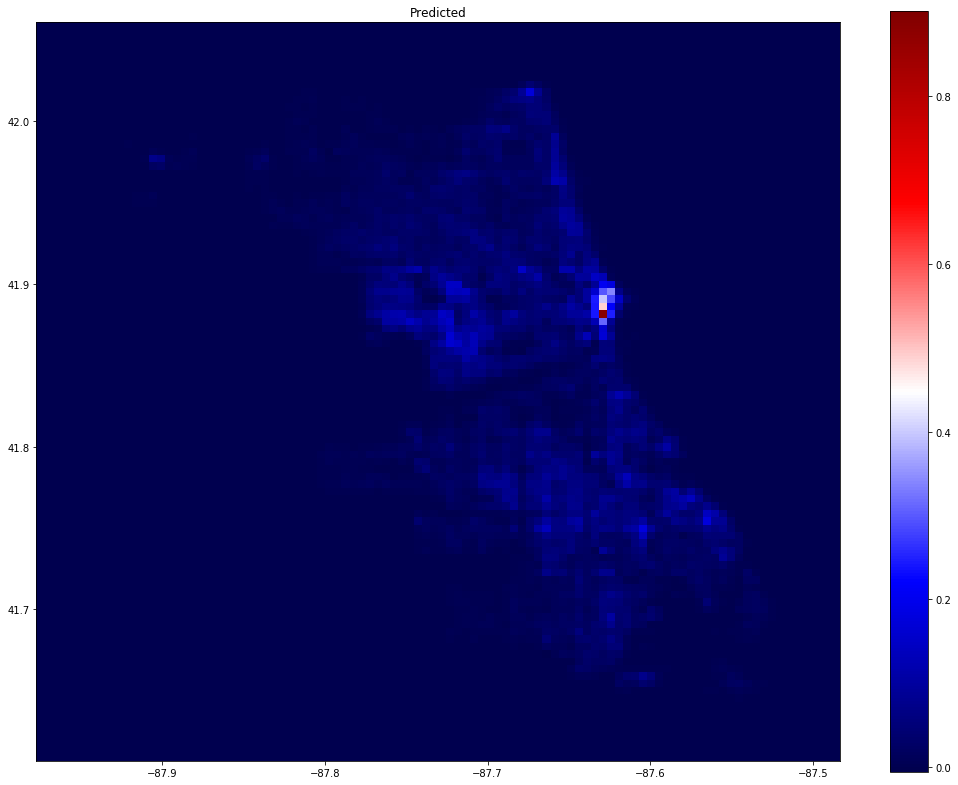

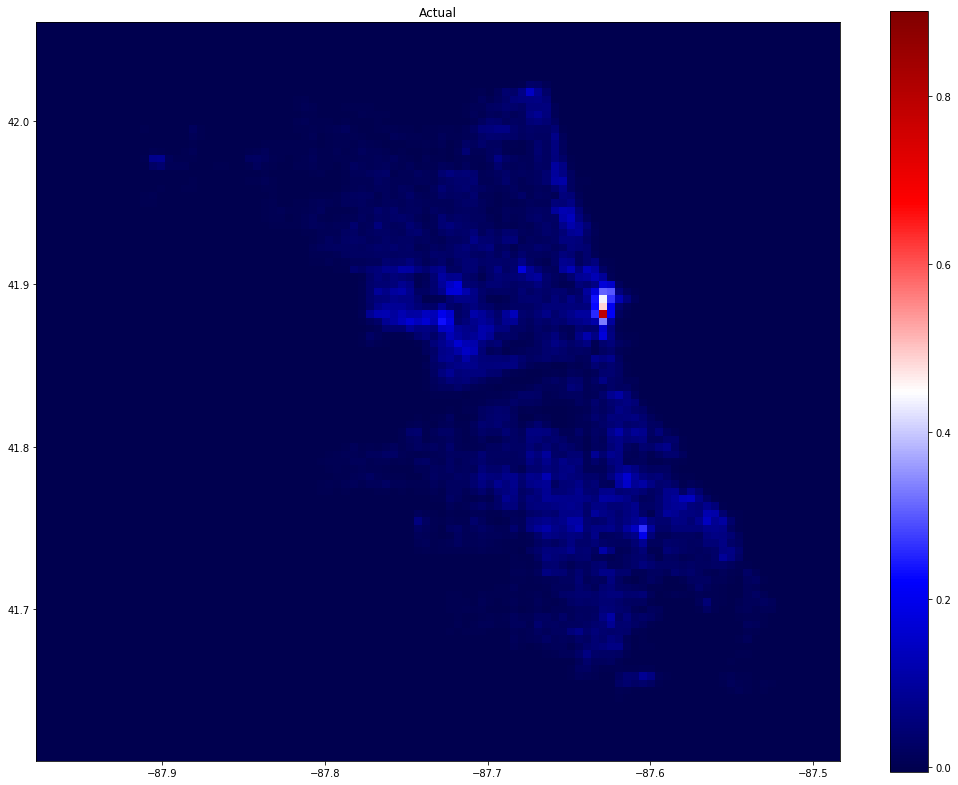

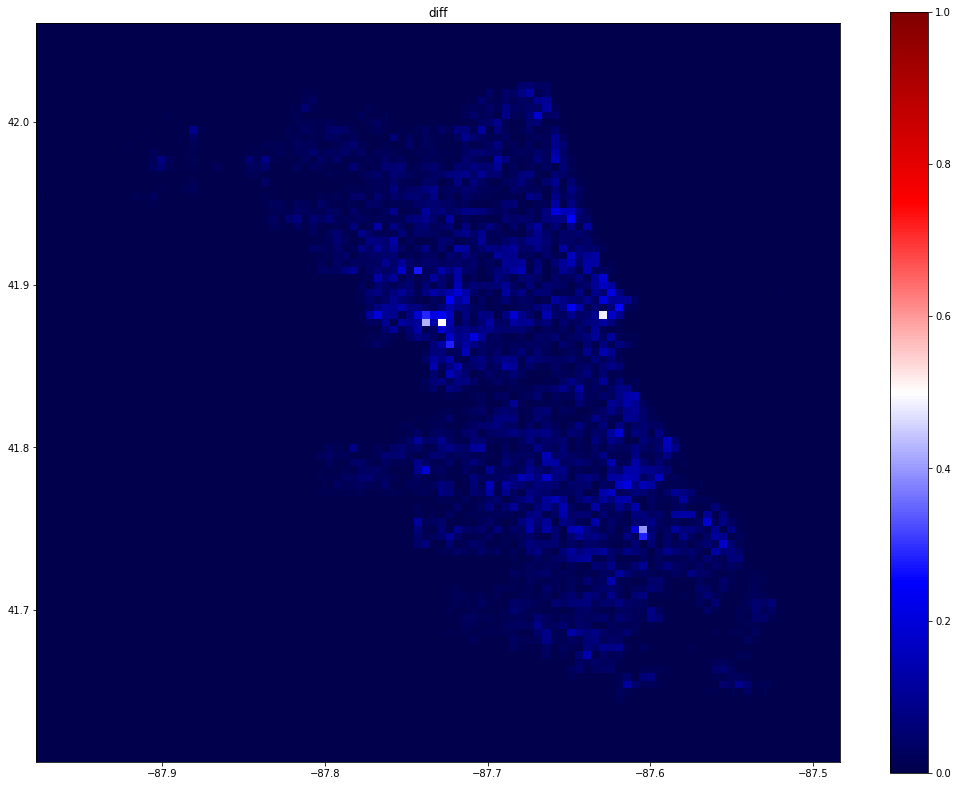

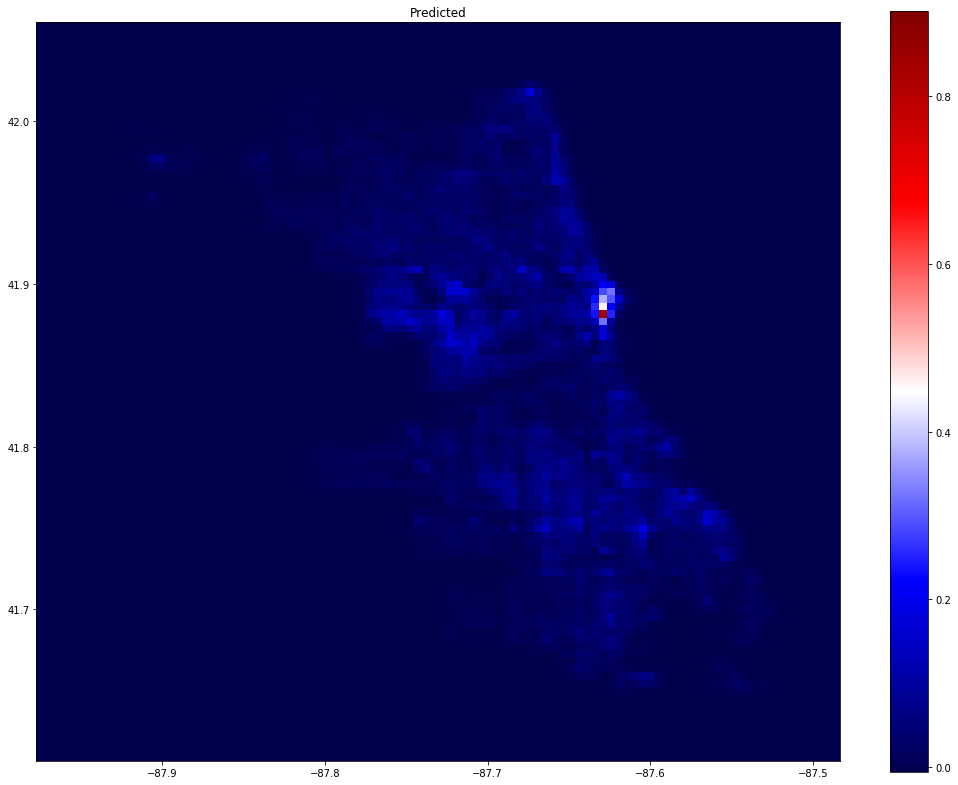

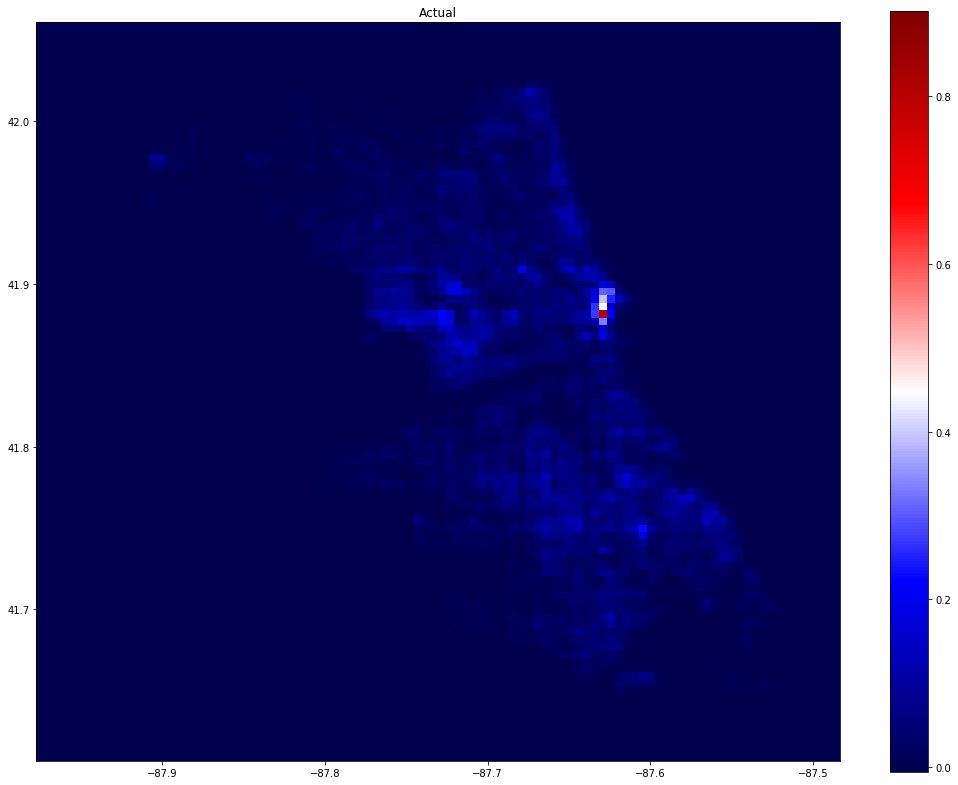

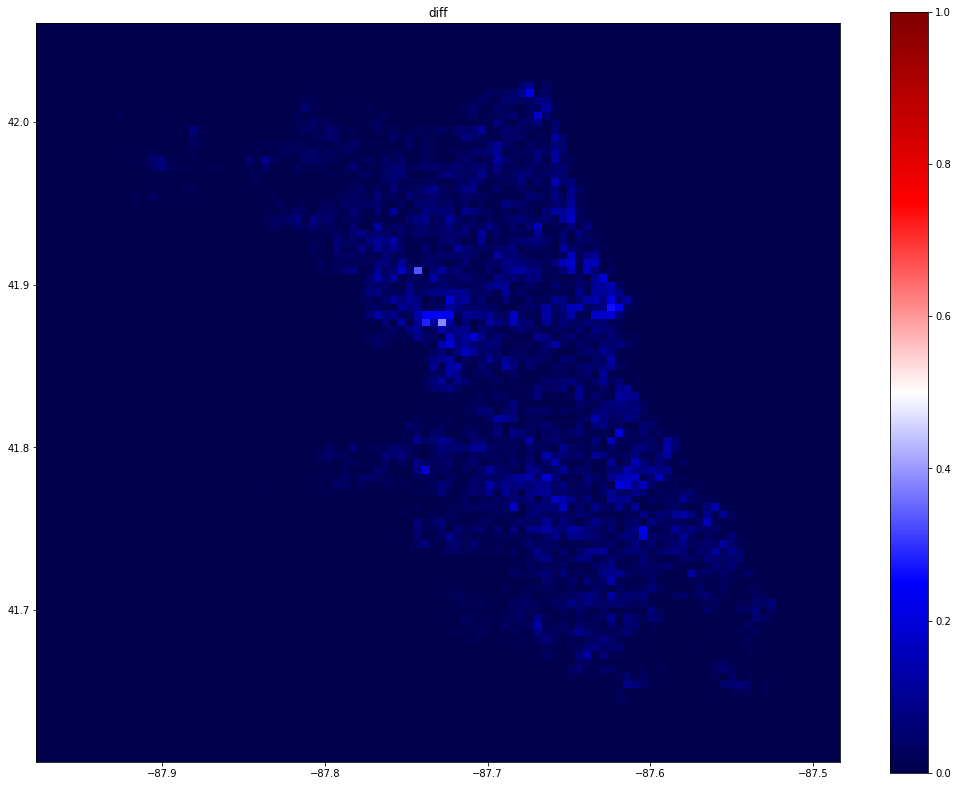

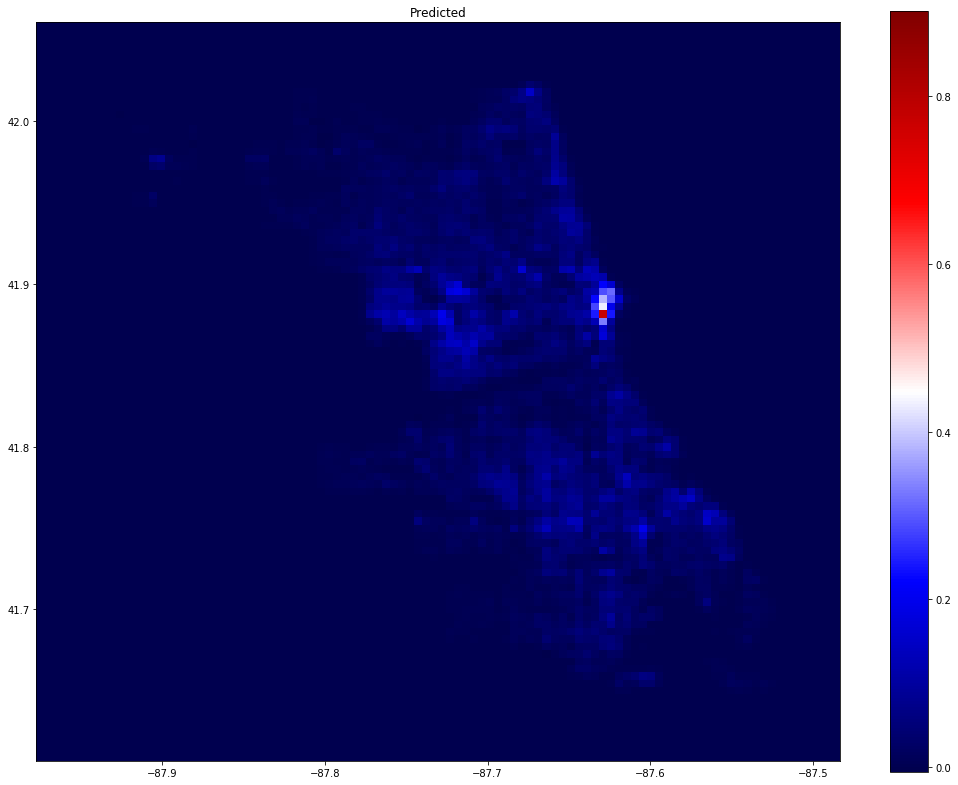

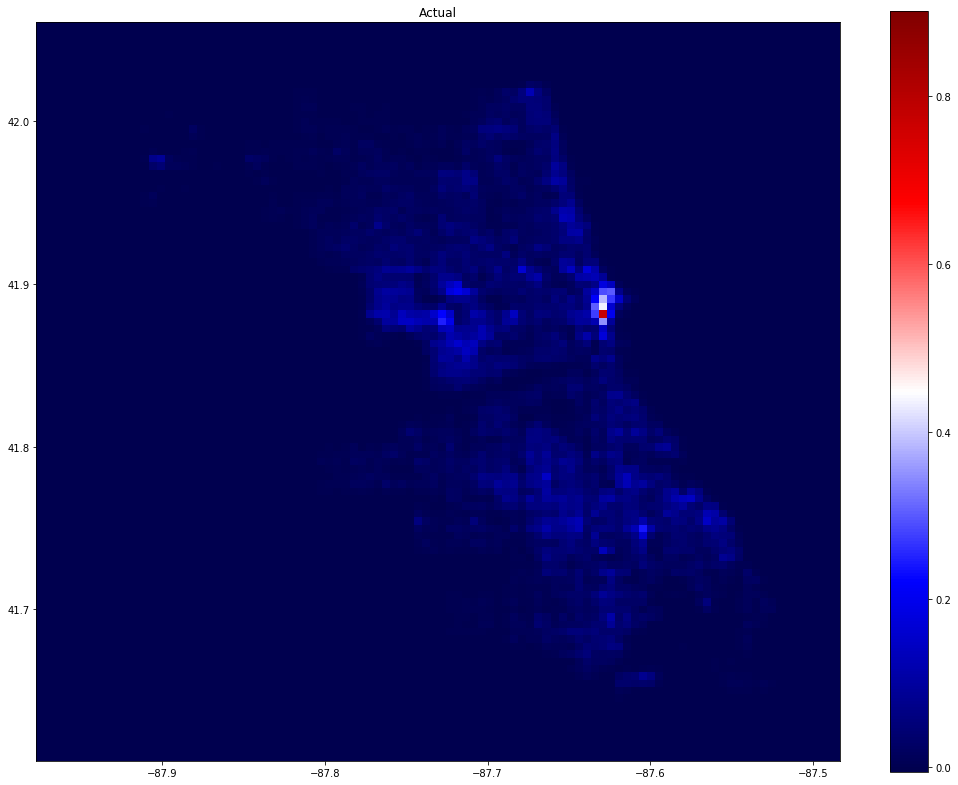

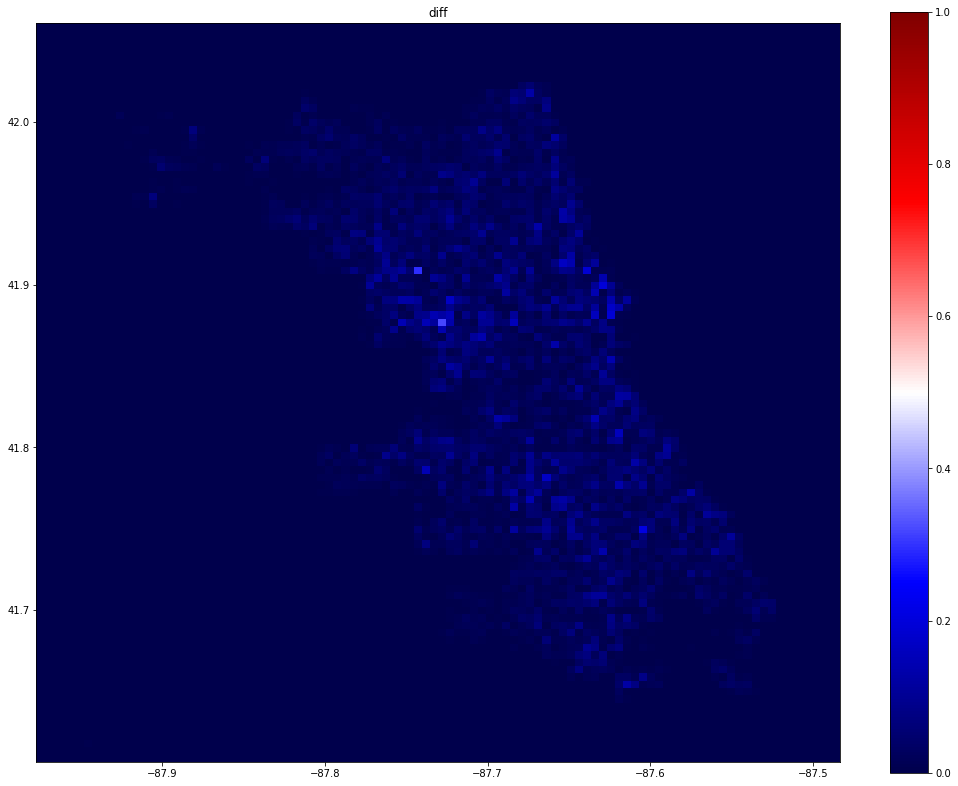

In [61]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepFromLast in range(Y_valid.shape[0]):
    plt.figure(figsize=(18, 14))
    plt.title('Predicted')
    plt.imshow( X=reshapePred(Predict,timeStepFromLast),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    plt.figure(figsize=(18, 14))
    plt.title('Actual')
    plt.imshow( X=reshapePred(Y_valid,timeStepFromLast ),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    diff = np.abs(reshapePred(Predict,timeStepFromLast)-reshapePred(Y_valid,timeStepFromLast ))
    plt.figure(figsize=(18, 14))
    plt.title('diff')
    plt.imshow( X=scaleDiff(diff,diff_max,diff_min),vmax=1,vmin=0, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()

#### We plot the single pixel with the most dense in crime KDE

#### We observe the model is simply averaging when change in crime density in volatile

In [396]:
Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]

array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
       -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
       -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
       -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
        0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
        0.06236299, -0.01036096])

In [397]:
[Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]
 ,Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]]

[array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
        -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
        -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
        -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
         0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
         0.06236299, -0.01036096]),
 array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
        -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
        -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
        -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
         0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
         0.06236299, -0.01036096])]

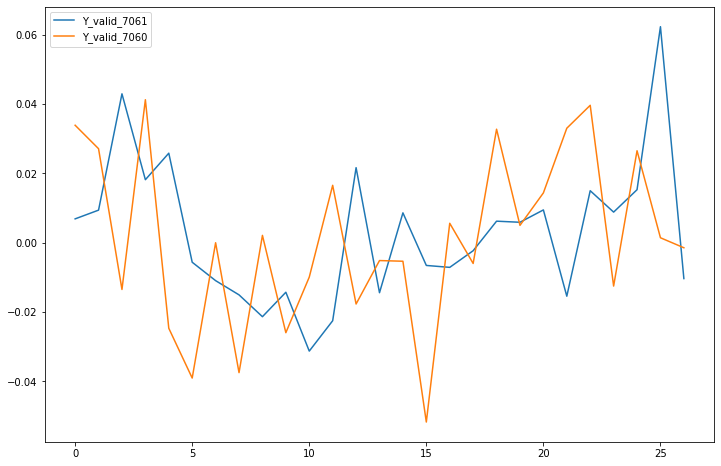

In [398]:
pd.DataFrame(np.transpose(np.vstack([Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1],Y_valid[:,i][1:]-Y_valid[:,i][0:-1]])),columns=["Y_valid_"+str(i+1),"Y_valid_"+str(i)]).plot(figsize=(12,8))

In [399]:
for i in range(Predict.shape[0]-1):
    diff_ts = Predict[i,:] - Predict[i+1,:]
    print(np.sum(diff_ts[np.argsort(diff_ts)]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


#### We plot the difference between prediction and target

In [400]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [401]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [402]:
np.max(scaled_diff)

1.0

In [403]:
diff

array([[ 1.81296491e-06, -5.77185665e-06, -1.81296491e-06, ...,
        -5.25021732e-08,  1.81296491e-06, -5.77185665e-06],
       [ 1.81296491e-06,  5.25021734e-08, -1.81296491e-06, ...,
        -1.81296491e-06,  5.24621556e-08,  5.77185665e-06],
       [ 1.81296491e-06,  5.24621556e-08, -5.25021732e-08, ...,
        -1.81296491e-06,  5.24621556e-08, -5.77185665e-06],
       ...,
       [ 5.24621556e-08,  1.02341037e-05,  1.81296491e-06, ...,
         1.02341037e-05, -5.24621554e-08, -1.81296491e-06],
       [ 1.02341037e-05, -1.81296491e-06, -5.77185665e-06, ...,
        -5.24621554e-08,  1.02341037e-05, -1.81296491e-06],
       [-1.81296491e-06,  5.77185665e-06,  1.81296491e-06, ...,
        -5.77185665e-06,  1.02341037e-05,  1.81296491e-06]])

In [404]:
vmax, vmin = np.max(scaled_diff), np.min(scaled_diff)

In [405]:
vmax, vmin 

(1.0, 0.0)

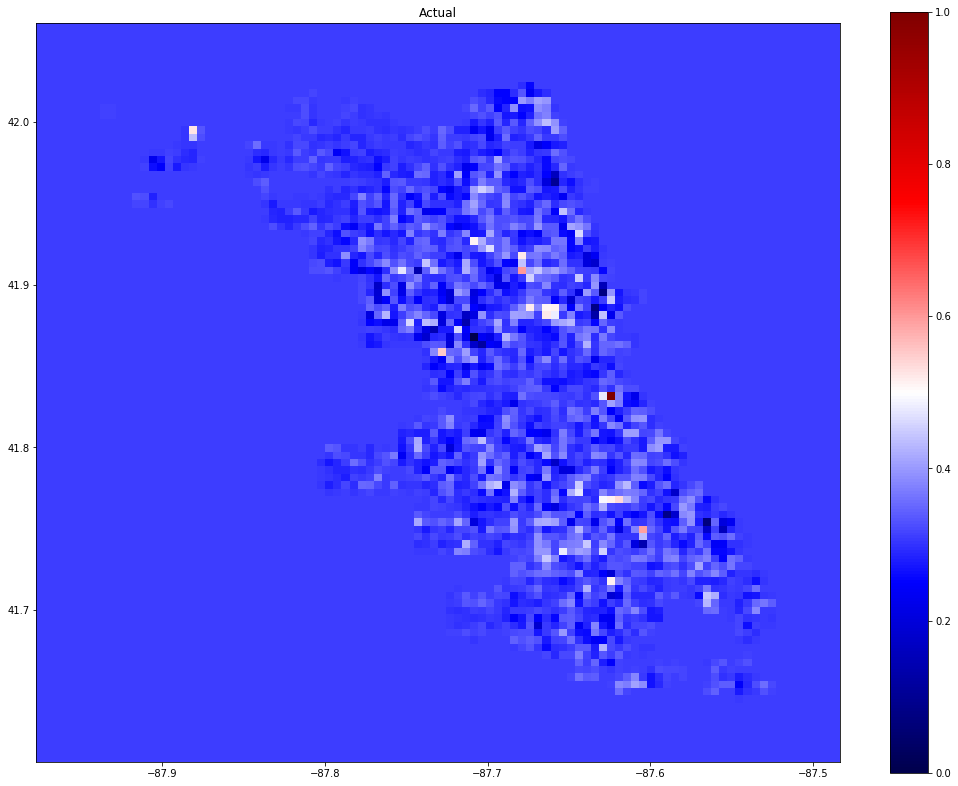

In [68]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff,vmax=vmax, vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.

#### Tensor Flow test

In [227]:
array1 = np.array([[[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 12, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 29]],])

In [232]:
array2 = (array1 + 2)*2

In [233]:
array2

array([[[ 4,  6,  8, 10, 12],
        [14, 16, 18, 20, 22]],

       [[24, 26, 28, 30, 32],
        [34, 36, 38, 40, 42]],

       [[44, 46, 48, 50, 52],
        [54, 56, 58, 60, 62]]])

In [235]:
rank_3_tensor1 = tf.constant(array1)
rank_3_tensor2 = tf.constant(array2)
                    
print(rank_3_tensor1)
print(rank_3_tensor2)

tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int64)
tf.Tensor(
[[[ 4  6  8 10 12]
  [14 16 18 20 22]]

 [[24 26 28 30 32]
  [34 36 38 40 42]]

 [[44 46 48 50 52]
  [54 56 58 60 62]]], shape=(3, 2, 5), dtype=int64)


In [240]:
rank_3_tensor2[0:].shape

TensorShape([3, 2, 5])

In [243]:
rank_3_tensor2 - rank_3_tensor1

<tf.Tensor: shape=(3, 2, 5), dtype=int64, numpy=
array([[[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]],

       [[14, 15, 16, 17, 18],
        [19, 20, 21, 22, 23]],

       [[24, 25, 26, 27, 28],
        [29, 30, 31, 32, 33]]])>

In [241]:
rank_3_tensor2[0:-1] - rank_3_tensor2[1:]

<tf.Tensor: shape=(2, 2, 5), dtype=int64, numpy=
array([[[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]],

       [[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]]])>

In [242]:
tf.math.subtract(rank_3_tensor2[0:-1],rank_3_tensor2[1:])

<tf.Tensor: shape=(2, 2, 5), dtype=int64, numpy=
array([[[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]],

       [[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]]])>

In [304]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mse'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))  
timeDist = TimeDistributed(Flatten())(inputs)
print(timeDist.shape)
diffTime = Lambda(lambda x: x[:,:-1,:]-x[:,1:,:],name='timestep_diff')(timeDist)
print(diffTime.shape)
LSTM_layer1 = LSTM(100)(diffTime)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_diff1lag_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',#'mean_squared_logarithmic_error',
                   metrics=['mse'], 
                   optimizer=adam)



(None, 52, 10000)
(None, 51, 10000)
Model: "Flattened_diff1lag_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
timestep_diff (Lambda)       (None, 51, 10000)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               4040400   
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_45 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_4

(51,)


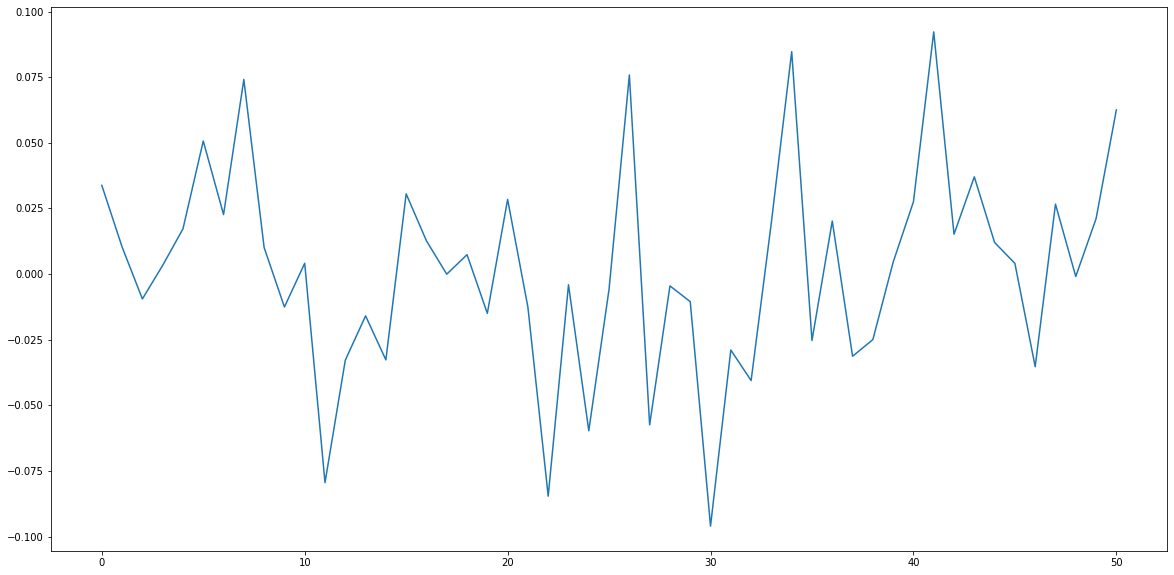

(51,)


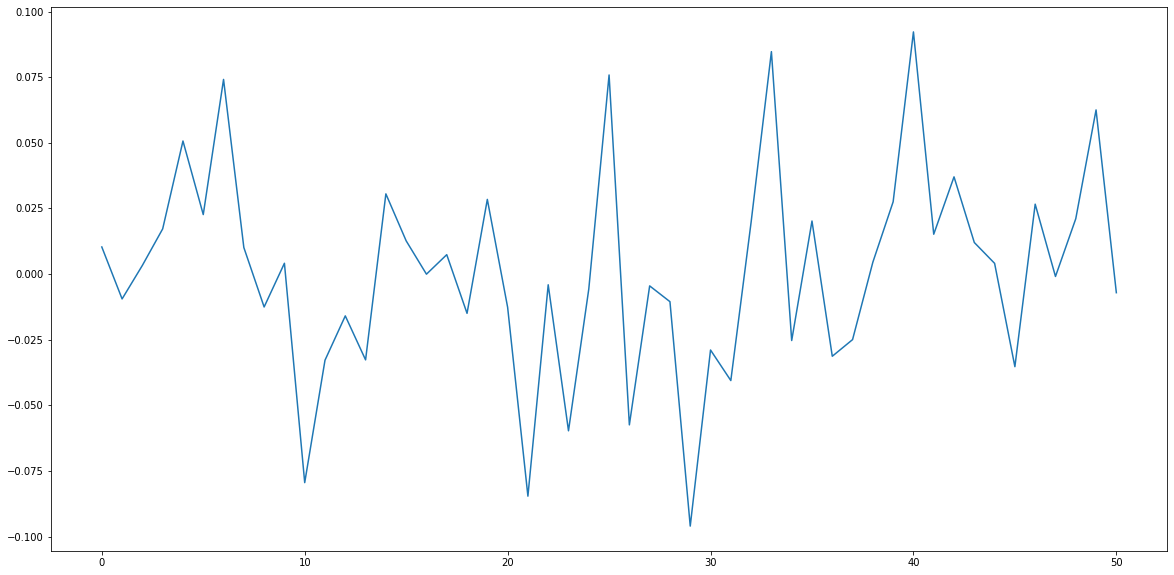

(51,)


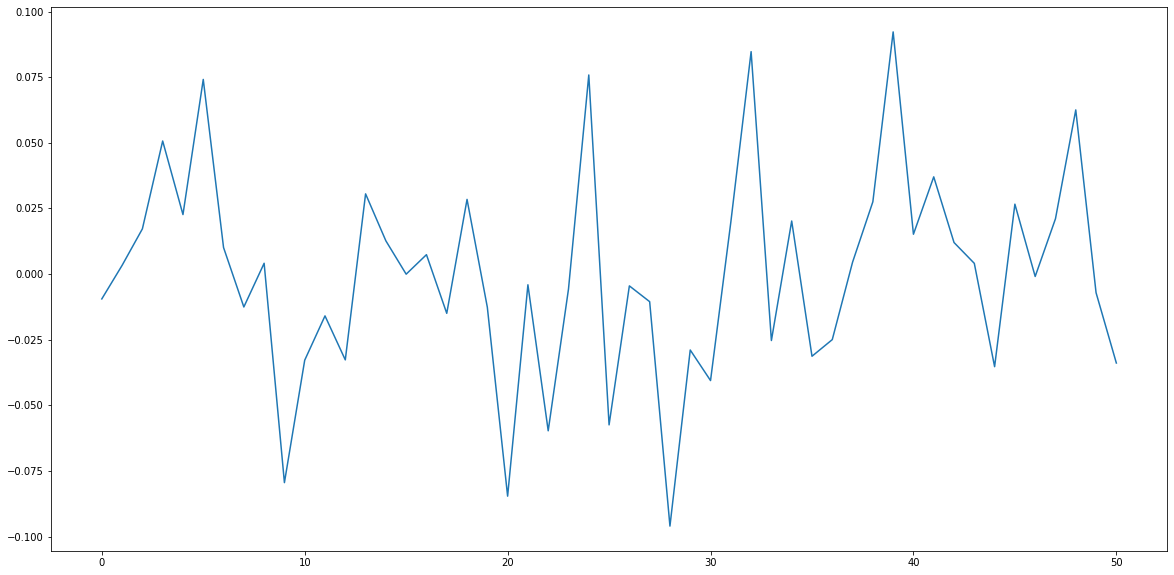

(51,)


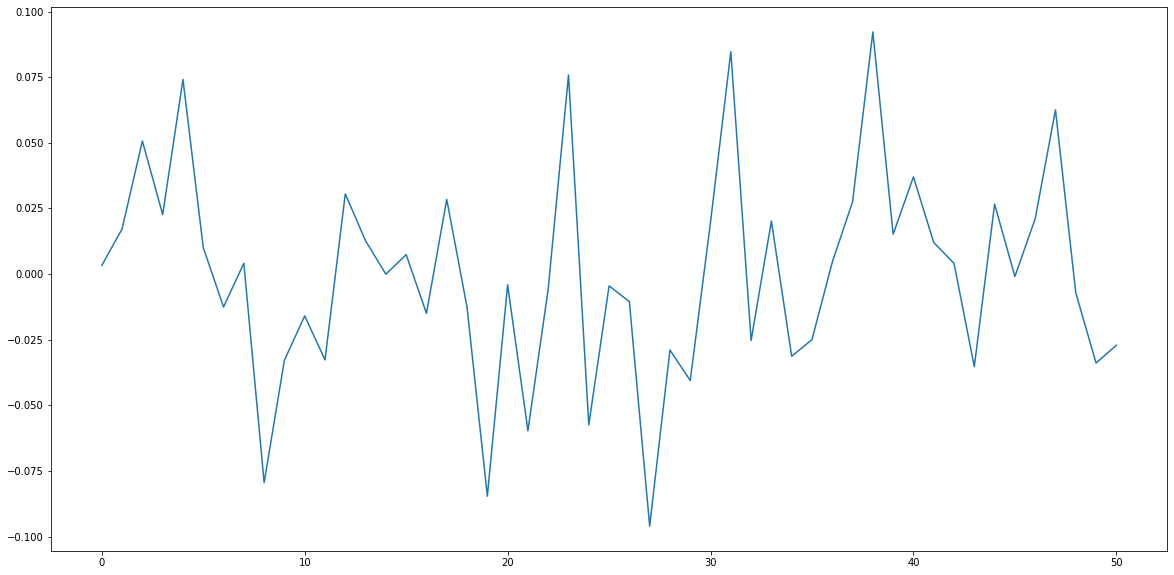

(51,)


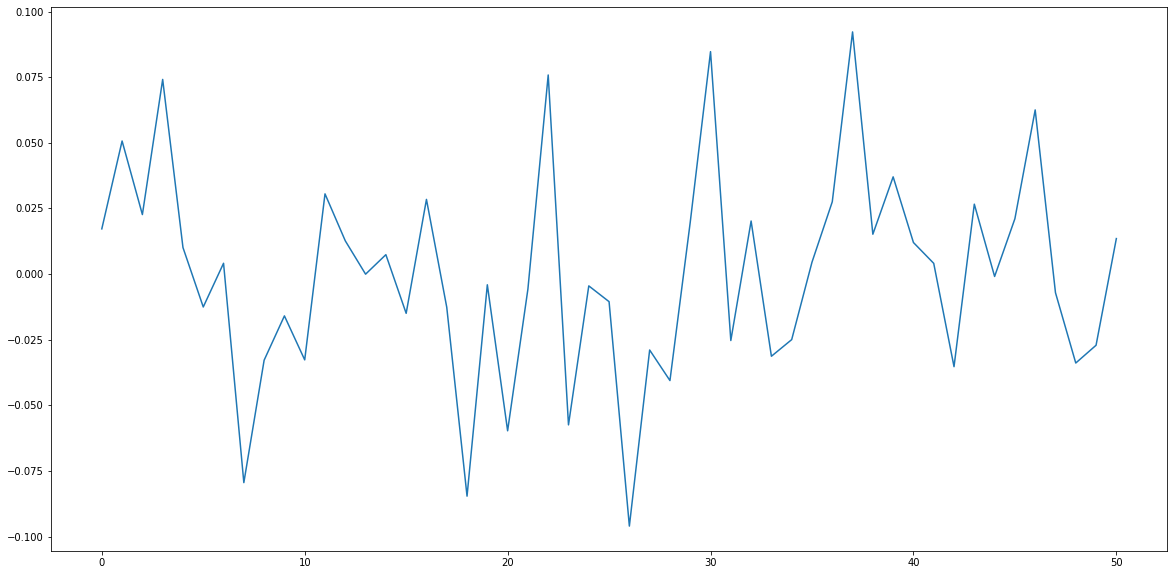

(51,)


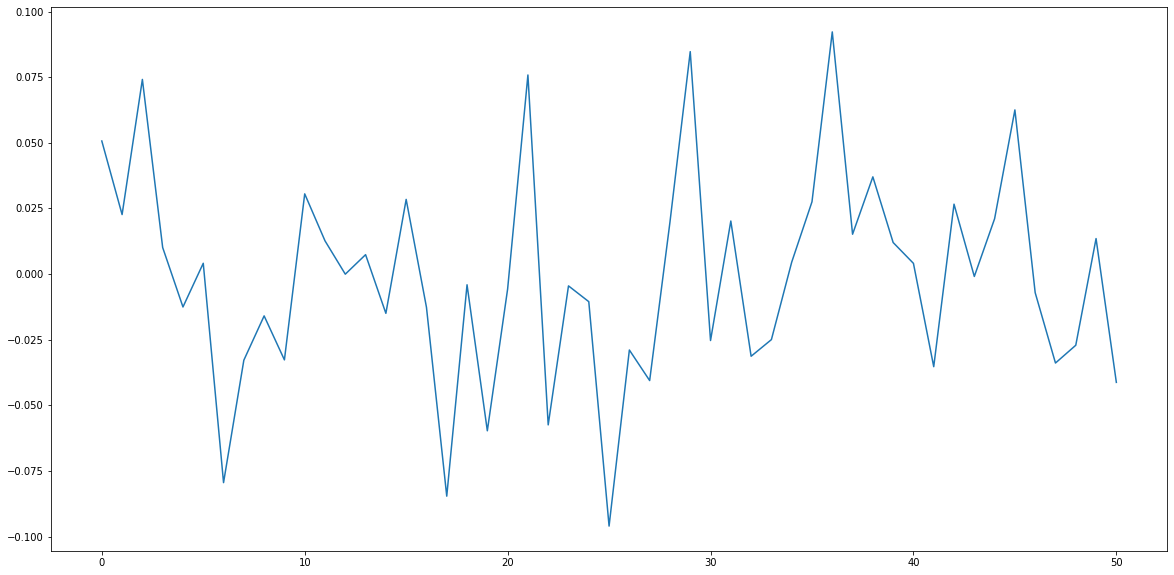

(51,)


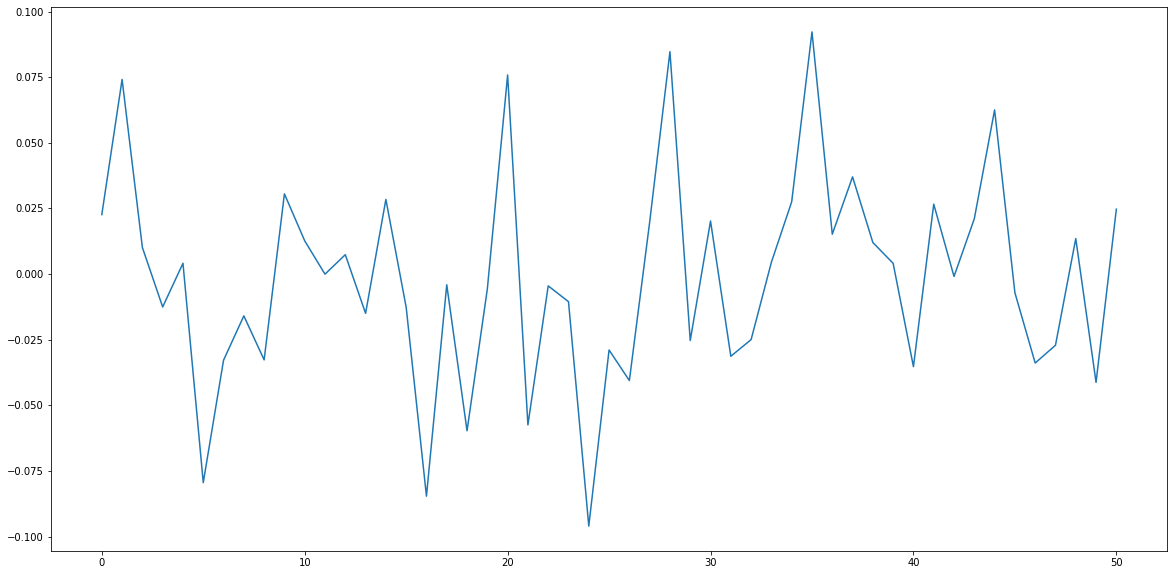

(51,)


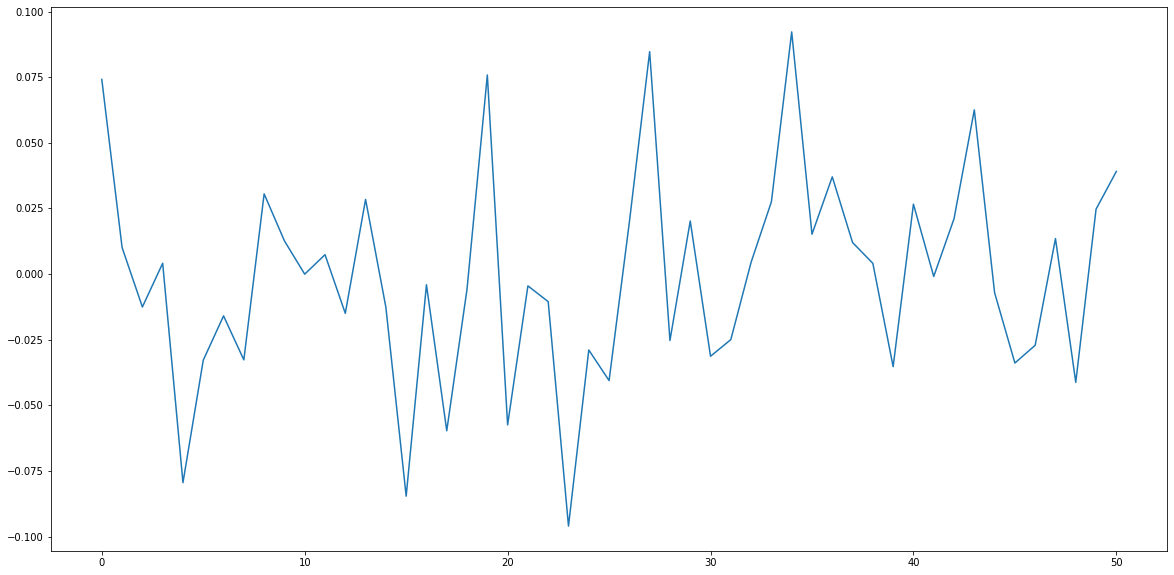

(51,)


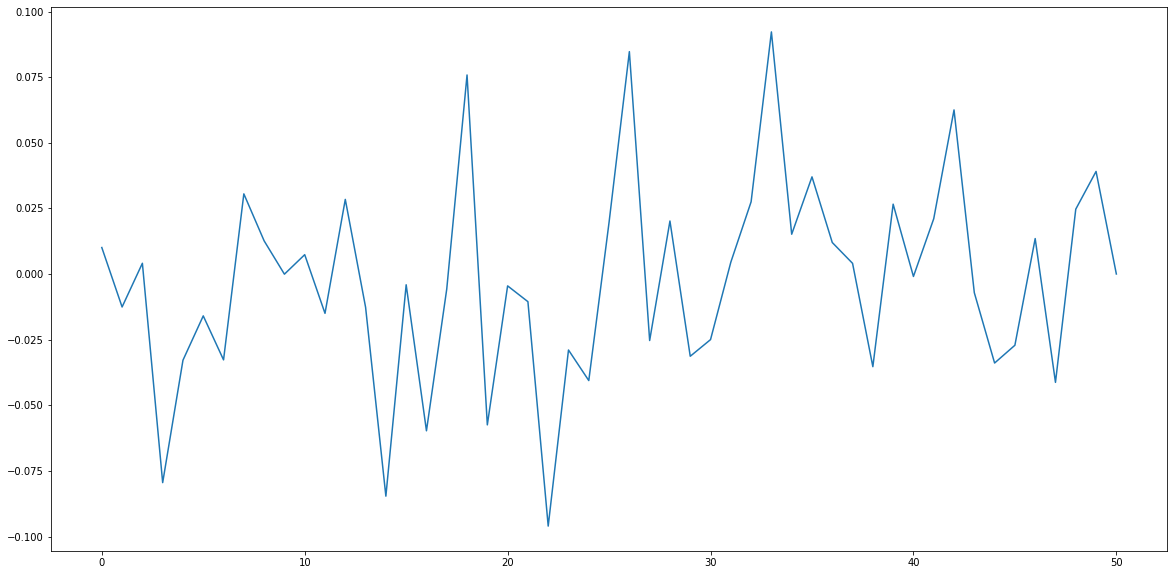

(51,)


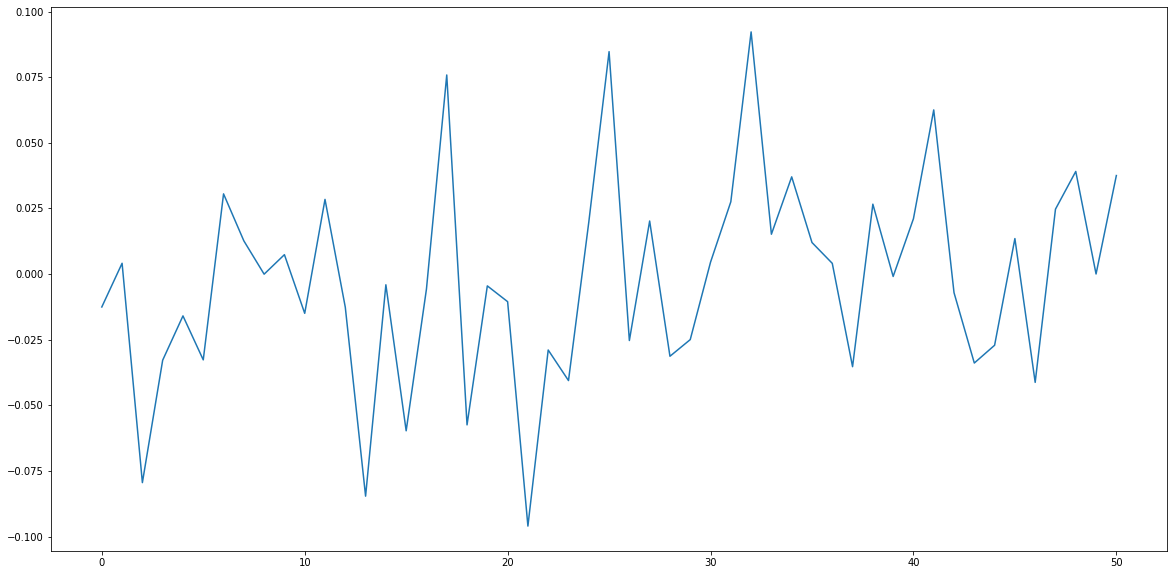

(51,)


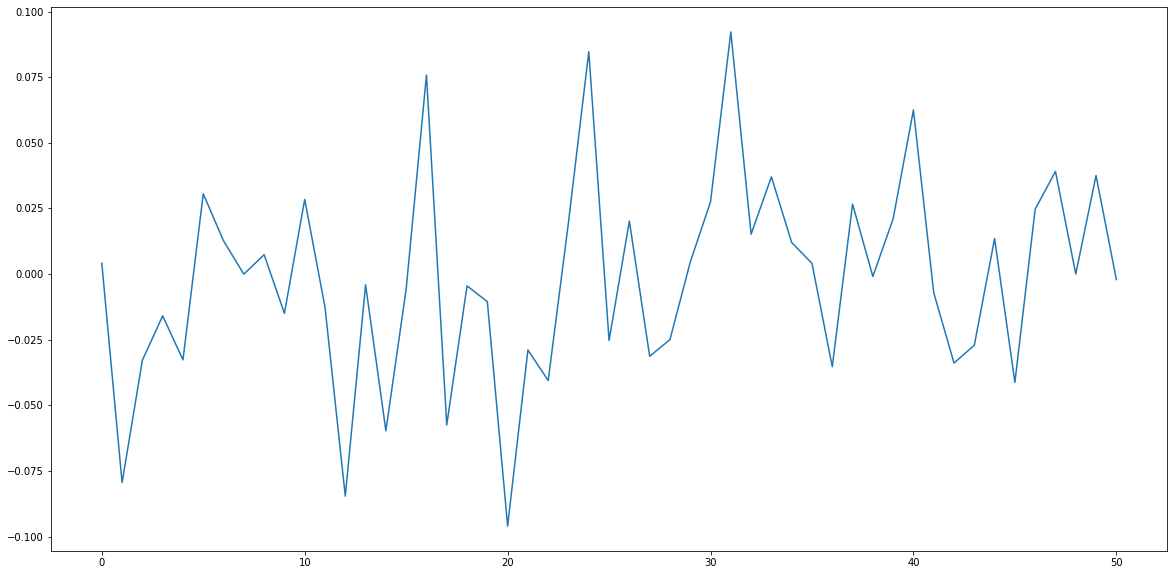

(51,)


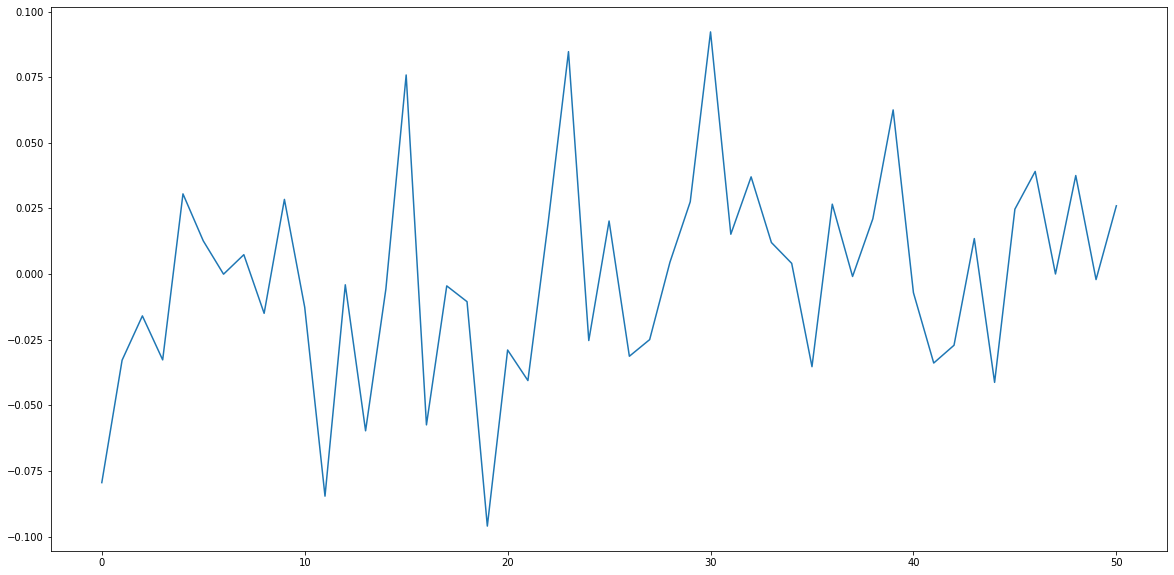

(51,)


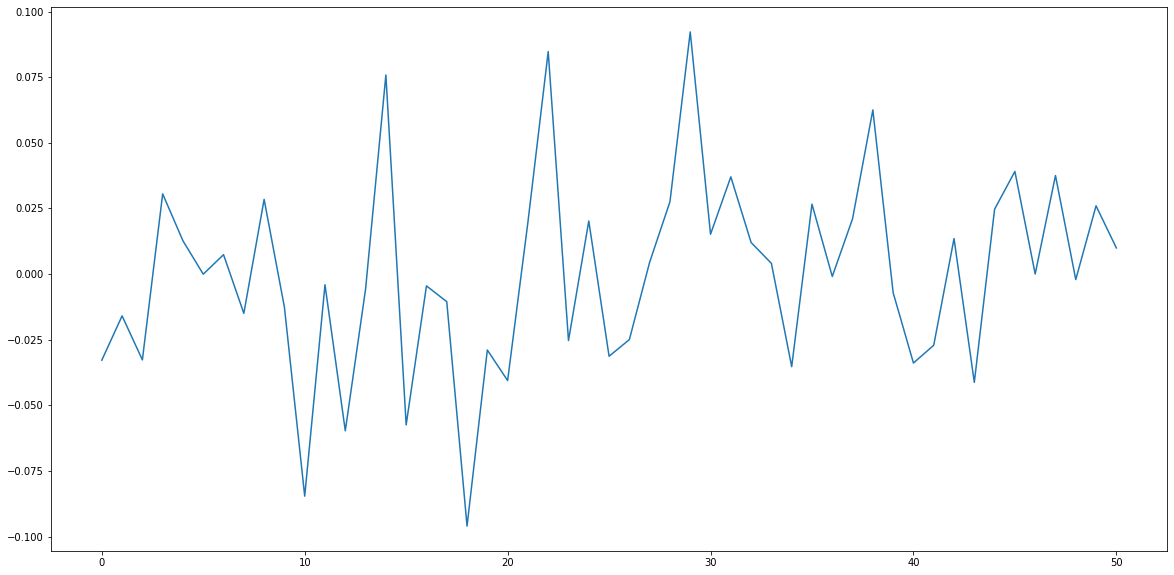

(51,)


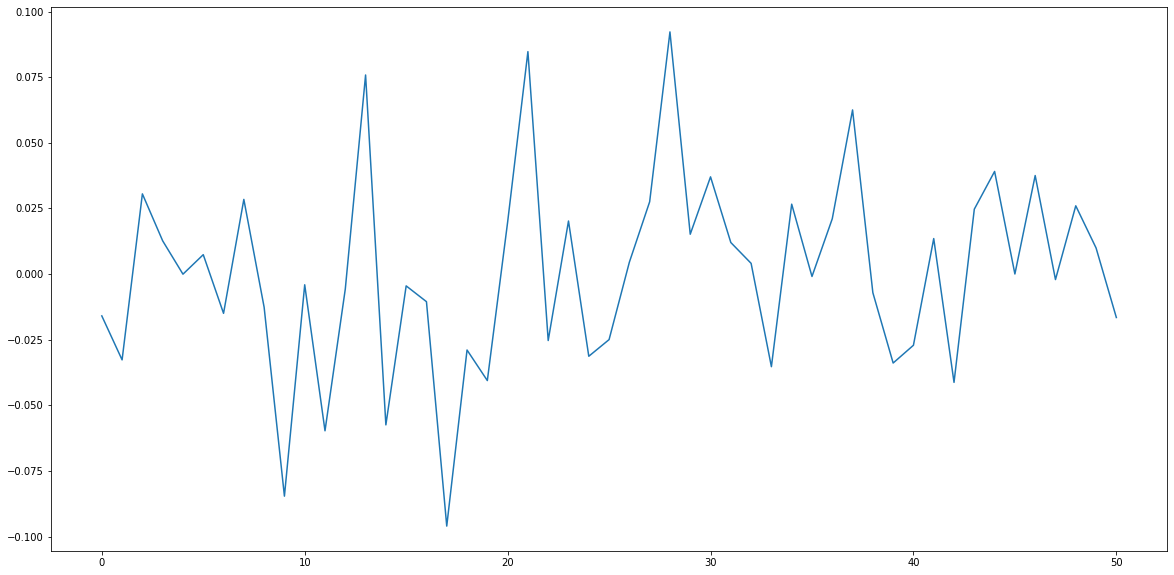

(51,)


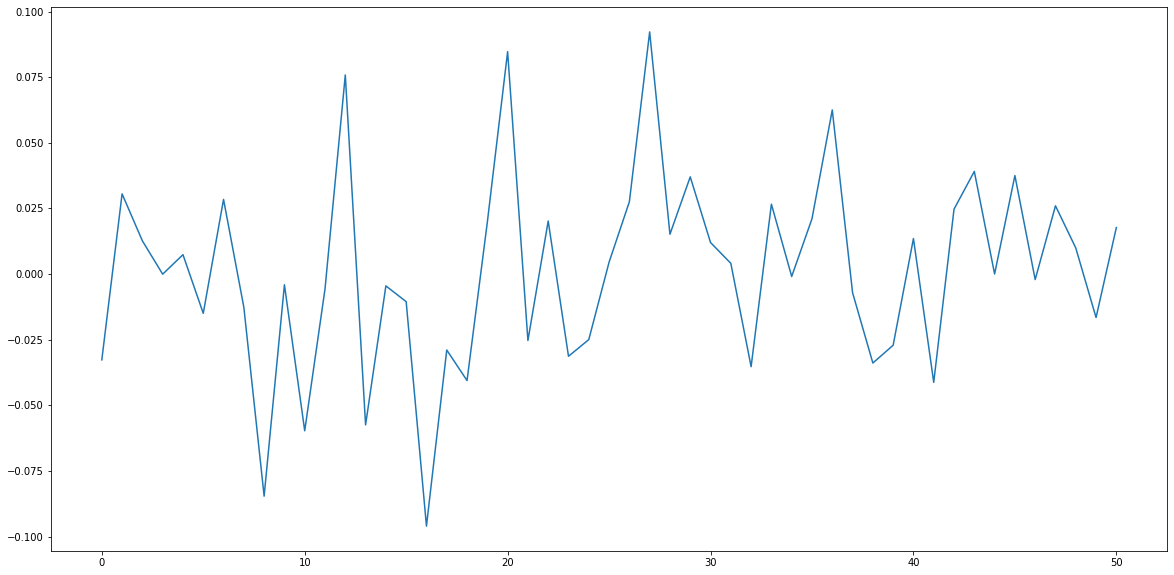

(51,)


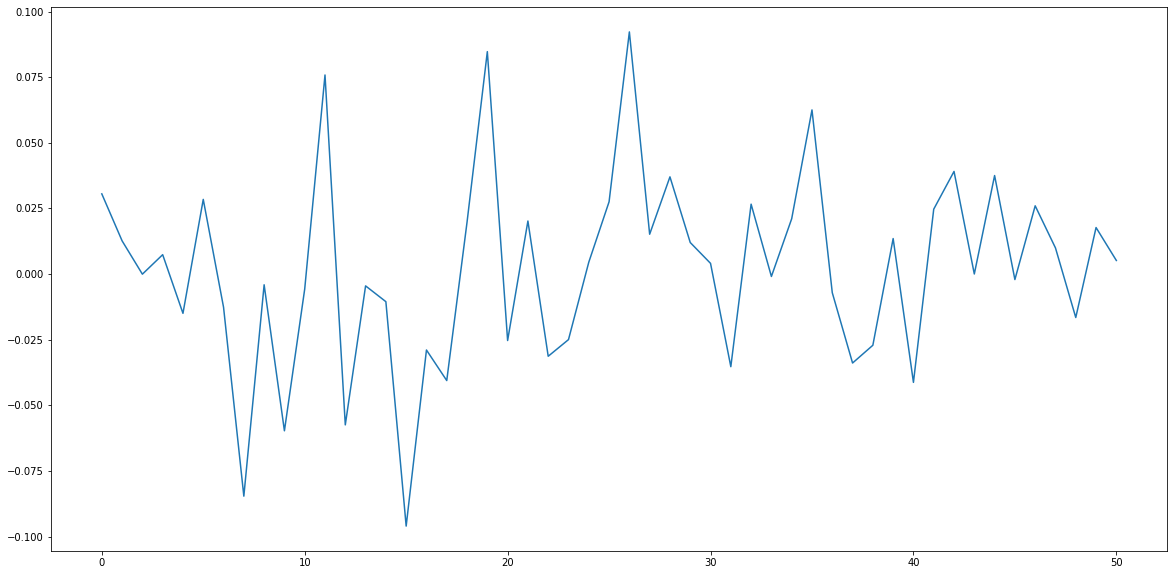

(51,)


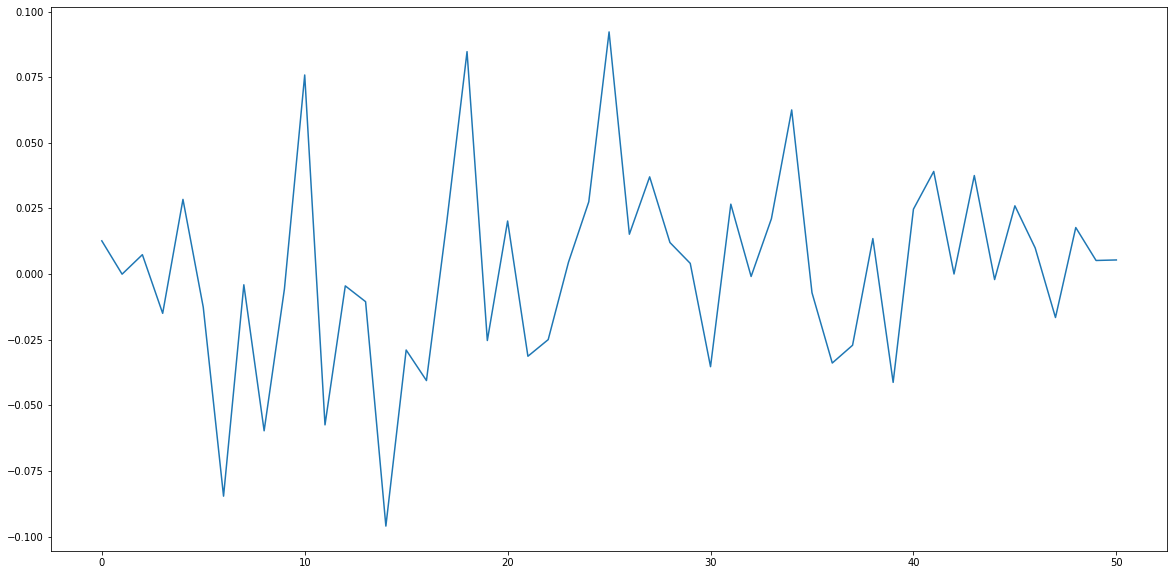

(51,)


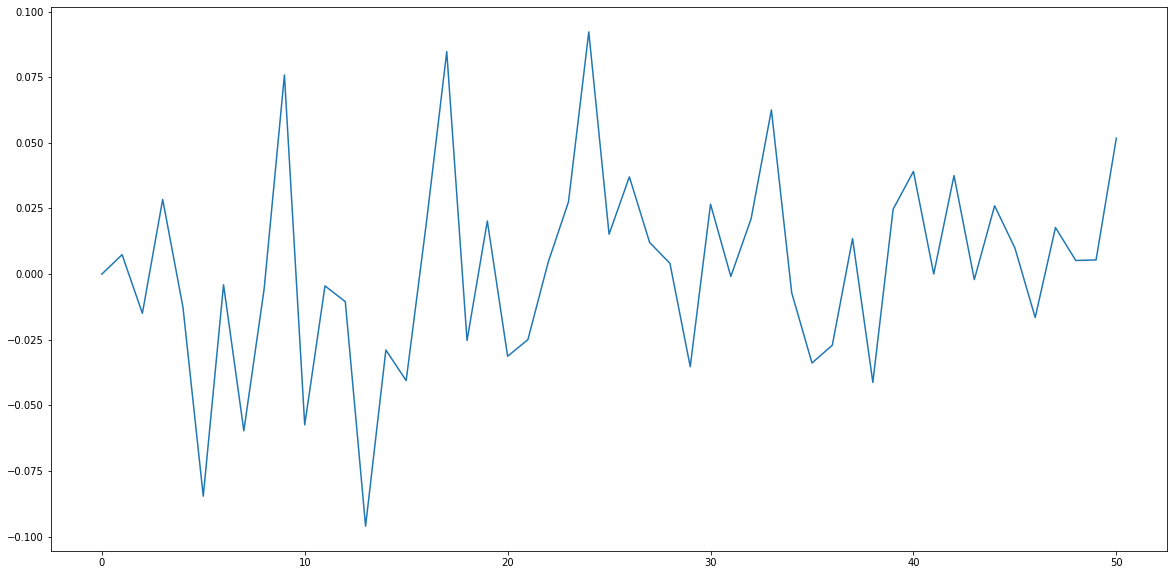

(51,)


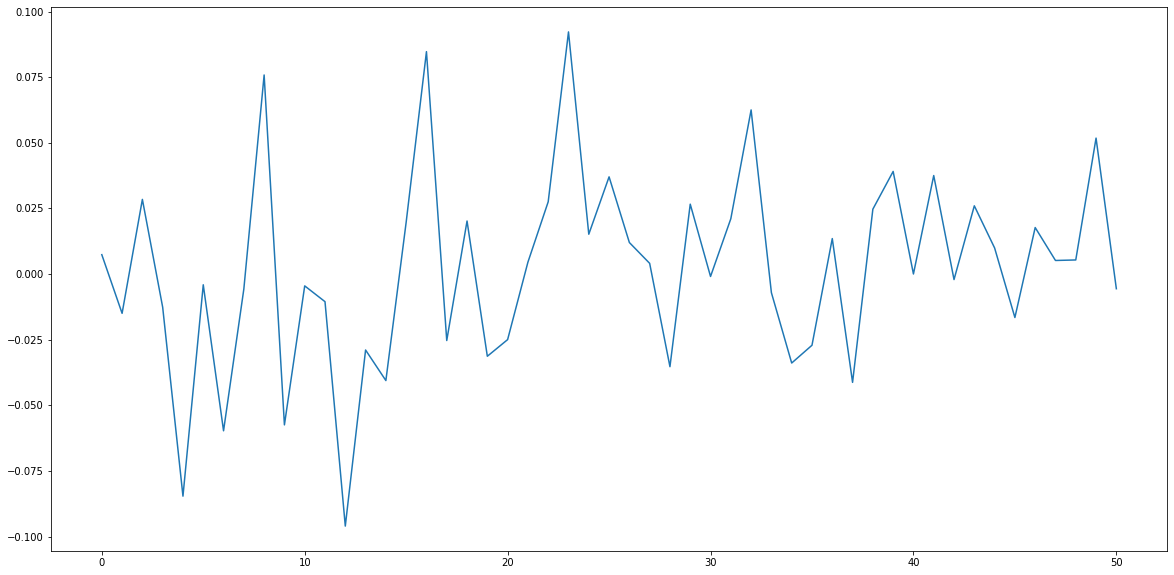

(51,)


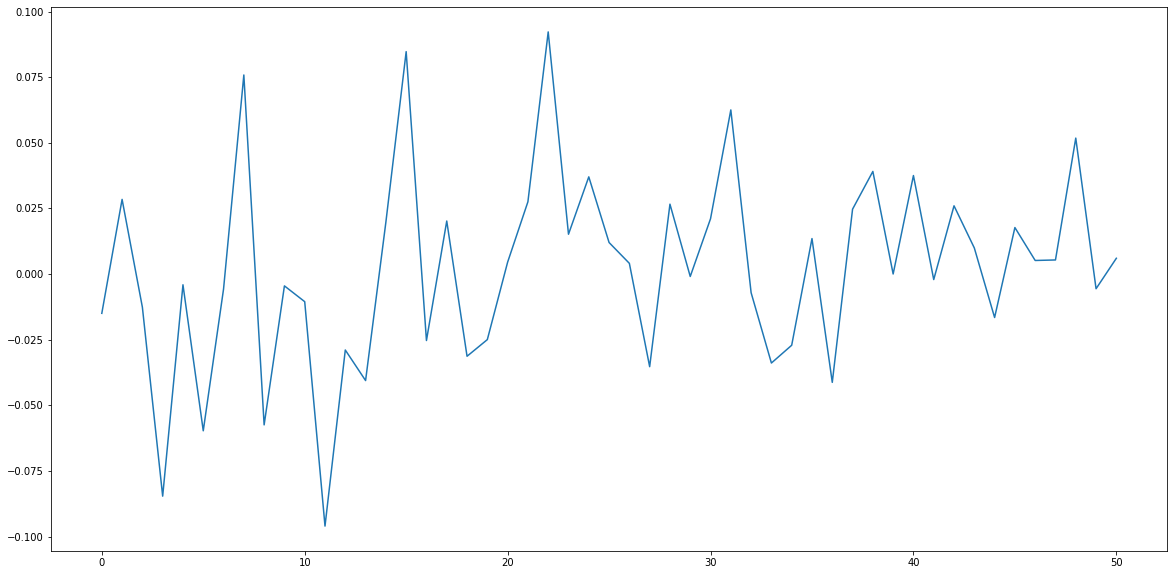

(51,)


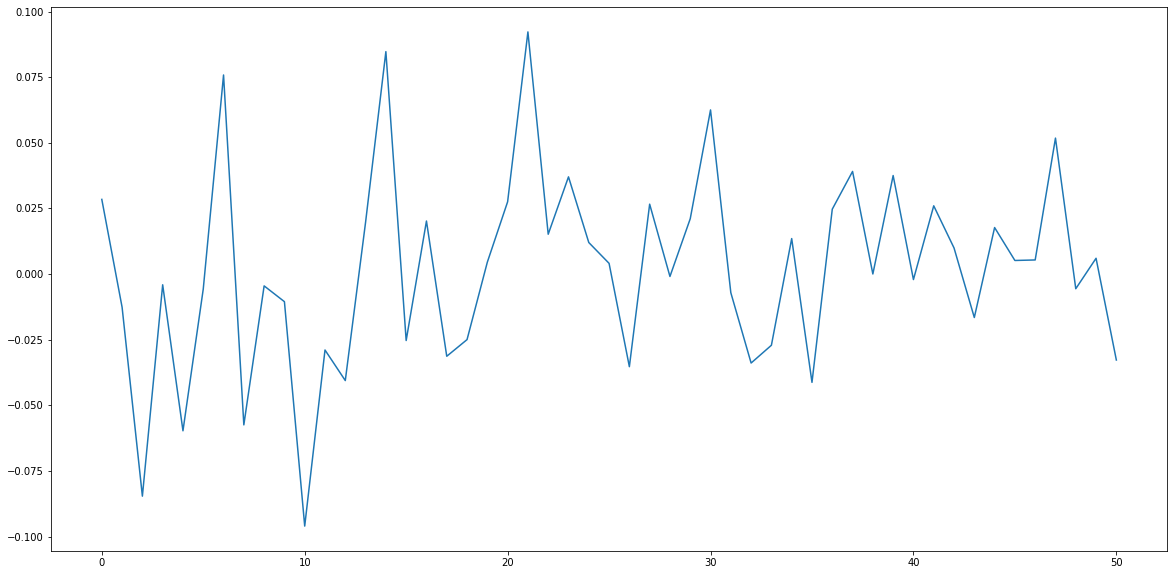

(51,)


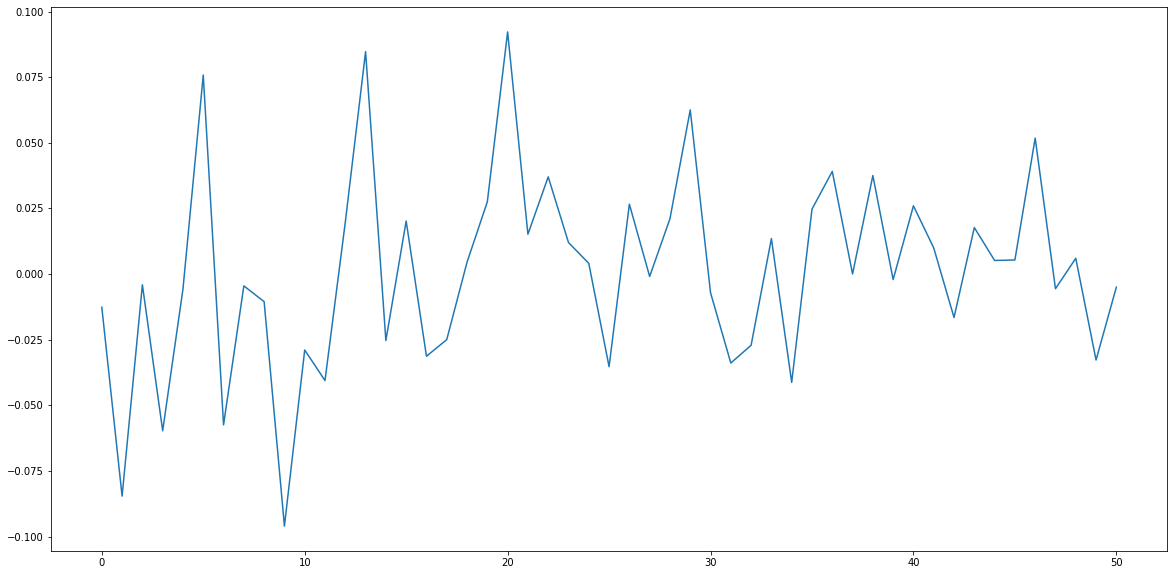

(51,)


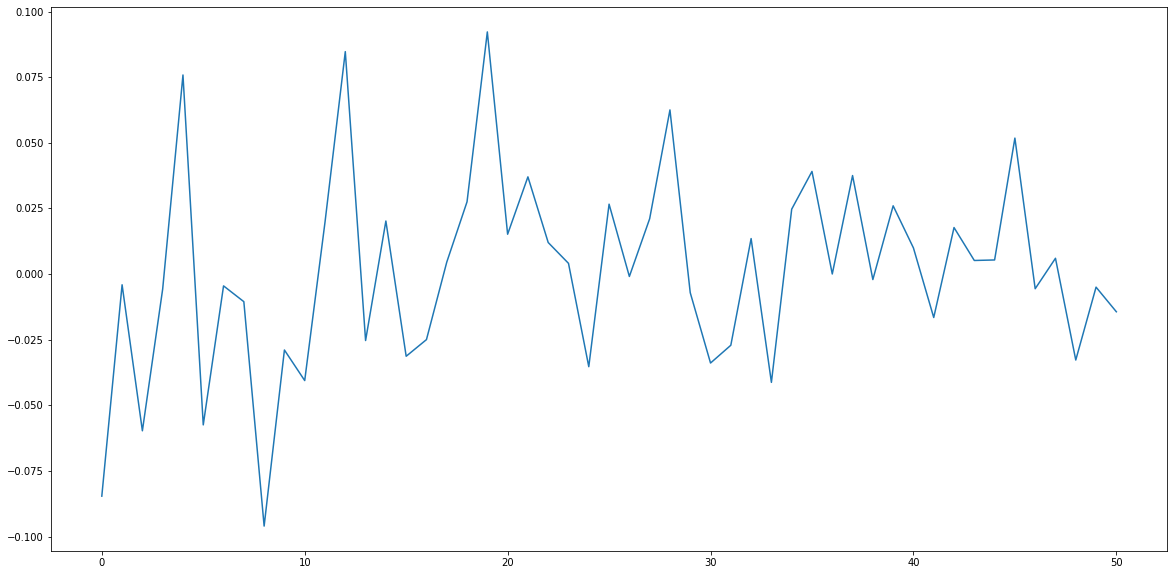

(51,)


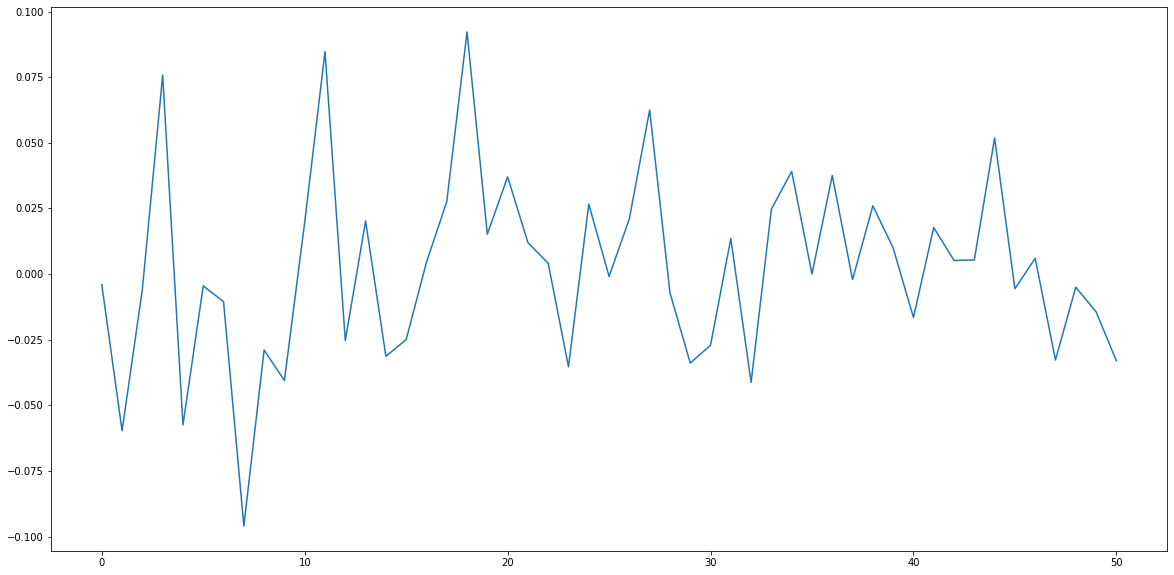

(51,)


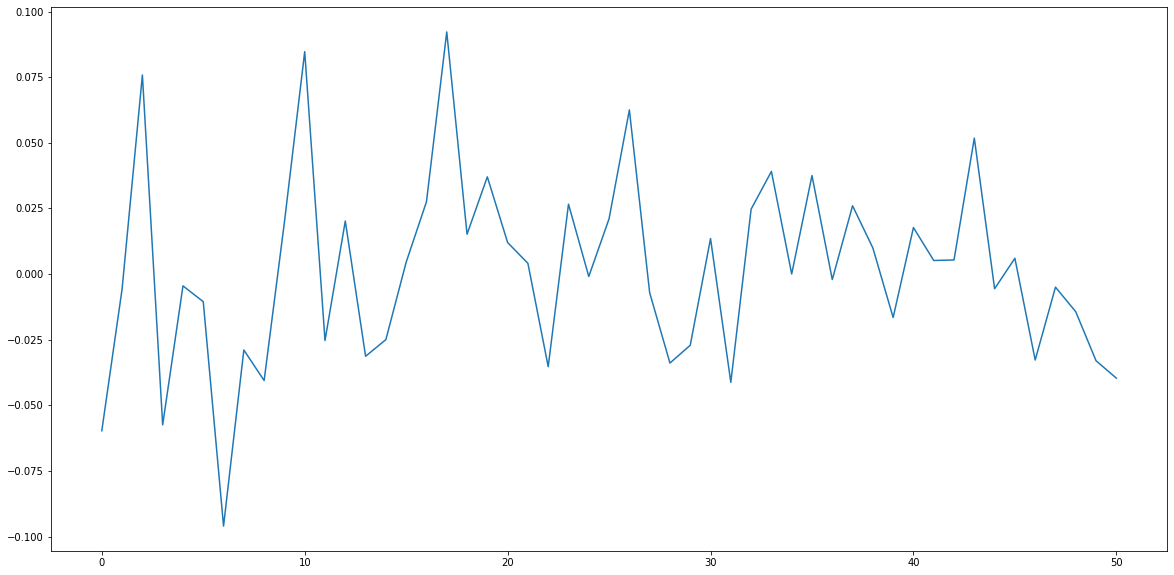

(51,)


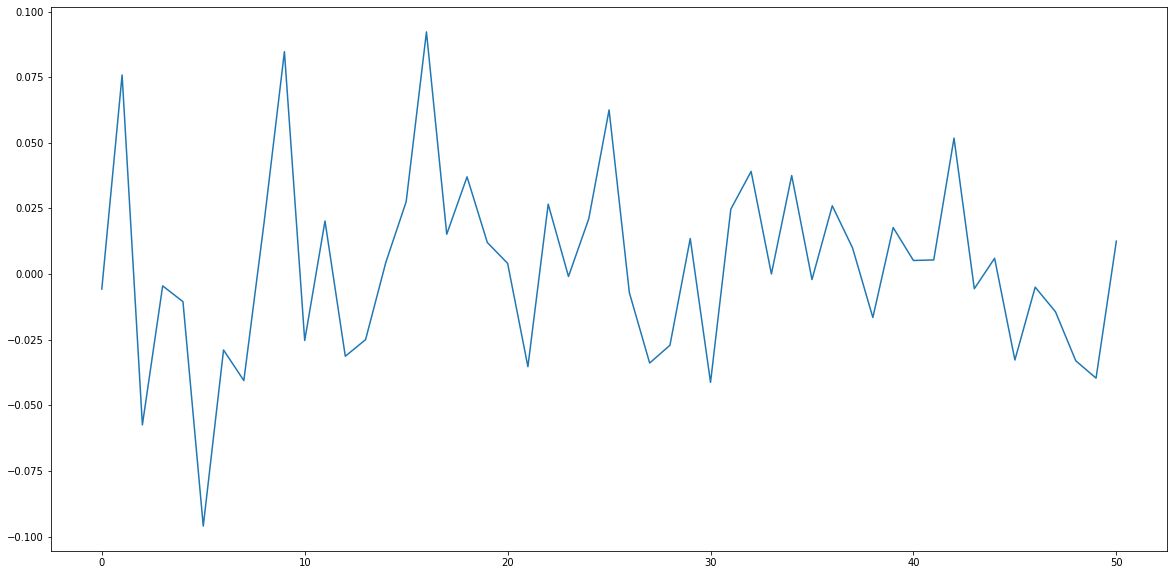

(51,)


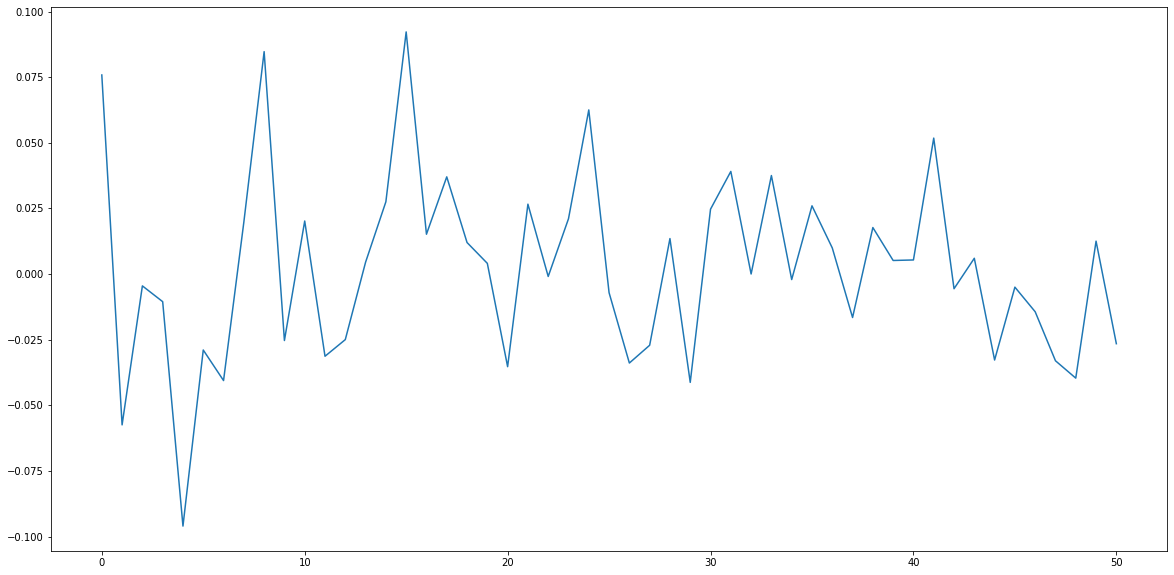

(51,)


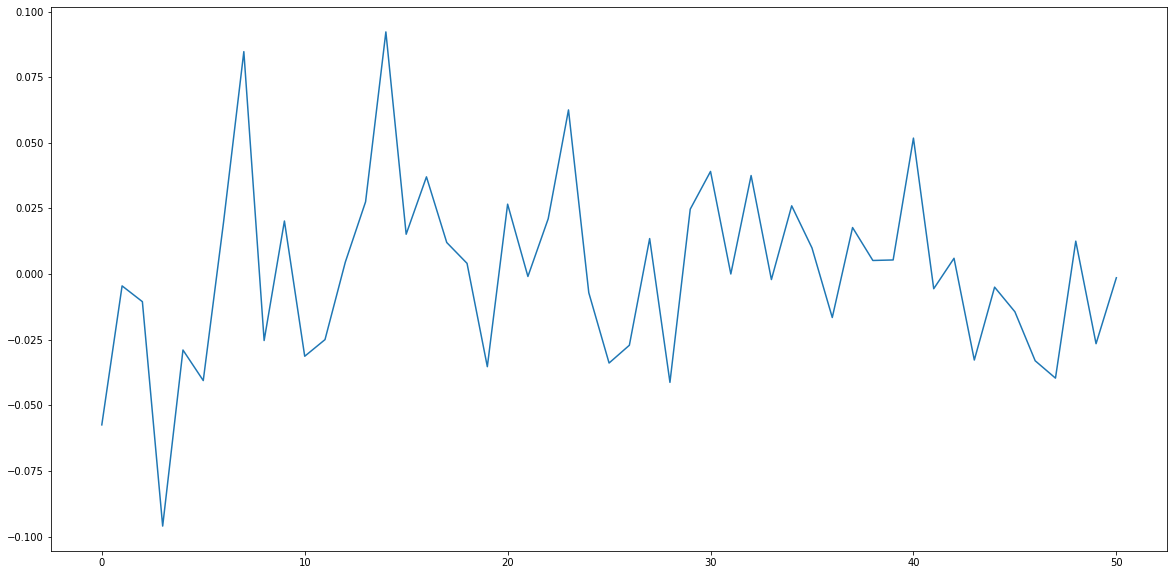

In [305]:
model_AttentionOut = model  # include here your original model

layer_name = 'timestep_diff'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    print(intermediate_output[0,:,7060].shape)
    plt.figure(figsize=(20,10))
    plt.plot(intermediate_output[0,:,7060])
    plt.show()

In [448]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=6, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 52, 100)           4040400   
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_65 (Dense)             (None, 1000)              101000    
Total params: 4,221,800
Trainable params: 4,221,800
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 28 samples
Epoch 1/1000
 6/88 [=>............................] - ETA: 3sWAR

ValueError: Dimensions must be equal, but are 1000 and 10000 for 'loss/dense_65_loss/sub' (op: 'Sub') with input shapes: [?,1000], [?,10000].

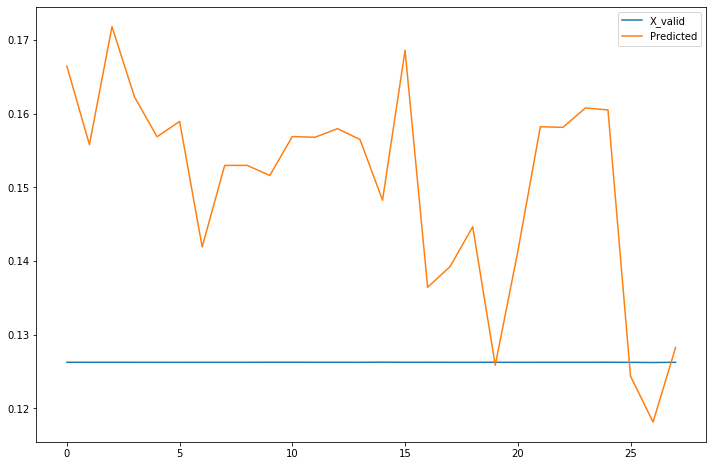

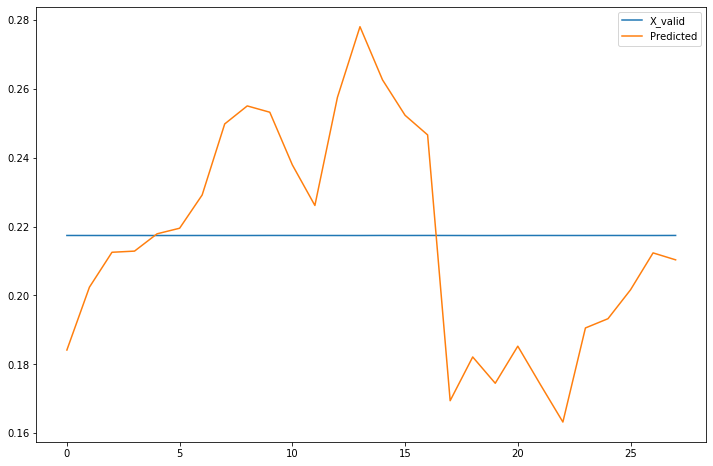

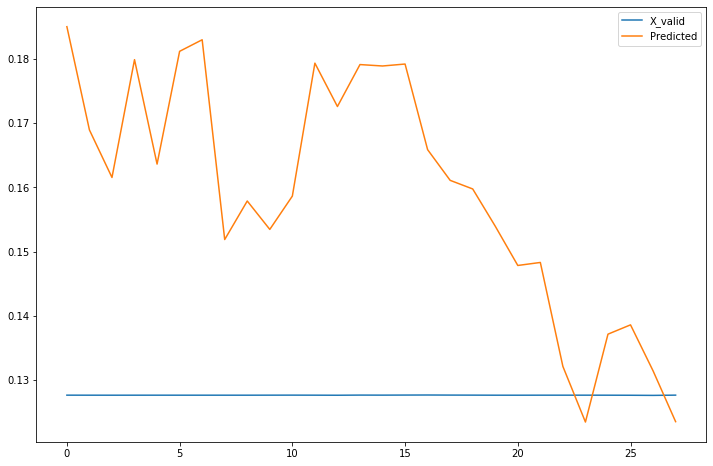

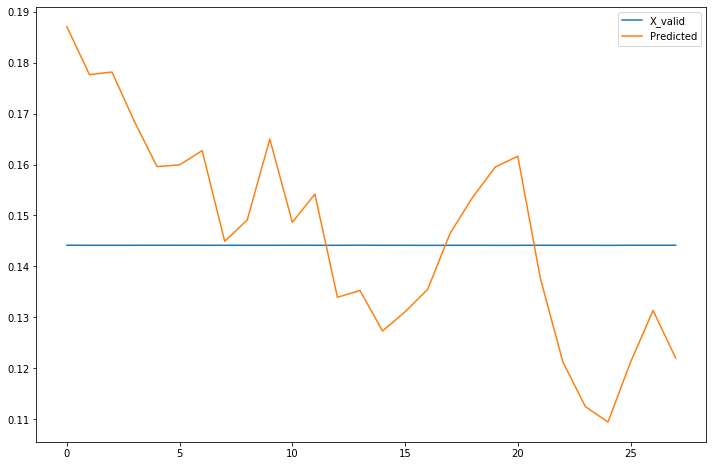

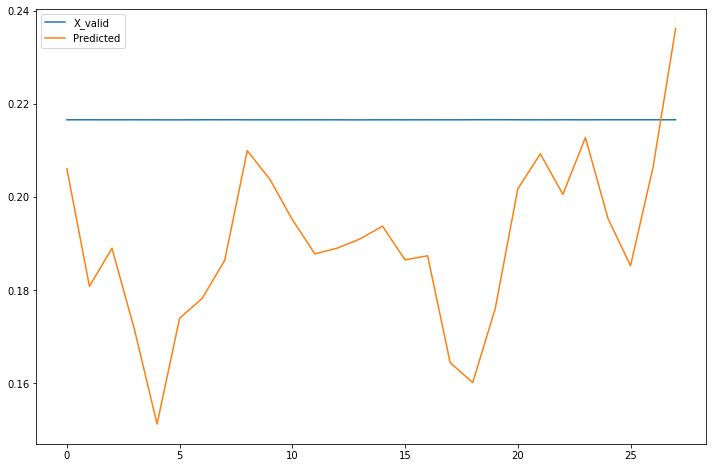

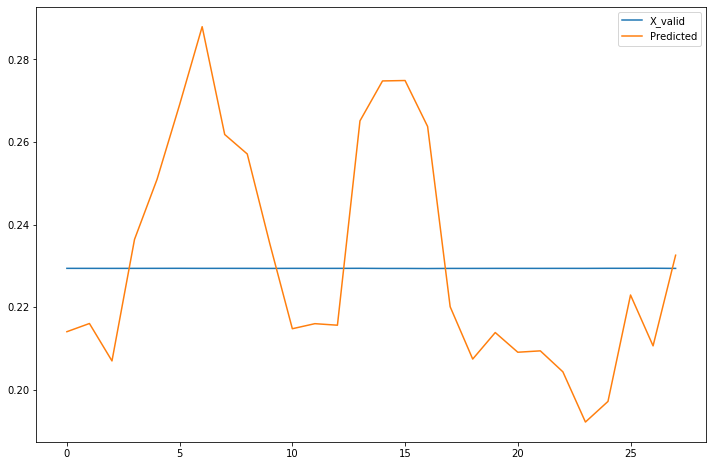

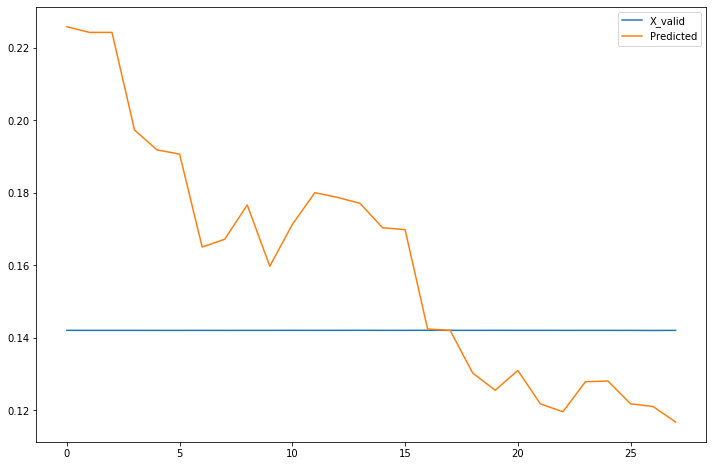

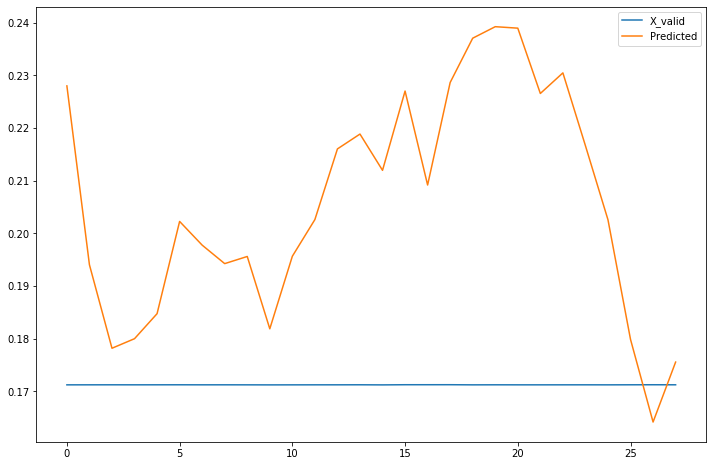

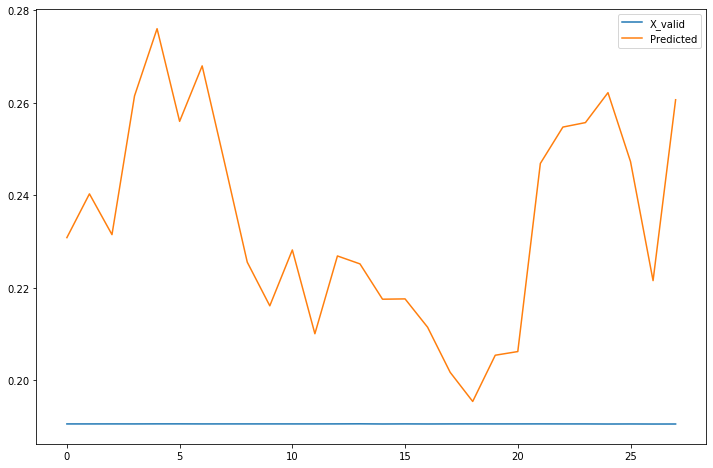

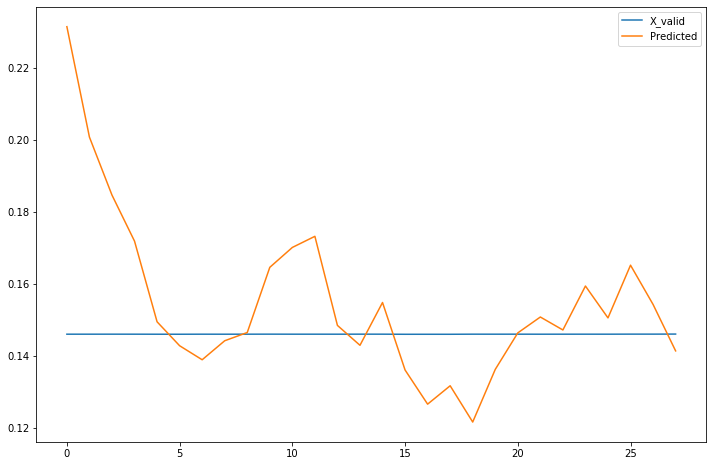

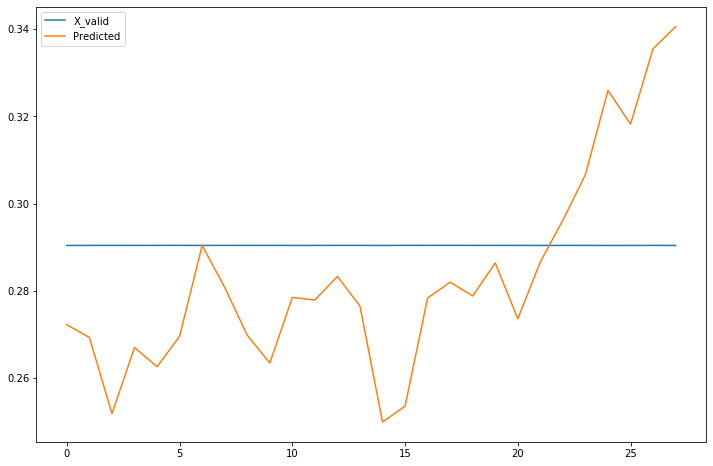

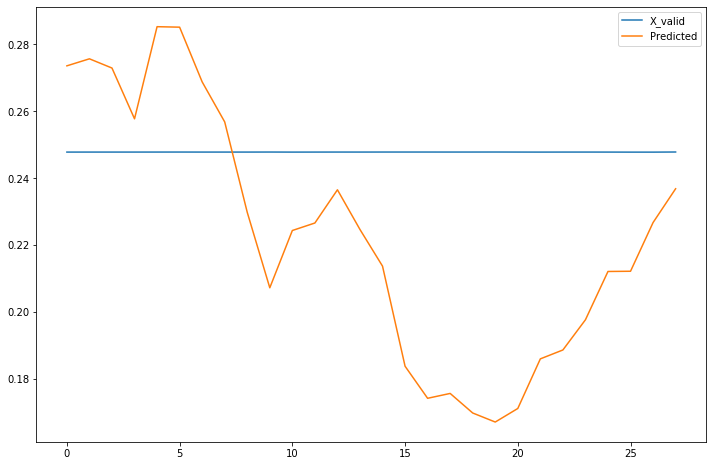

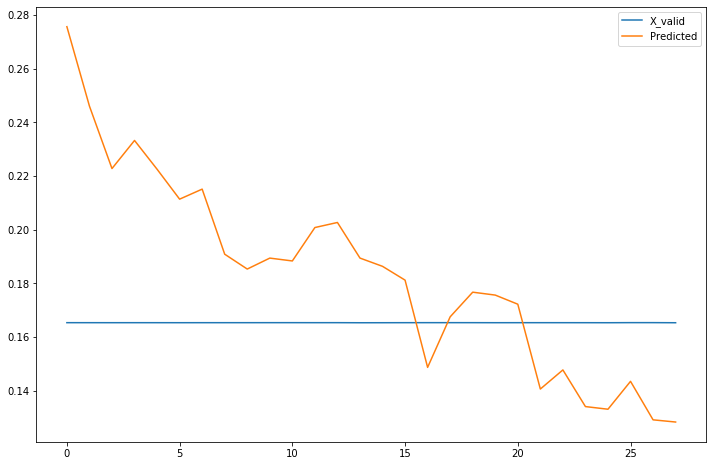

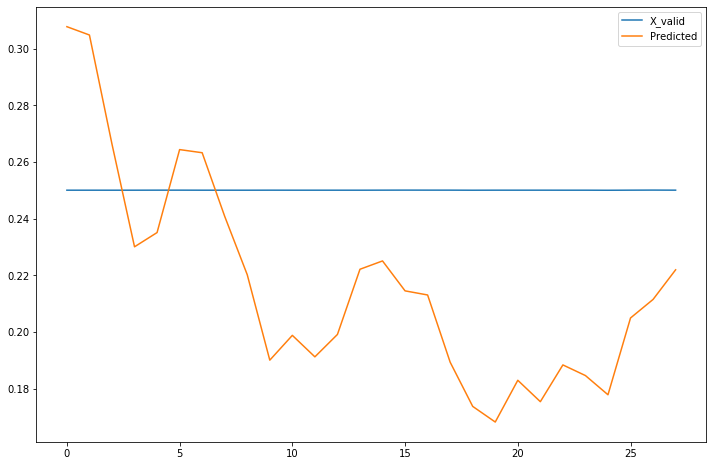

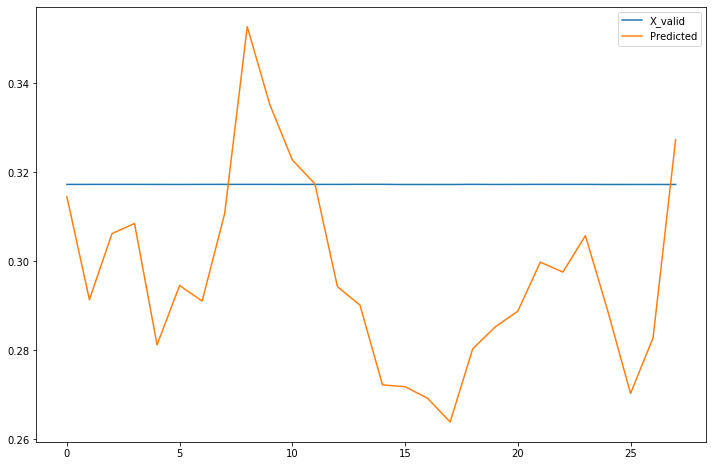

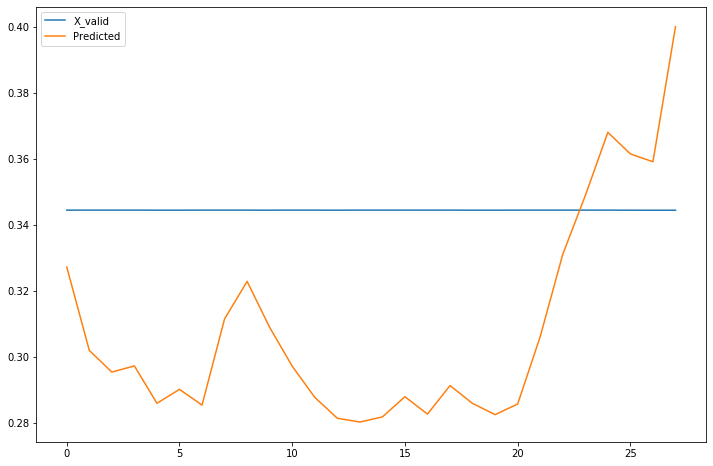

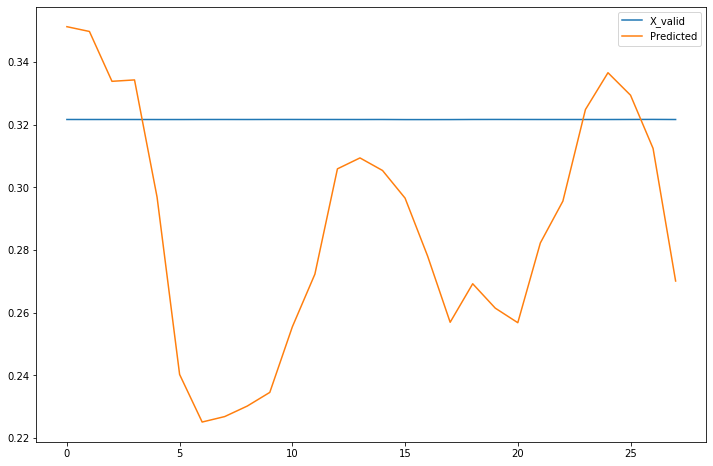

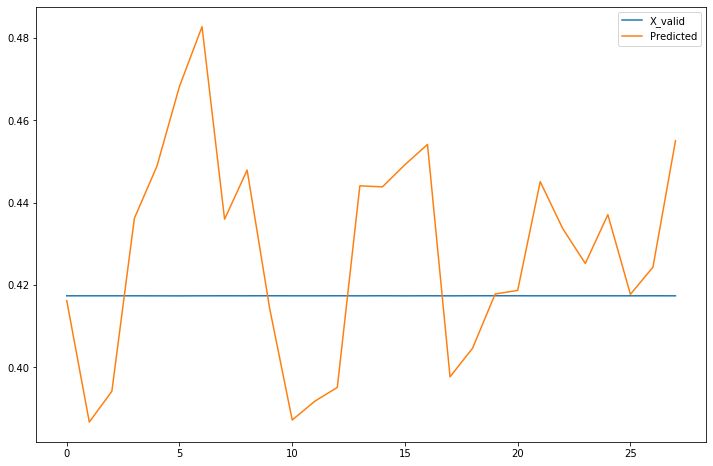

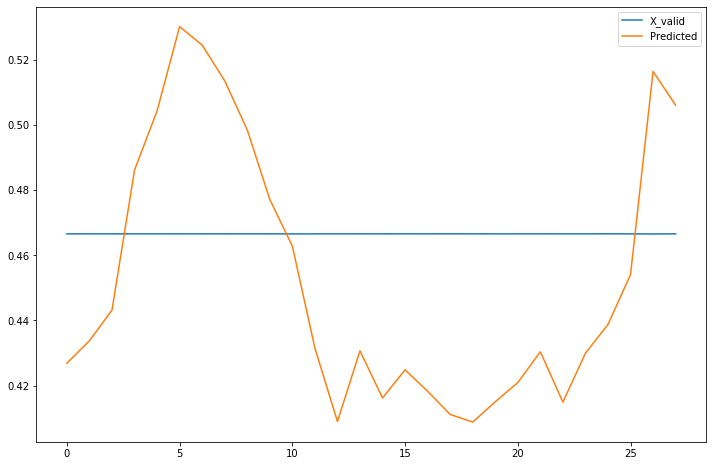

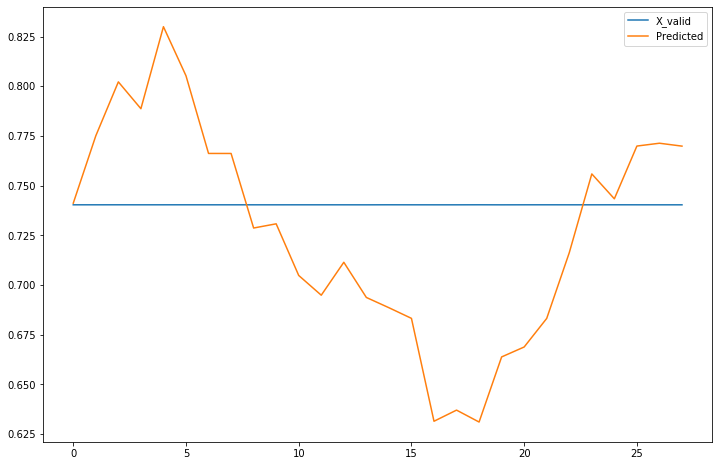

In [307]:
Predict = model.predict(X_valid)
for i in np.argsort(Y_valid)[:,-20:][0]:
    pd.DataFrame(np.transpose(np.vstack([Predict[:,i],Y_valid[:,i]])),columns=["X_valid","Predicted"]).plot(figsize=(12,8))

In [308]:
for i in range(Predict.shape[0]-1):
    diff_ts = Predict[i,:] - Predict[i+1,:]
    print(np.sum(diff_ts[np.argsort(diff_ts)]))

8.436758e-05
2.4692155e-05
-2.4693087e-05
-0.0005259253
-0.00020185392
0.00074565597
0.00018047541
-0.00038351864
0.00026562996
-0.00041406602
0.0003558686
-0.0014496036
0.0014160462
0.00012625754
-0.0023436174
-2.901256e-05
0.000696782
0.0009964257
-0.0005347617
0.0014123265
-0.0008938182
0.00051668845
0.000252062
0.000110108405
0.00075205043
0.0010715537
-0.0021801963
